In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import cross_val_score
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.options.mode.chained_assignment = None

# Importing

In [2]:
os.chdir("C:/Users/Tom/Documents/Course/Semester 3/Project/Data Sets/")

In [3]:
#Importing the Indoor Air Quality sensor data
IAQ_LR = pd.read_csv("IAQ_livingroom.csv", parse_dates=['Date and Time'], index_col='Date and Time', dayfirst=True)
IAQ_KR = pd.read_csv("IAQ_kitchen.csv", parse_dates=['Date and Time'], index_col='Date and Time', dayfirst=True)
IAQ_BR = pd.read_csv("IAQ_bedroom.csv", parse_dates=['Date and Time'], index_col='Date and Time', dayfirst=True)

In [4]:
#Creating datasets to hold just the data for when devices were together for calibration purposes
Cal_LR = IAQ_LR[IAQ_LR["Calibration"] == 1].drop(["Calibration"], axis=1)
Cal_KR = IAQ_KR[IAQ_KR["Calibration"] == 1].drop(["Calibration"], axis=1)
Cal_BR = IAQ_BR[IAQ_BR["Calibration"] == 1].drop(["Calibration"], axis=1)

#Removing the calibration observations from our sensor data
IAQ_LR = IAQ_LR[IAQ_LR["Calibration"] == 0].drop(["Calibration"], axis=1)
IAQ_KR = IAQ_KR[IAQ_KR["Calibration"] == 0].drop(["Calibration"], axis=1)
IAQ_BR = IAQ_BR[IAQ_BR["Calibration"] == 0].drop(["Calibration"], axis=1)

In [5]:
#Bringing in the Occupant Activity. Shower holds a variable only used on House 2 to see if it made any impact on PM2.5
activity_LR = pd.read_csv("activity_livingroom.csv", parse_dates=['Date and Time'], index_col='Date and Time', dayfirst=True)
activity_KR = pd.read_csv("activity_Kitchen.csv", parse_dates=['Date and Time'], index_col='Date and Time', dayfirst=True)
activity_BR = pd.read_csv("activity_Bedroom.csv", parse_dates=['Date and Time'], index_col='Date and Time', dayfirst=True)
shower = pd.read_csv("activity_bathroom.csv", parse_dates=['Date and Time'], index_col='Date and Time', dayfirst=True)


In [6]:
#Joining all activities in the same dataset as they have unique names such as "LR_MaxOccupancy", "BR_MaxOccupancy" and so on.
activity = pd.merge(activity_LR, activity_KR, left_index=True, right_index=True).merge(
    activity_BR, left_index=True, right_index=True).merge(shower, left_index=True, right_index=True)

In [7]:
#To consider time as a feature in our model, we've created a feature storing all 24 hours and one for Time of day

activity['Hour'] = activity.index.strftime('%H').astype(int)
activity["timeOfDay"]=pd.cut(activity.index.hour, [-1, 5, 11, 17, 24], labels=['Night', "Morning", 'Afternoon', 'Evening'])
activity["timeOfDay"] = activity["timeOfDay"].cat.codes

# Calibration

In this section we'll analyse the calibration plots for House 1 and 2 for all sensor features. If they're highly correlated, we'll bring their into agreement through their difference in means. If not, they'll be excluded from the model.

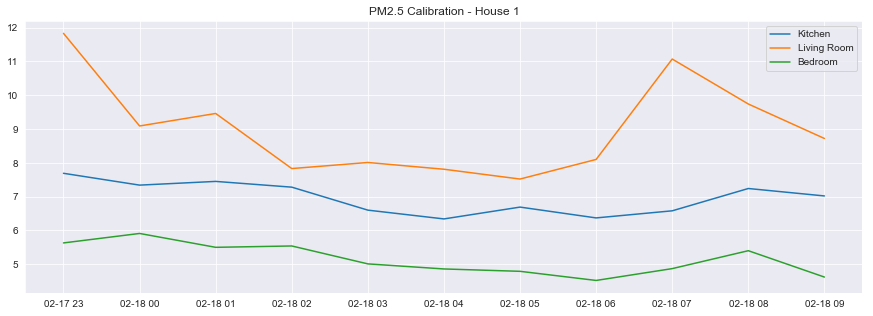

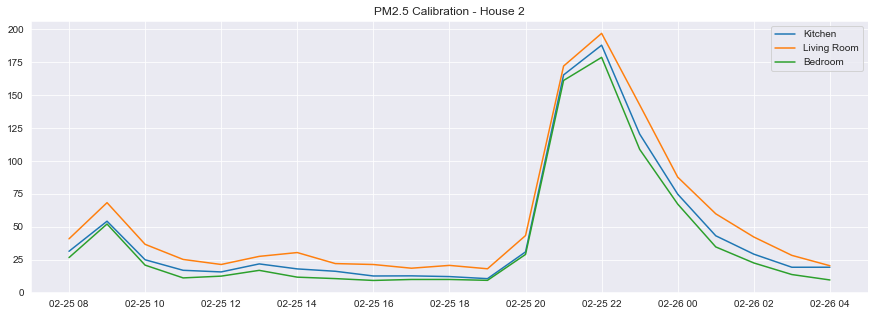

In [8]:
###############################################################################
################################## P M 2 . 5 ##################################
###############################################################################

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["PM2.5"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["PM2.5"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["PM2.5"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("PM2.5 Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["PM2.5"][Cal_KR["House"] == 3], label='Kitchen')
plt.plot(Cal_LR["PM2.5"][Cal_LR["House"] == 3], label='Living Room')
plt.plot(Cal_BR["PM2.5"][Cal_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("PM2.5 Calibration - House 2")
plt.show();

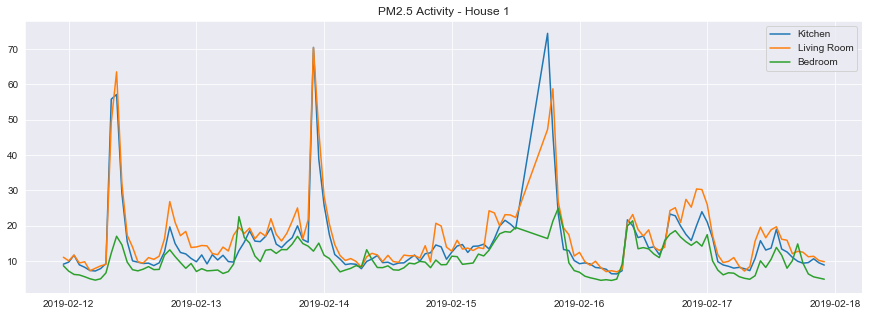

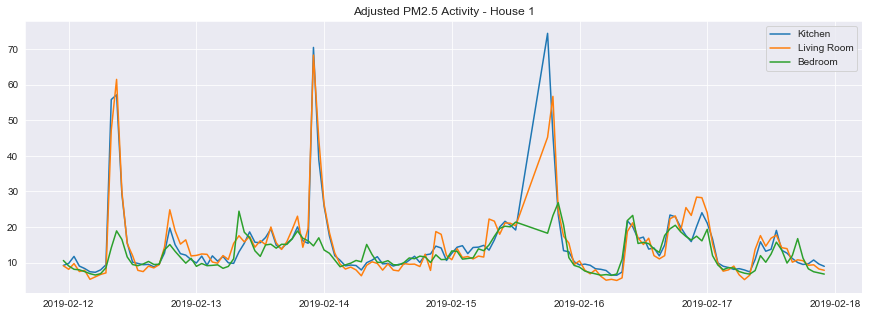

In [9]:
################################ H O U S E   1 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["PM2.5"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["PM2.5"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["PM2.5"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("PM2.5 Activity - House 1")
plt.show()

KR1_Cal_PM25_mean = Cal_KR["PM2.5"][Cal_KR["House"]==2].mean()
LR1_Cal_PM25_mean = Cal_LR["PM2.5"][Cal_LR["House"]==2].mean()
BR1_Cal_PM25_mean = Cal_BR["PM2.5"][Cal_BR["House"]==2].mean()

H1_Cal_PM25_mean = (KR1_Cal_PM25_mean + LR1_Cal_PM25_mean + BR1_Cal_PM25_mean)/3

KR1_PM25_adjustment = KR1_Cal_PM25_mean - H1_Cal_PM25_mean
LR1_PM25_adjustment = LR1_Cal_PM25_mean - H1_Cal_PM25_mean
BR1_PM25_adjustment = BR1_Cal_PM25_mean - H1_Cal_PM25_mean

IAQ_KR["PM2.5"][IAQ_KR["House"]==2] -= KR1_PM25_adjustment
IAQ_LR["PM2.5"][IAQ_LR["House"]==2] -= LR1_PM25_adjustment
IAQ_BR["PM2.5"][IAQ_BR["House"]==2] -= BR1_PM25_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["PM2.5"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["PM2.5"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["PM2.5"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Adjusted PM2.5 Activity - House 1")
plt.show();

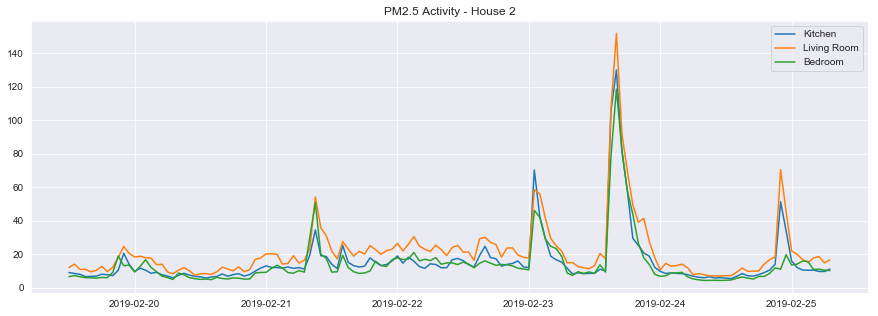

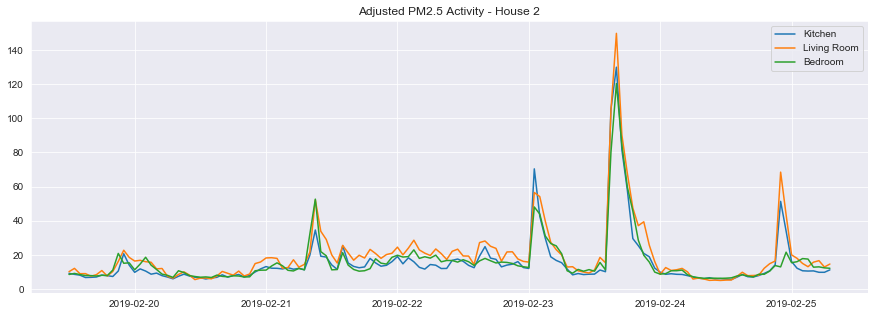

In [10]:
################################ H O U S E   2 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["PM2.5"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["PM2.5"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["PM2.5"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("PM2.5 Activity - House 2")
plt.show()

KR2_Cal_PM25_mean = Cal_KR["PM2.5"][Cal_KR["House"]==3].mean()
LR2_Cal_PM25_mean = Cal_LR["PM2.5"][Cal_LR["House"]==3].mean()
BR2_Cal_PM25_mean = Cal_BR["PM2.5"][Cal_BR["House"]==3].mean()

H2_Cal_PM25_mean = (KR2_Cal_PM25_mean + LR2_Cal_PM25_mean + BR2_Cal_PM25_mean)/3

KR2_PM25_adjustment = KR2_Cal_PM25_mean - H2_Cal_PM25_mean
LR2_PM25_adjustment = LR2_Cal_PM25_mean - H2_Cal_PM25_mean
BR2_PM25_adjustment = BR2_Cal_PM25_mean - H2_Cal_PM25_mean

IAQ_KR["PM2.5"][IAQ_KR["House"]==3] -= KR1_PM25_adjustment
IAQ_LR["PM2.5"][IAQ_LR["House"]==3] -= LR1_PM25_adjustment
IAQ_BR["PM2.5"][IAQ_BR["House"]==3] -= BR1_PM25_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["PM2.5"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["PM2.5"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["PM2.5"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("Adjusted PM2.5 Activity - House 2")
plt.show();

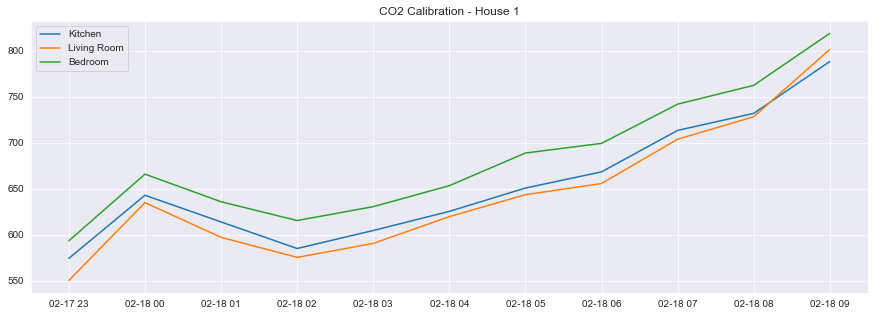

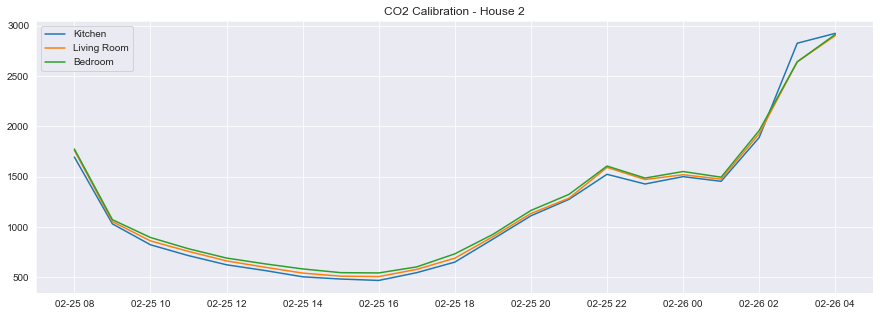

In [11]:
###############################################################################
#################################### C O 2 ####################################
###############################################################################

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["CO2"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["CO2"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["CO2"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("CO2 Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["CO2"][Cal_KR["House"] == 3], label='Kitchen')
plt.plot(Cal_LR["CO2"][Cal_LR["House"] == 3], label='Living Room')
plt.plot(Cal_BR["CO2"][Cal_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("CO2 Calibration - House 2")
plt.show();

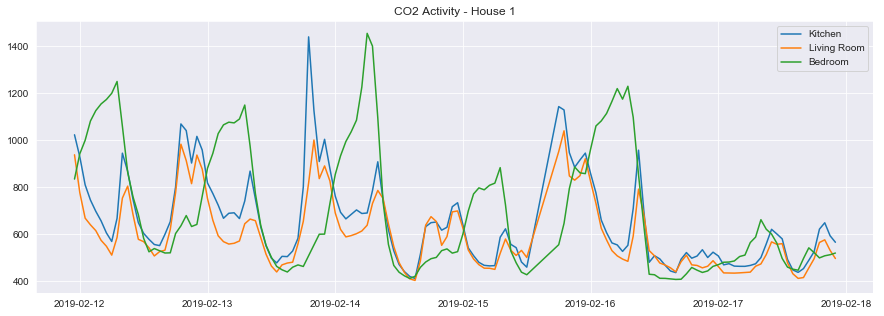

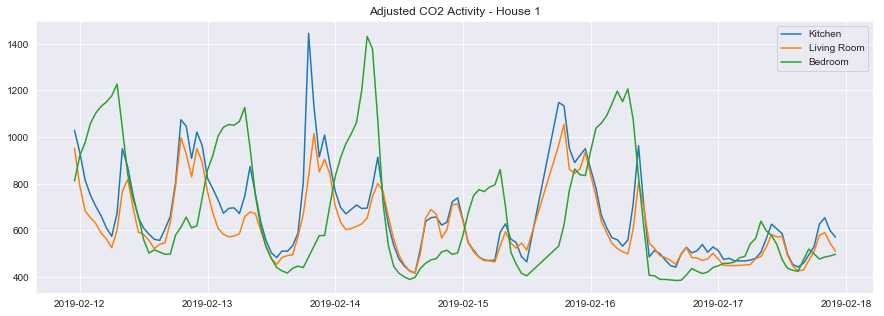

In [12]:
################################ H O U S E   1 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["CO2"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["CO2"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["CO2"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("CO2 Activity - House 1")
plt.show()

KR1_Cal_CO2_mean = Cal_KR["CO2"][Cal_KR["House"]==2].mean()
LR1_Cal_CO2_mean = Cal_LR["CO2"][Cal_LR["House"]==2].mean()
BR1_Cal_CO2_mean = Cal_BR["CO2"][Cal_BR["House"]==2].mean()

H1_Cal_CO2_mean = (KR1_Cal_CO2_mean + LR1_Cal_CO2_mean + BR1_Cal_CO2_mean)/3

KR1_CO2_adjustment = KR1_Cal_CO2_mean - H1_Cal_CO2_mean
LR1_CO2_adjustment = LR1_Cal_CO2_mean - H1_Cal_CO2_mean
BR1_CO2_adjustment = BR1_Cal_CO2_mean - H1_Cal_CO2_mean

IAQ_KR["CO2"][IAQ_KR["House"]==2] -= KR1_CO2_adjustment
IAQ_LR["CO2"][IAQ_LR["House"]==2] -= LR1_CO2_adjustment
IAQ_BR["CO2"][IAQ_BR["House"]==2] -= BR1_CO2_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["CO2"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["CO2"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["CO2"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Adjusted CO2 Activity - House 1")
plt.show();

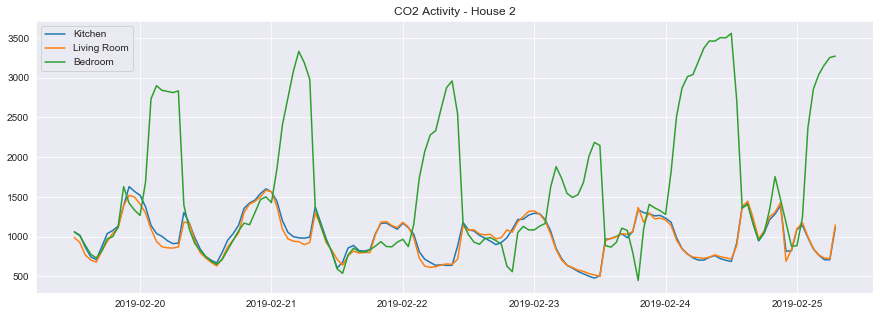

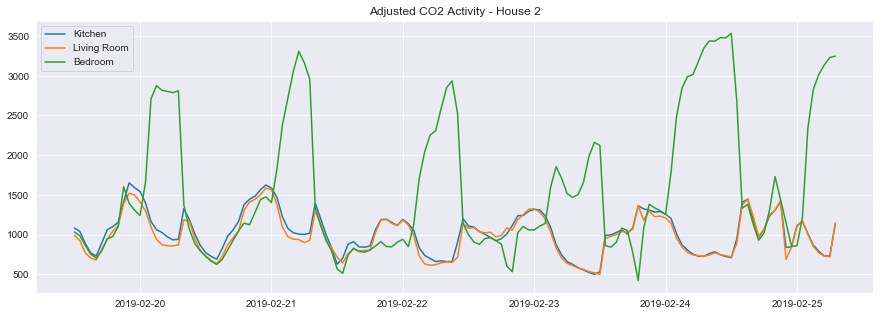

In [13]:
################################ H O U S E   2 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["CO2"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["CO2"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["CO2"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("CO2 Activity - House 2")
plt.show()

KR2_Cal_CO2_mean = Cal_KR["CO2"][Cal_KR["House"]==3].mean()
LR2_Cal_CO2_mean = Cal_LR["CO2"][Cal_LR["House"]==3].mean()
BR2_Cal_CO2_mean = Cal_BR["CO2"][Cal_BR["House"]==3].mean()

H2_Cal_CO2_mean = (KR2_Cal_CO2_mean + LR2_Cal_CO2_mean + BR2_Cal_CO2_mean)/3

KR2_CO2_adjustment = KR2_Cal_CO2_mean - H2_Cal_CO2_mean
LR2_CO2_adjustment = LR2_Cal_CO2_mean - H2_Cal_CO2_mean
BR2_CO2_adjustment = BR2_Cal_CO2_mean - H2_Cal_CO2_mean

IAQ_KR["CO2"][IAQ_KR["House"]==3] -= KR2_CO2_adjustment
IAQ_LR["CO2"][IAQ_LR["House"]==3] -= LR2_CO2_adjustment
IAQ_BR["CO2"][IAQ_BR["House"]==3] -= BR2_CO2_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["CO2"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["CO2"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["CO2"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("Adjusted CO2 Activity - House 2")
plt.show();

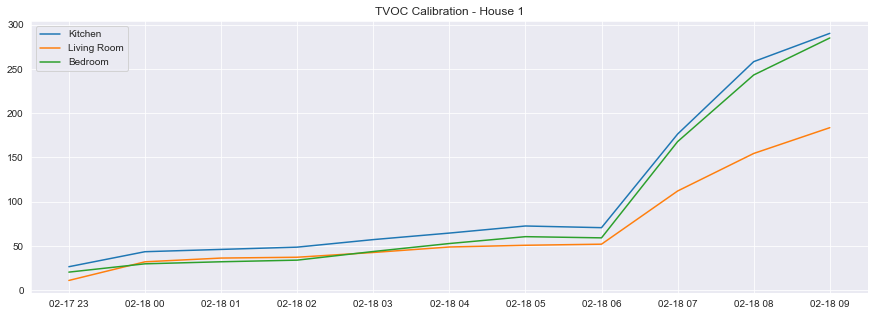

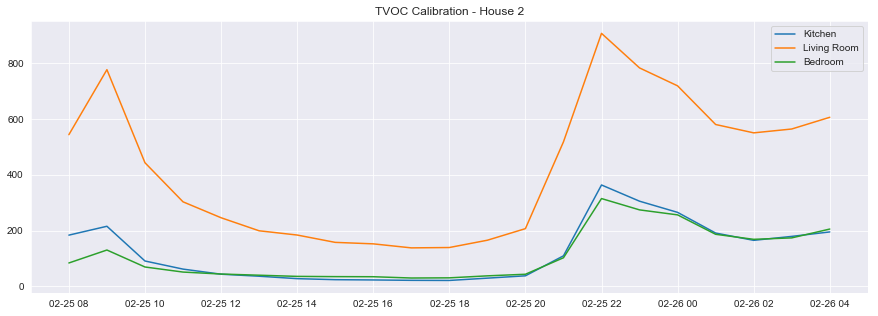

In [14]:
###############################################################################
################################### T V O C ###################################
###############################################################################

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["TVOC"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["TVOC"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["TVOC"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("TVOC Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["TVOC"][Cal_KR["House"] == 3], label='Kitchen')
plt.plot(Cal_LR["TVOC"][Cal_LR["House"] == 3], label='Living Room')
plt.plot(Cal_BR["TVOC"][Cal_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("TVOC Calibration - House 2")
plt.show();

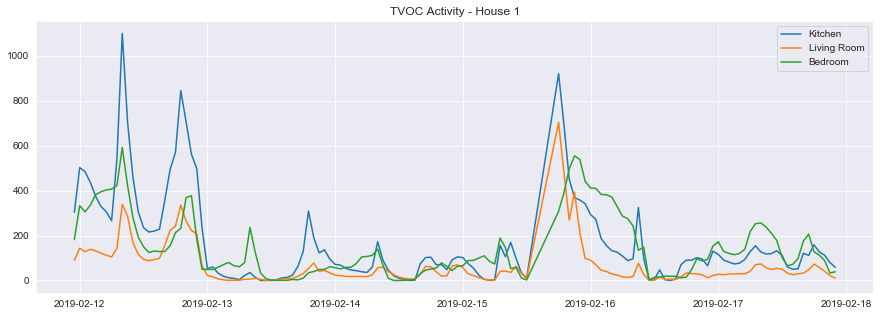

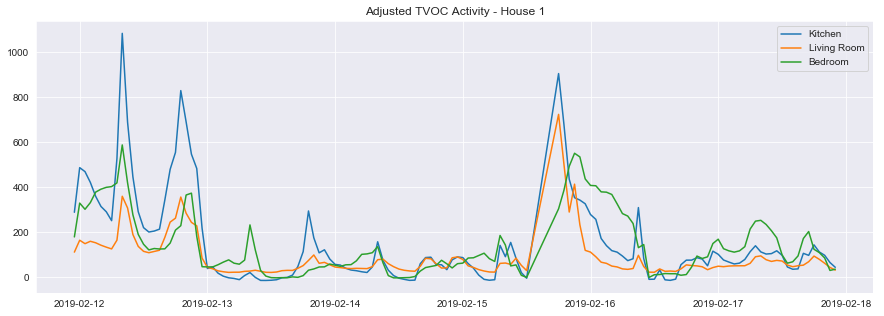

In [15]:
################################ H O U S E   1 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["TVOC"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["TVOC"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["TVOC"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("TVOC Activity - House 1")
plt.show()

KR1_Cal_TVOC_mean = Cal_KR["TVOC"][Cal_KR["House"]==2].mean()
LR1_Cal_TVOC_mean = Cal_LR["TVOC"][Cal_LR["House"]==2].mean()
BR1_Cal_TVOC_mean = Cal_BR["TVOC"][Cal_BR["House"]==2].mean()

H1_Cal_TVOC_mean = (KR1_Cal_TVOC_mean + LR1_Cal_TVOC_mean + BR1_Cal_TVOC_mean)/3

KR1_TVOC_adjustment = KR1_Cal_TVOC_mean - H1_Cal_TVOC_mean
LR1_TVOC_adjustment = LR1_Cal_TVOC_mean - H1_Cal_TVOC_mean
BR1_TVOC_adjustment = BR1_Cal_TVOC_mean - H1_Cal_TVOC_mean

IAQ_KR["adj_TVOC"] = IAQ_KR["TVOC"][IAQ_KR["House"]==2] - KR1_TVOC_adjustment
IAQ_LR["adj_TVOC"] = IAQ_LR["TVOC"][IAQ_LR["House"]==2] - LR1_TVOC_adjustment
IAQ_BR["adj_TVOC"] = IAQ_BR["TVOC"][IAQ_BR["House"]==2] - BR1_TVOC_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["adj_TVOC"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["adj_TVOC"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["adj_TVOC"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Adjusted TVOC Activity - House 1")
plt.show();

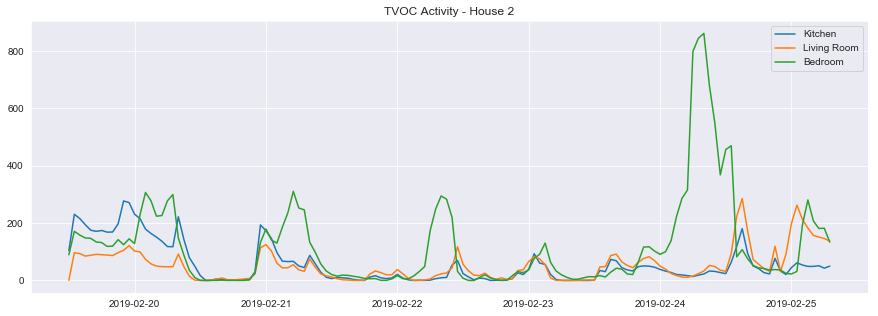

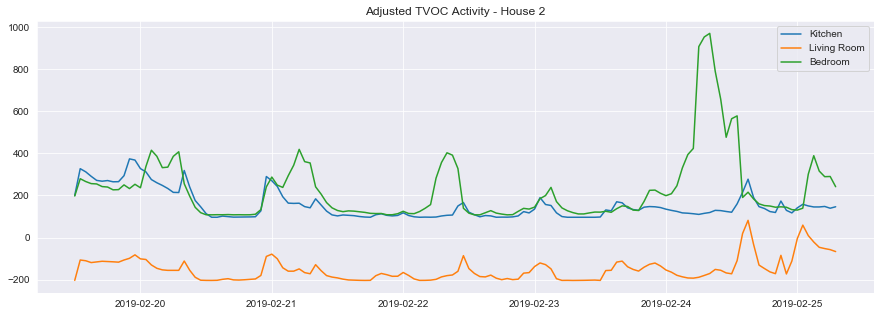

In [16]:
################################ H O U S E   2 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["TVOC"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["TVOC"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["TVOC"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("TVOC Activity - House 2")
plt.show()

KR2_Cal_TVOC_mean = Cal_KR["TVOC"][Cal_KR["House"]==3].mean()
LR2_Cal_TVOC_mean = Cal_LR["TVOC"][Cal_LR["House"]==3].mean()
BR2_Cal_TVOC_mean = Cal_BR["TVOC"][Cal_BR["House"]==3].mean()

H2_Cal_TVOC_mean = (KR2_Cal_TVOC_mean + LR2_Cal_TVOC_mean + BR2_Cal_TVOC_mean)/3

KR2_TVOC_adjustment = KR2_Cal_TVOC_mean - H2_Cal_TVOC_mean
LR2_TVOC_adjustment = LR2_Cal_TVOC_mean - H2_Cal_TVOC_mean
BR2_TVOC_adjustment = BR2_Cal_TVOC_mean - H2_Cal_TVOC_mean

IAQ_KR["adj_TVOC"][IAQ_KR["House"]==3] = IAQ_KR["TVOC"][IAQ_KR["House"]==3] - KR2_TVOC_adjustment
IAQ_LR["adj_TVOC"][IAQ_LR["House"]==3] = IAQ_LR["TVOC"][IAQ_LR["House"]==3] - LR2_TVOC_adjustment
IAQ_BR["adj_TVOC"][IAQ_BR["House"]==3] = IAQ_BR["TVOC"][IAQ_BR["House"]==3] - BR2_TVOC_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["adj_TVOC"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["adj_TVOC"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["adj_TVOC"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("Adjusted TVOC Activity - House 2")
plt.show();

Due to how big the discrepancy is between the Living Room sensor and all the others during House 2's calibration period, applying the same formula we've been using before puts this value into the negative spectrum. As both houses have an open plan Kitchen and the kitchen and living room sensors show a high level of accordance, we'll use the calibration data from the Kitchen for the living room sensor, pending a better idea.

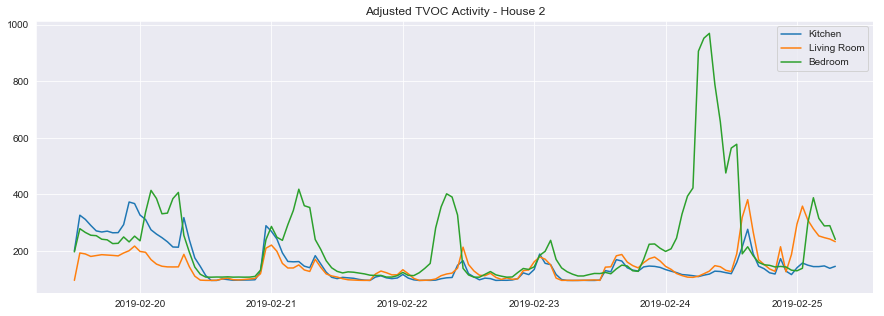

In [17]:
###############################################################################
####################### T V O C - A L T E R N A T I V E #######################
###############################################################################
################################ H O U S E   2 ################################
###############################################################################

#This is the line we've modified
LR2_TVOC_adjustment = KR2_Cal_TVOC_mean - H2_Cal_TVOC_mean

IAQ_LR["adj_TVOC"][IAQ_LR["House"]==3] = IAQ_LR["TVOC"][IAQ_LR["House"]==3] - LR2_TVOC_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["adj_TVOC"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["adj_TVOC"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["adj_TVOC"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("Adjusted TVOC Activity - House 2")
plt.show();

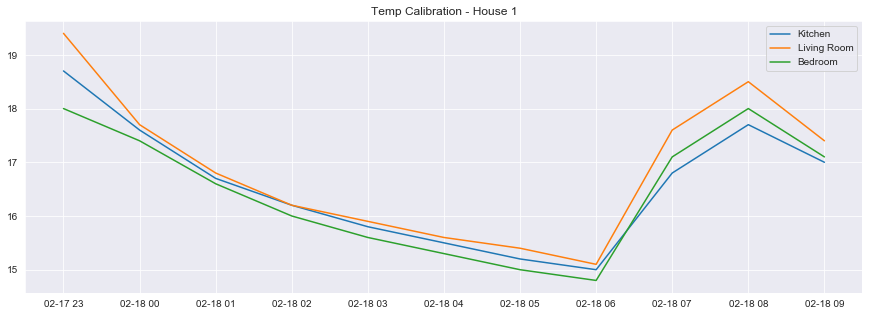

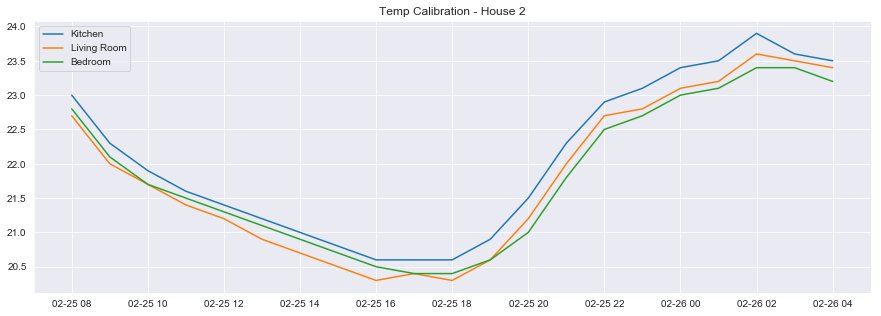

In [18]:
###############################################################################
############################ T E M P E R A T U R E ############################
###############################################################################

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["Temp"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["Temp"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["Temp"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Temp Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["Temp"][Cal_KR["House"] == 3], label='Kitchen')
plt.plot(Cal_LR["Temp"][Cal_LR["House"] == 3], label='Living Room')
plt.plot(Cal_BR["Temp"][Cal_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("Temp Calibration - House 2")
plt.show();

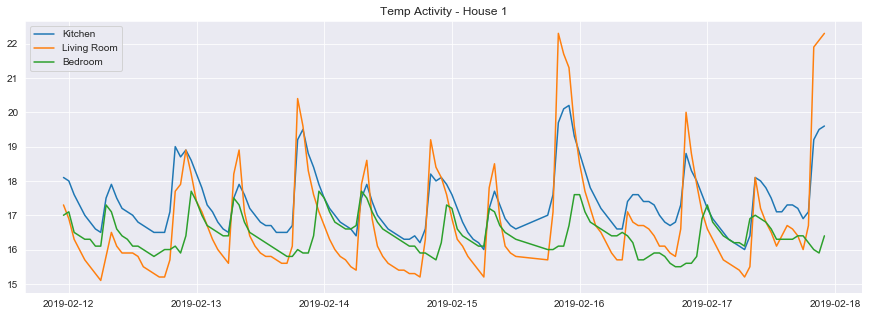

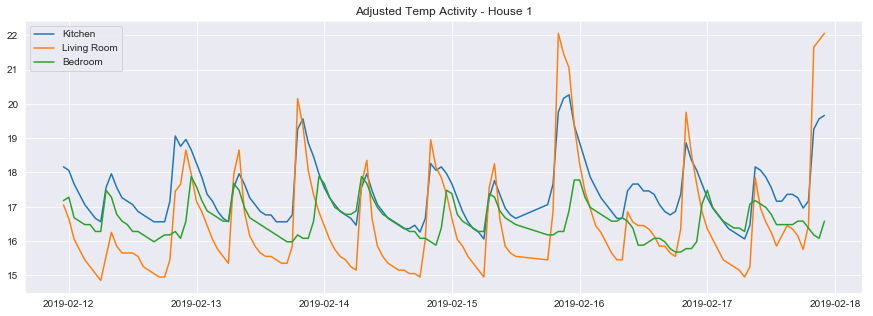

In [19]:
################################ H O U S E   1 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["Temp"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["Temp"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["Temp"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Temp Activity - House 1")
plt.show()

KR1_Cal_Temp_mean = Cal_KR["Temp"][Cal_KR["House"]==2].mean()
LR1_Cal_Temp_mean = Cal_LR["Temp"][Cal_LR["House"]==2].mean()
BR1_Cal_Temp_mean = Cal_BR["Temp"][Cal_BR["House"]==2].mean()

H1_Cal_Temp_mean = (KR1_Cal_Temp_mean + LR1_Cal_Temp_mean + BR1_Cal_Temp_mean)/3

KR1_Temp_adjustment = KR1_Cal_Temp_mean - H1_Cal_Temp_mean
LR1_Temp_adjustment = LR1_Cal_Temp_mean - H1_Cal_Temp_mean
BR1_Temp_adjustment = BR1_Cal_Temp_mean - H1_Cal_Temp_mean

IAQ_KR["Temp"][IAQ_KR["House"]==2] -= KR1_Temp_adjustment
IAQ_LR["Temp"][IAQ_LR["House"]==2] -= LR1_Temp_adjustment
IAQ_BR["Temp"][IAQ_BR["House"]==2] -= BR1_Temp_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["Temp"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["Temp"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["Temp"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Adjusted Temp Activity - House 1")
plt.show();

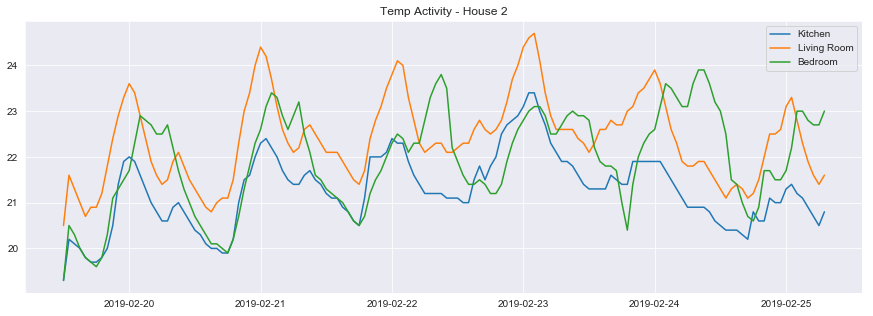

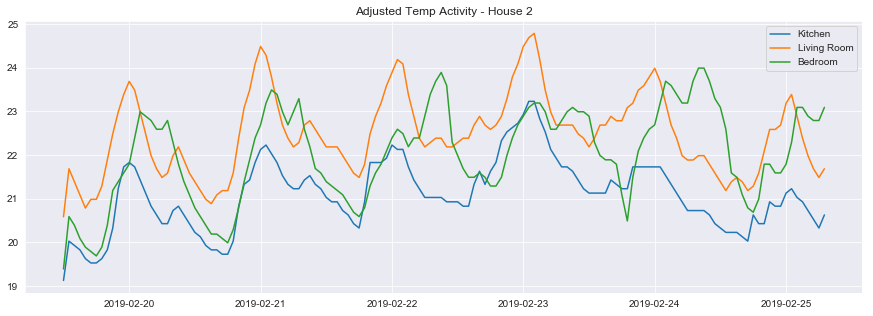

In [20]:
################################ H O U S E   2 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["Temp"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["Temp"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["Temp"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("Temp Activity - House 2")
plt.show()

KR2_Cal_Temp_mean = Cal_KR["Temp"][Cal_KR["House"]==3].mean()
LR2_Cal_Temp_mean = Cal_LR["Temp"][Cal_LR["House"]==3].mean()
BR2_Cal_Temp_mean = Cal_BR["Temp"][Cal_BR["House"]==3].mean()

H2_Cal_Temp_mean = (KR2_Cal_Temp_mean + LR2_Cal_Temp_mean + BR2_Cal_Temp_mean)/3

KR2_Temp_adjustment = KR2_Cal_Temp_mean - H2_Cal_Temp_mean
LR2_Temp_adjustment = LR2_Cal_Temp_mean - H2_Cal_Temp_mean
BR2_Temp_adjustment = BR2_Cal_Temp_mean - H2_Cal_Temp_mean

IAQ_KR["Temp"][IAQ_KR["House"]==3] -= KR2_Temp_adjustment
IAQ_LR["Temp"][IAQ_LR["House"]==3] -= LR2_Temp_adjustment
IAQ_BR["Temp"][IAQ_BR["House"]==3] -= BR2_Temp_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["Temp"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["Temp"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["Temp"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("Adjusted Temp Activity - House 2")
plt.show();

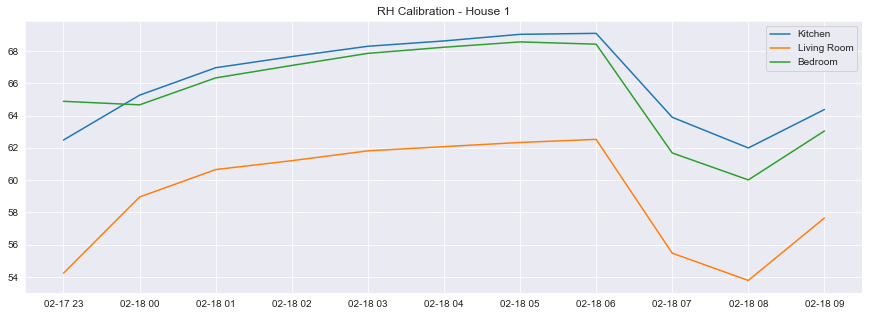

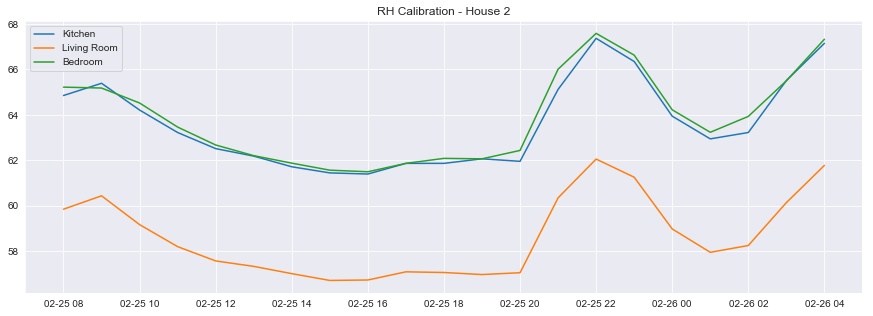

In [21]:
###############################################################################
###################### R E L A T I V E   H U M I D I T Y ######################
###############################################################################

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["RH"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["RH"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["RH"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("RH Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["RH"][Cal_KR["House"] == 3], label='Kitchen')
plt.plot(Cal_LR["RH"][Cal_LR["House"] == 3], label='Living Room')
plt.plot(Cal_BR["RH"][Cal_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("RH Calibration - House 2")
plt.show();

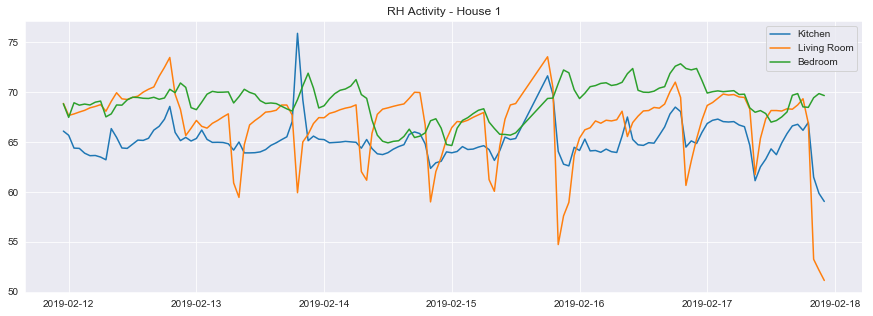

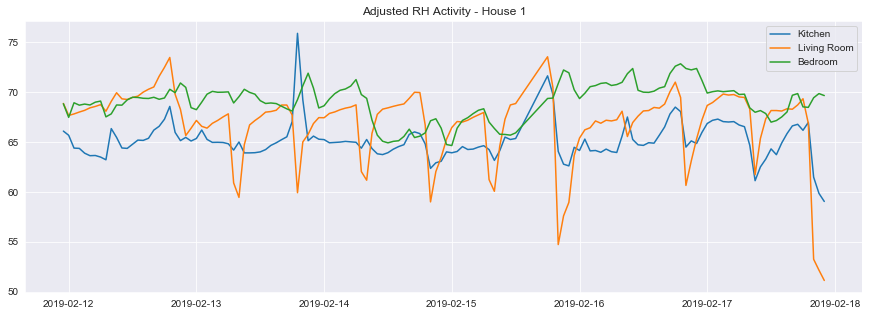

In [22]:
################################ H O U S E   1 ################################

KR1_Cal_RH_mean = Cal_KR["RH"][Cal_KR["House"]==2].mean()
LR1_Cal_RH_mean = Cal_LR["RH"][Cal_LR["House"]==2].mean()
BR1_Cal_RH_mean = Cal_BR["RH"][Cal_BR["House"]==2].mean()

H1_Cal_RH_mean = (KR1_Cal_RH_mean + LR1_Cal_RH_mean + BR1_Cal_RH_mean)/3

KR1_RH_adjustment = KR1_Cal_RH_mean - H1_Cal_RH_mean
LR1_RH_adjustment = LR1_Cal_RH_mean - H1_Cal_RH_mean
BR1_RH_adjustment = BR1_Cal_RH_mean - H1_Cal_RH_mean

IAQ_KR["RH"][IAQ_KR["House"]==2] -= KR1_RH_adjustment
IAQ_LR["RH"][IAQ_LR["House"]==2] -= LR1_RH_adjustment
IAQ_BR["RH"][IAQ_BR["House"]==2] -= BR1_RH_adjustment


plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["RH"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["RH"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["RH"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("RH Activity - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["RH"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["RH"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["RH"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Adjusted RH Activity - House 1")
plt.show();

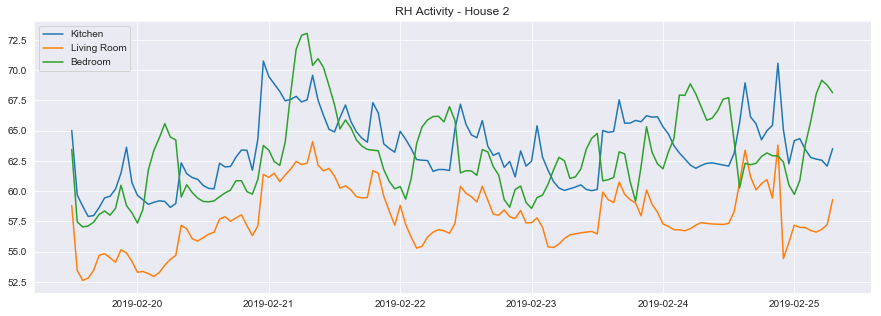

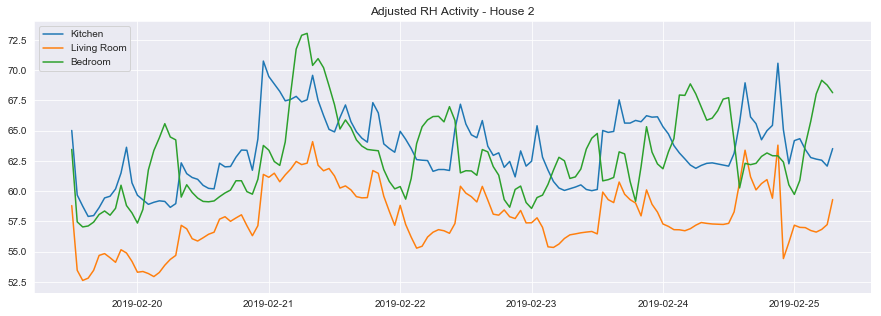

In [23]:
################################ H O U S E   2 ################################

KR2_Cal_RH_mean = Cal_KR["RH"][Cal_KR["House"]==3].mean()
LR2_Cal_RH_mean = Cal_LR["RH"][Cal_LR["House"]==3].mean()
BR2_Cal_RH_mean = Cal_BR["RH"][Cal_BR["House"]==3].mean()

H2_Cal_RH_mean = (KR2_Cal_RH_mean + LR2_Cal_RH_mean + BR2_Cal_RH_mean)/3

KR2_RH_adjustment = KR2_Cal_RH_mean - H2_Cal_RH_mean
LR2_RH_adjustment = LR2_Cal_RH_mean - H2_Cal_RH_mean
BR2_RH_adjustment = BR2_Cal_RH_mean - H2_Cal_RH_mean

IAQ_KR["RH"][IAQ_KR["House"]==3] -= KR2_RH_adjustment
IAQ_LR["RH"][IAQ_LR["House"]==3] -= LR2_RH_adjustment
IAQ_BR["RH"][IAQ_BR["House"]==3] -= BR2_RH_adjustment


plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["RH"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["RH"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["RH"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("RH Activity - House 2")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["RH"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["RH"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["RH"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("Adjusted RH Activity - House 2")
plt.show();

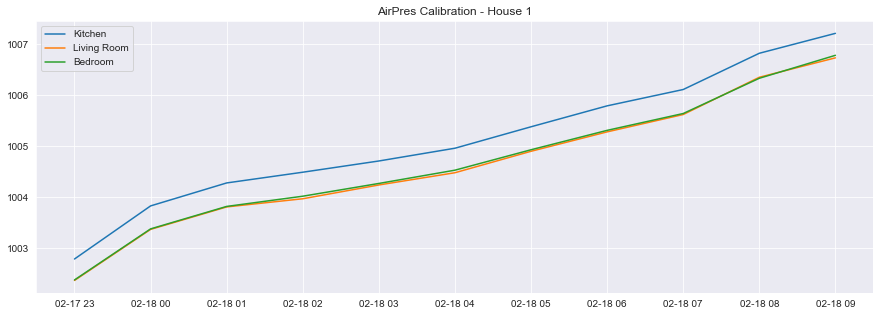

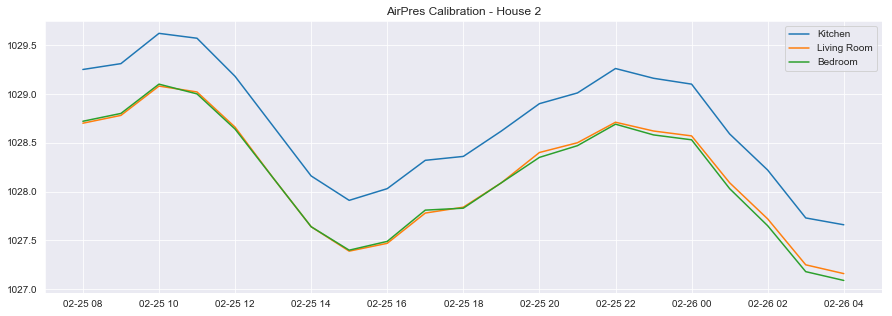

In [24]:
###############################################################################
########################### A I R   P R E S S U R E ###########################
###############################################################################

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["AirPres"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["AirPres"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["AirPres"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("AirPres Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["AirPres"][Cal_KR["House"] == 3], label='Kitchen')
plt.plot(Cal_LR["AirPres"][Cal_LR["House"] == 3], label='Living Room')
plt.plot(Cal_BR["AirPres"][Cal_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("AirPres Calibration - House 2")
plt.show();

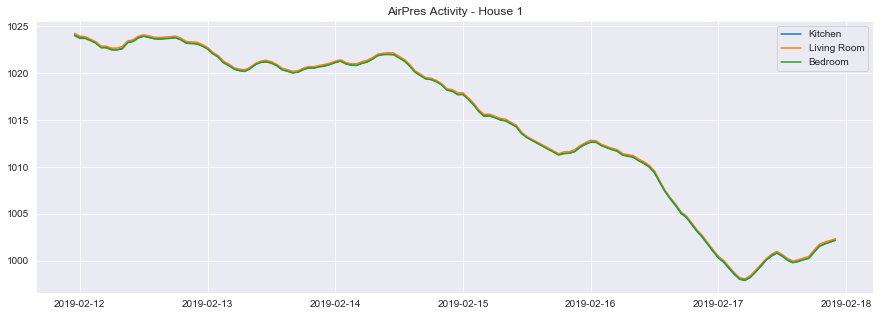

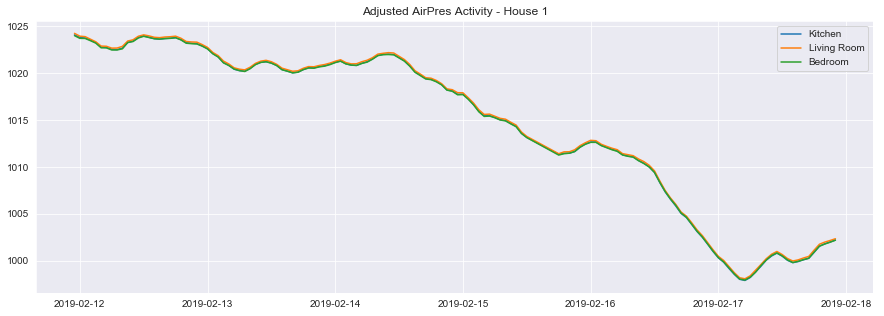

In [25]:
################################ H O U S E   1 ################################

KR1_Cal_AirPres_mean = Cal_KR["AirPres"][Cal_KR["House"]==2].mean()
LR1_Cal_AirPres_mean = Cal_LR["AirPres"][Cal_LR["House"]==2].mean()
BR1_Cal_AirPres_mean = Cal_BR["AirPres"][Cal_BR["House"]==2].mean()

H1_Cal_AirPres_mean = (KR1_Cal_AirPres_mean + LR1_Cal_AirPres_mean + BR1_Cal_AirPres_mean)/3

KR1_AirPres_adjustment = KR1_Cal_AirPres_mean - H1_Cal_AirPres_mean
LR1_AirPres_adjustment = LR1_Cal_AirPres_mean - H1_Cal_AirPres_mean
BR1_AirPres_adjustment = BR1_Cal_AirPres_mean - H1_Cal_AirPres_mean

IAQ_KR["AirPres"][IAQ_KR["House"]==2] -= KR1_AirPres_adjustment
IAQ_LR["AirPres"][IAQ_LR["House"]==2] -= LR1_AirPres_adjustment
IAQ_BR["AirPres"][IAQ_BR["House"]==2] -= BR1_AirPres_adjustment


plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["AirPres"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["AirPres"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["AirPres"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("AirPres Activity - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["AirPres"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["AirPres"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["AirPres"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Adjusted AirPres Activity - House 1")
plt.show();

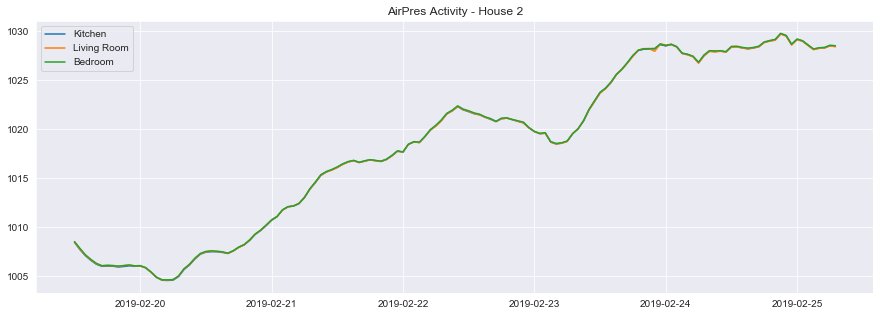

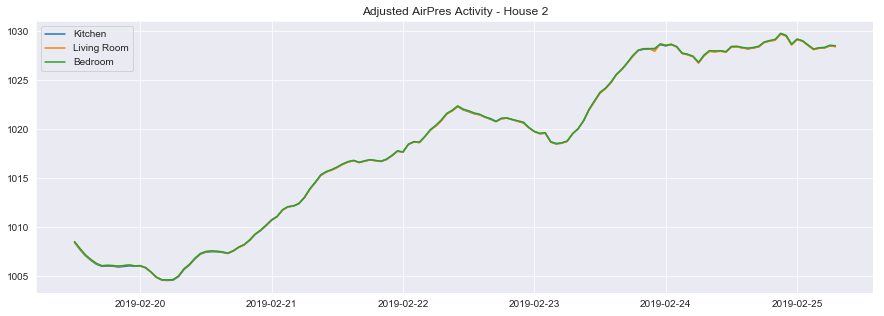

In [26]:
################################ H O U S E   2 ################################

KR2_Cal_AirPres_mean = Cal_KR["AirPres"][Cal_KR["House"]==3].mean()
LR2_Cal_AirPres_mean = Cal_LR["AirPres"][Cal_LR["House"]==3].mean()
BR2_Cal_AirPres_mean = Cal_BR["AirPres"][Cal_BR["House"]==3].mean()

H2_Cal_AirPres_mean = (KR2_Cal_AirPres_mean + LR2_Cal_AirPres_mean + BR2_Cal_AirPres_mean)/3

KR2_AirPres_adjustment = KR2_Cal_AirPres_mean - H2_Cal_AirPres_mean
LR2_AirPres_adjustment = LR2_Cal_AirPres_mean - H2_Cal_AirPres_mean
BR2_AirPres_adjustment = BR2_Cal_AirPres_mean - H2_Cal_AirPres_mean

IAQ_KR["AirPres"][IAQ_KR["House"]==3] -= KR2_AirPres_adjustment
IAQ_LR["AirPres"][IAQ_LR["House"]==3] -= LR2_AirPres_adjustment
IAQ_BR["AirPres"][IAQ_BR["House"]==3] -= BR2_AirPres_adjustment


plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["AirPres"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["AirPres"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["AirPres"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("AirPres Activity - House 2")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["AirPres"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["AirPres"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["AirPres"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("Adjusted AirPres Activity - House 2")
plt.show();

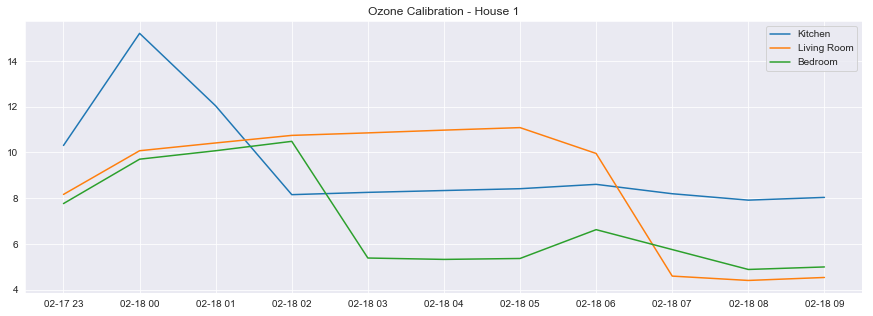

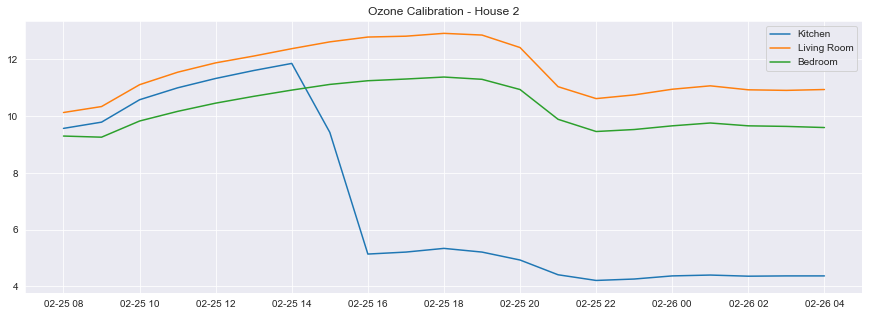

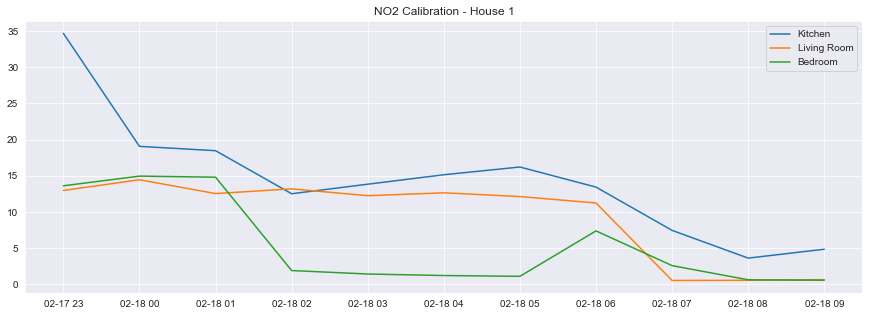

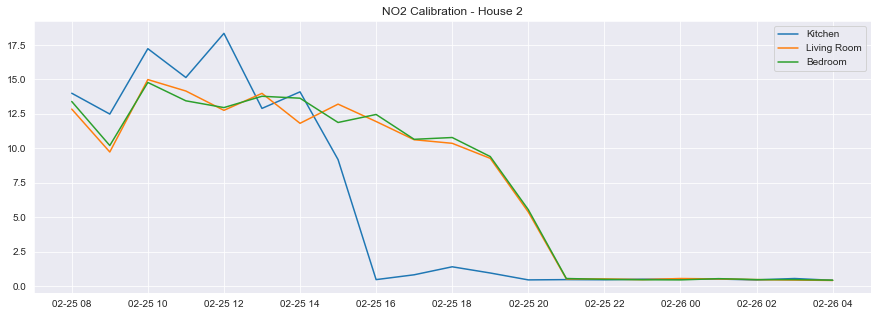

In [27]:
###############################################################################
############################ O Z O N E   &   N O 2 ############################
###############################################################################

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["Ozone"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["Ozone"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["Ozone"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Ozone Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["Ozone"][Cal_KR["House"] == 3], label='Kitchen')
plt.plot(Cal_LR["Ozone"][Cal_LR["House"] == 3], label='Living Room')
plt.plot(Cal_BR["Ozone"][Cal_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("Ozone Calibration - House 2")
plt.show();

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["NO2"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["NO2"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["NO2"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("NO2 Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["NO2"][Cal_KR["House"] == 3], label='Kitchen')
plt.plot(Cal_LR["NO2"][Cal_LR["House"] == 3], label='Living Room')
plt.plot(Cal_BR["NO2"][Cal_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("NO2 Calibration - House 2")
plt.show();

In [28]:
#We're excluding Ozone and NO2 from our model since we couldn't find any agreement in the calibration data
#Here we join the sensor data from our 3 rooms, Living Room, Kitchen and Bedroom with all activity available

IAQ_LR = IAQ_LR.drop('TVOC', axis=1).rename(columns={"adj_TVOC": "TVOC"}) 
IAQ_KR = IAQ_KR.drop('TVOC', axis=1).rename(columns={"adj_TVOC": "TVOC"}) 
IAQ_BR = IAQ_BR.drop('TVOC', axis=1).rename(columns={"adj_TVOC": "TVOC"}) 

LR = pd.merge(IAQ_LR, activity, left_index=True, right_index=True).drop(["NO2", "Ozone"], axis=1)
KR = pd.merge(IAQ_KR, activity, left_index=True, right_index=True).drop(["NO2", "Ozone"], axis=1)
BR = pd.merge(IAQ_BR, activity, left_index=True, right_index=True).drop(["NO2", "Ozone"], axis=1)

In [29]:
#Here we create datasets for each room in each house and one for both rooms together. We do this as House 2 has slightly more
#features available than House 1. The purpose of this split is to analyze which features are most impactful to PM2.5 and if
#these features are equally impactful in both houses or not.

LR1 = LR[LR["House"] == 2].dropna(axis=1)
LR2 = LR[LR["House"] == 3].dropna(axis=1)
LR = LR.dropna(axis=1)

KR1 = KR[KR["House"] == 2].dropna(axis=1)
KR2 = KR[KR["House"] == 3].dropna(axis=1)
KR = KR.dropna(axis=1)

BR1 = BR[BR["House"] == 2].dropna(axis=1)
BR2 = BR[BR["House"] == 3].dropna(axis=1)
BR = BR.dropna(axis=1)

print("LR1 shape:",LR1.shape)
print("LR2 shape,",LR2.shape)
print("LR shape:",LR.shape)
print("\n")
print("KR1 shape:",KR1.shape)
print("KR2 shape,",KR2.shape)
print("KR shape:",KR.shape)
print("\n")
print("BR1 shape:",BR1.shape)
print("BR2 shape,",BR2.shape)
print("BR shape:",BR.shape)



LR1 shape: (131, 32)
LR2 shape, (139, 36)
LR shape: (270, 32)


KR1 shape: (131, 32)
KR2 shape, (139, 36)
KR shape: (270, 32)


BR1 shape: (131, 32)
BR2 shape, (139, 36)
BR shape: (270, 32)


In [30]:
print (LR1.columns)
print (LR2.columns)
print("\n")
print("Features in House 2 unavailable in House 1: LR_OpenDoor, BR_OpenDoor, KR_OpenDoor and Shower")

Index(['Temp', 'RH', 'PM2.5', 'CO2', 'AirPres', 'House', 'TVOC',
       'LR_MaxOccupancy', 'LR_OpenWindow', 'LR_OpenCurtains', 'FireLit',
       'LR_HeatingOn', 'LR_Hoovering', 'LR_Mopping', 'KR_MaxOccupancy',
       'KR_OpenCurtains', 'Boiling', 'Frying', 'KR_HeatingOn', 'KR_Hoovering',
       'KR_Mopping', 'DishwasherOn', 'WashingMachineOn', 'Toaster',
       'BR_MaxOccupancy', 'BR_OpenWindows', 'BR_OpenCurtains', 'BR_HeatingOn',
       'BR_Hoovering', 'BR_Mopping', 'Hour', 'timeOfDay'],
      dtype='object')
Index(['Temp', 'RH', 'PM2.5', 'CO2', 'AirPres', 'House', 'TVOC',
       'LR_MaxOccupancy', 'LR_OpenWindow', 'LR_OpenDoor', 'LR_OpenCurtains',
       'FireLit', 'LR_HeatingOn', 'LR_Hoovering', 'LR_Mopping',
       'KR_MaxOccupancy', 'KR_OpenDoor', 'KR_OpenCurtains', 'Boiling',
       'Frying', 'KR_HeatingOn', 'KR_Hoovering', 'KR_Mopping', 'DishwasherOn',
       'WashingMachineOn', 'Toaster', 'BR_MaxOccupancy', 'BR_OpenWindows',
       'BR_OpenDoor', 'BR_OpenCurtains', 'BR_Heating

In [31]:
#Creating a DF for House 1 (H1), House 2 (H2) and both houses (H) with rooms one-hot encoded in case I need it for something.
df1_1 = LR1.copy()
df1_2 = KR1.copy()
df1_3 = BR1.copy()

df2_1 = LR2.copy()
df2_2 = KR2.copy()
df2_3 = BR2.copy()

df1_1["LivingRoom"] = 1
df1_1["Kitchen"] = 0
df1_1["Bedroom"] = 0

df1_2["LivingRoom"] = 0
df1_2["Kitchen"] = 1
df1_2["Bedroom"] = 0

df1_3["LivingRoom"] = 0
df1_3["Kitchen"] = 0
df1_3["Bedroom"] = 1

df2_1["LivingRoom"] = 1
df2_1["Kitchen"] = 0
df2_1["Bedroom"] = 0

df2_2["LivingRoom"] = 0
df2_2["Kitchen"] = 1
df2_2["Bedroom"] = 0

df2_3["LivingRoom"] = 0
df2_3["Kitchen"] = 0
df2_3["Bedroom"] = 1


H1 = pd.concat([df1_1, df1_2, df1_3], axis=0, sort=False)
H2 = pd.concat([df2_1, df2_2, df2_3], axis=0, sort=False)

H = pd.concat([H1, H2], axis=0, sort=False).dropna(axis=1)

print("H1 shape:",H1.shape)
print("H2 shape:",H2.shape)
print("H shape:",H.shape)

H1 shape: (393, 35)
H2 shape: (417, 39)
H shape: (810, 35)


# Questions needing answering so far:

1 - Is there a way to better use the calibration data on our activity?  
2 - Assuming the way the sensors were adjusted is acceptable, is there a better way to treat the TVOC data?

# Exploratory Data Analysis

## Goals of this section:

We're dealing with two similar layout houses. Both houses have the Kitchen joined with the Living room and then a bedroom too.

1 - Comparing means, standard deviations, mins and maximums between rooms in House 1 and 2; 6 comparisons.  
2 - Comparing means between Activities' 1s and 0s. A "1" represents "On/Open/Yes", such as Heating On, Door Open, Frying occurred.  
3 - We'll look into collinearity in this section as well as to prevent having a model with many features irrelevant to the change of PM2.5  
4 - Related to the mins/max comparison, we'll look at outliers and consult our activity logs to try and explain what could have happened there

### Brief talk on PM2.5

#### What is it?
PM2.5 refers to atmospheric particulate matter (PM) that have a diameter of less than 2.5 micrometers, which is about 3% the diameter of a human hair. They describe the mixture of solid particles and liquid droplets in the air.  It can be either human-made or naturally occurring.

#### Sources: 

Some examples include dust, ash and sea-spray. Particulate matter (including soot) is emitted during the combustion of solid and liquid fuels, such as for power generation, domestic heating and in vehicle engines. Studies (https://journals.sagepub.com/doi/pdf/10.1177/1420326X15604349) have shown that Indoor PM2.5 concentrations were dominated by outdoor sources in residential homes and public buildings where the I/O ratio was close to one or slightly higher than one. As such, when looking at our data, it's extremely important to know several external factors such as if the house is located near a road, within a city or in a more rural environment and so on.


For the purposes of our analysis, these are the property features for House 1 // House 2

Central heating - oil // gas  
Pump: Solar pump // none  
Electric heating: no // no  
BER rating - B3 // unknown  
Location - adjacent to town on country lane // right outside a busy crossroads in city centre  
Type: detached // flat  
Close neighbours: yes // yes  
Busy road close by: no // yes  
Solid fuel used for heating - wood // none  
Do neighbours burn solid fuel? - yes // no  
near farmyard - yes // no  
forested area: no // no  

Rooms:  

Kitchen  
Approximate size (in m2): 23.2 //  
Number of windows: 1 // 0  
Number of doors: 1 // 1  
Orientation: SE // NE  
Floor: tiles // wood  
Plants: yes // no  

Location of sensor (in m)  
Distance from door: 5.8  
Distance from window: 0.58  
Height above floor: 1.32  
Distance from wall: 0.22  


Living Room  
Approximate size (in m2): 22.8 //  
Number of windows: 2 // 2  
Number of doors: 2 // 1  
Orientation: SW // NW  
Floor: carpet // wood  
Plants: yes // no  

Location of sensor (in m)  
Distance from door: 6  
Distance from window: 6.5
Height above floor: 0.54
Distance from wall: 0.23


Bedroom  
Approximate size (in m2): 30.9 //  
Number of windows: 4 // 1  
Number of doors: 1 // 1  
Orientation: NW // SW  
Floor: carpet // wood  
Plants: no // no  

Location of sensor (in m)  
Distance from door: 3  
Distance from window: 6  
Height above floor: 0.8  
Distance from wall: 0.22

In [32]:
LR1_mean = round(LR1["PM2.5"].mean(),4)
LR1_std = round(LR1["PM2.5"].std(),4)
LR1_min = round(LR1["PM2.5"].min(),4)
LR1_max = round(LR1["PM2.5"].max(),4)

KR1_mean = round(KR1["PM2.5"].mean(),4)
KR1_std = round(KR1["PM2.5"].std(),4)
KR1_min = round(KR1["PM2.5"].min(),4)
KR1_max = round(KR1["PM2.5"].max(),4)

BR1_mean = round(BR1["PM2.5"].mean(),4)
BR1_std = round(BR1["PM2.5"].std(),4)
BR1_min = round(BR1["PM2.5"].min(),4)
BR1_max = round(BR1["PM2.5"].max(),4)

LR2_mean = round(LR2["PM2.5"].mean(),4)
LR2_std = round(LR2["PM2.5"].std(),4)
LR2_min = round(LR2["PM2.5"].min(),4)
LR2_max = round(LR2["PM2.5"].max(),4)

KR2_mean = round(KR2["PM2.5"].mean(),4)
KR2_std = round(KR2["PM2.5"].std(),4)
KR2_min = round(KR2["PM2.5"].min(),4)
KR2_max = round(KR2["PM2.5"].max(),4)

BR2_mean = round(BR2["PM2.5"].mean(),4)
BR2_std = round(BR2["PM2.5"].std(),4)
BR2_min = round(BR2["PM2.5"].min(),4)
BR2_max = round(BR2["PM2.5"].max(),4)


descriptives = {'Mean':[LR1_mean, KR1_mean, BR1_mean, LR2_mean, KR2_mean, BR2_mean], 
               'STD':[LR1_std, KR1_std, BR1_std, LR2_std, KR2_std, BR2_std],
               'Min':[LR1_min, KR1_min, BR1_min, LR2_min, KR2_min, BR2_min],
               'Max':[LR1_max, KR1_max, BR1_max, LR2_max, KR2_max, BR2_max],} 

descriptive_df = pd.DataFrame(descriptives, index =['LR1', 'KR1', 'BR1', 'LR2', 'KR2', 'BR2']) 

descriptive_df 

Mean      STD     Min       Max
LR1  15.4555  10.3329  4.9670   68.3370
KR1  15.3166  10.5639  6.4297   74.4497
BR1  12.7807   4.3725  6.4033   26.8333
LR2  19.7132  18.6067  4.9870  149.7770
KR2  15.4854  16.5718  5.5397  129.9497
BR2  16.0845  14.8640  6.2233  120.3733

In [33]:
LR1_corr_matrix=LR1.corr()["PM2.5"].drop(LR1.corr().index[2])
weak_features_list = LR1_corr_matrix[(abs(LR1_corr_matrix) >= 0.1) & (abs(LR1_corr_matrix) < 0.3)].sort_values(ascending=False)
moderate_features_list = LR1_corr_matrix[(abs(LR1_corr_matrix) >= 0.3) & (abs(LR1_corr_matrix) < 0.5)].sort_values(ascending=False)
strong_features_list = LR1_corr_matrix[abs(LR1_corr_matrix) >= 0.5].sort_values(ascending=False)

print("There are {} weakly (0.1 - 0.3) correlated values with PM2.5:\n{}".format(len(weak_features_list), weak_features_list))
print('\n')
print("There are {} moderately (0.3 - 0.5) correlated values with PM2.5:\n{}".format(len(moderate_features_list), moderate_features_list))
print('\n')
print("There are {} strongly (> 0.5) correlated values with PM2.5:\n{}".format(len(strong_features_list), strong_features_list))

There are 10 weakly (0.1 - 0.3) correlated values with PM2.5:
KR_Hoovering       0.290396
timeOfDay          0.279019
Hour               0.274988
LR_MaxOccupancy    0.244285
DishwasherOn       0.237873
KR_MaxOccupancy    0.218048
FireLit            0.209700
Temp               0.121360
BR_HeatingOn       0.100691
BR_MaxOccupancy   -0.263714
Name: PM2.5, dtype: float64


There are 3 moderately (0.3 - 0.5) correlated values with PM2.5:
TVOC      0.476416
CO2       0.431448
Frying    0.306363
Name: PM2.5, dtype: float64


There are 0 strongly (> 0.5) correlated values with PM2.5:
Series([], Name: PM2.5, dtype: float64)


In [34]:
KR1_corr_matrix=KR1.corr()["PM2.5"].drop(KR1.corr().index[2])
weak_features_list = KR1_corr_matrix[(abs(KR1_corr_matrix) >= 0.1) & (abs(KR1_corr_matrix) < 0.3)].sort_values(ascending=False)
moderate_features_list = KR1_corr_matrix[(abs(KR1_corr_matrix) >= 0.3) & (abs(KR1_corr_matrix) < 0.5)].sort_values(ascending=False)
strong_features_list = KR1_corr_matrix[abs(KR1_corr_matrix) >= 0.5].sort_values(ascending=False)

print("There are {} weakly (0.1 - 0.3) correlated values with PM2.5:\n{}".format(len(weak_features_list), weak_features_list))
print('\n')
print("There are {} moderately (0.3 - 0.5) correlated values with PM2.5:\n{}".format(len(moderate_features_list), moderate_features_list))
print('\n')
print("There are {} strongly (> 0.5) correlated values with PM2.5:\n{}".format(len(strong_features_list), strong_features_list))

There are 12 weakly (0.1 - 0.3) correlated values with PM2.5:
KR_MaxOccupancy    0.259873
KR_Hoovering       0.232173
timeOfDay          0.215073
Frying             0.207276
Hour               0.207186
DishwasherOn       0.191626
FireLit            0.185354
LR_MaxOccupancy    0.137453
Temp               0.134449
LR_OpenCurtains    0.118261
BR_OpenCurtains    0.113778
BR_MaxOccupancy   -0.229278
Name: PM2.5, dtype: float64


There are 3 moderately (0.3 - 0.5) correlated values with PM2.5:
TVOC    0.496124
CO2     0.404046
RH      0.330346
Name: PM2.5, dtype: float64


There are 0 strongly (> 0.5) correlated values with PM2.5:
Series([], Name: PM2.5, dtype: float64)


In [35]:
BR1_corr_matrix=BR1.corr()["PM2.5"].drop(BR1.corr().index[2])
weak_features_list = BR1_corr_matrix[(abs(BR1_corr_matrix) >= 0.1) & (abs(BR1_corr_matrix) < 0.3)].sort_values(ascending=False)
moderate_features_list = BR1_corr_matrix[(abs(BR1_corr_matrix) >= 0.3) & (abs(BR1_corr_matrix) < 0.5)].sort_values(ascending=False)
strong_features_list = BR1_corr_matrix[abs(BR1_corr_matrix) >= 0.5].sort_values(ascending=False)

print("There are {} weakly (0.1 - 0.3) correlated values with PM2.5:\n{}".format(len(weak_features_list), weak_features_list))
print('\n')
print("There are {} moderately (0.3 - 0.5) correlated values with PM2.5:\n{}".format(len(moderate_features_list), moderate_features_list))
print('\n')
print("There are {} strongly (> 0.5) correlated values with PM2.5:\n{}".format(len(strong_features_list), strong_features_list))

There are 15 weakly (0.1 - 0.3) correlated values with PM2.5:
timeOfDay          0.296384
Hour               0.286277
BR_OpenCurtains    0.277754
BR_OpenWindows     0.252020
KR_OpenCurtains    0.244495
LR_OpenCurtains    0.209429
Frying             0.181454
LR_OpenWindow      0.179030
FireLit            0.149342
RH                 0.121302
LR_MaxOccupancy    0.114603
KR_HeatingOn       0.103266
BR_HeatingOn      -0.113050
Temp              -0.187793
CO2               -0.276701
Name: PM2.5, dtype: float64


There are 2 moderately (0.3 - 0.5) correlated values with PM2.5:
KR_MaxOccupancy    0.381662
BR_MaxOccupancy   -0.382961
Name: PM2.5, dtype: float64


There are 0 strongly (> 0.5) correlated values with PM2.5:
Series([], Name: PM2.5, dtype: float64)


In [36]:
LR2_corr_matrix=LR2.corr()["PM2.5"].drop(LR2.corr().index[2])
weak_features_list = LR2_corr_matrix[(abs(LR2_corr_matrix) >= 0.1) & (abs(LR2_corr_matrix) < 0.3)].sort_values(ascending=False)
moderate_features_list = LR2_corr_matrix[(abs(LR2_corr_matrix) >= 0.3) & (abs(LR2_corr_matrix) < 0.5)].sort_values(ascending=False)
strong_features_list = LR2_corr_matrix[abs(LR2_corr_matrix) >= 0.5].sort_values(ascending=False)

print("There are {} weakly (0.1 - 0.3) correlated values with PM2.5:\n{}".format(len(weak_features_list), weak_features_list))
print('\n')
print("There are {} moderately (0.3 - 0.5) correlated values with PM2.5:\n{}".format(len(moderate_features_list), moderate_features_list))
print('\n')
print("There are {} strongly (> 0.5) correlated values with PM2.5:\n{}".format(len(strong_features_list), strong_features_list))

There are 14 weakly (0.1 - 0.3) correlated values with PM2.5:
AirPres            0.235748
LR_OpenWindow      0.223809
BR_Mopping         0.220228
BR_OpenWindows     0.220228
LR_MaxOccupancy    0.207811
RH                 0.185029
LR_OpenCurtains    0.162306
BR_OpenDoor        0.159943
KR_MaxOccupancy    0.146923
CO2                0.116381
Hour               0.109809
LR_OpenDoor       -0.110932
BR_MaxOccupancy   -0.176497
KR_OpenDoor       -0.207328
Name: PM2.5, dtype: float64


There are 4 moderately (0.3 - 0.5) correlated values with PM2.5:
Boiling         0.435105
BR_Hoovering    0.389105
Temp            0.341418
Frying          0.332569
Name: PM2.5, dtype: float64


There are 0 strongly (> 0.5) correlated values with PM2.5:
Series([], Name: PM2.5, dtype: float64)


In [37]:
KR2_corr_matrix=KR2.corr()["PM2.5"].drop(KR2.corr().index[2])
weak_features_list = KR2_corr_matrix[(abs(KR2_corr_matrix) >= 0.1) & (abs(KR2_corr_matrix) < 0.3)].sort_values(ascending=False)
moderate_features_list = KR2_corr_matrix[(abs(KR2_corr_matrix) >= 0.3) & (abs(KR2_corr_matrix) < 0.5)].sort_values(ascending=False)
strong_features_list = KR2_corr_matrix[abs(KR2_corr_matrix) >= 0.5].sort_values(ascending=False)

print("There are {} weakly (0.1 - 0.3) correlated values with PM2.5:\n{}".format(len(weak_features_list), weak_features_list))
print('\n')
print("There are {} moderately (0.3 - 0.5) correlated values with PM2.5:\n{}".format(len(moderate_features_list), moderate_features_list))
print('\n')
print("There are {} strongly (> 0.5) correlated values with PM2.5:\n{}".format(len(strong_features_list), strong_features_list))

There are 13 weakly (0.1 - 0.3) correlated values with PM2.5:
RH                 0.288940
Temp               0.286600
AirPres            0.219822
BR_Mopping         0.218197
BR_OpenWindows     0.218197
KR_MaxOccupancy    0.204752
LR_MaxOccupancy    0.199862
LR_OpenWindow      0.184739
BR_OpenDoor        0.175541
DishwasherOn       0.163354
LR_OpenCurtains    0.134288
KR_OpenDoor       -0.170643
BR_MaxOccupancy   -0.179938
Name: PM2.5, dtype: float64


There are 3 moderately (0.3 - 0.5) correlated values with PM2.5:
BR_Hoovering    0.463077
Frying          0.449327
Boiling         0.427584
Name: PM2.5, dtype: float64


There are 0 strongly (> 0.5) correlated values with PM2.5:
Series([], Name: PM2.5, dtype: float64)


In [38]:
BR2_corr_matrix=BR2.corr()["PM2.5"].drop(BR2.corr().index[2])
weak_features_list = BR2_corr_matrix[(abs(BR2_corr_matrix) >= 0.1) & (abs(BR2_corr_matrix) < 0.3)].sort_values(ascending=False)
moderate_features_list = BR2_corr_matrix[(abs(BR2_corr_matrix) >= 0.3) & (abs(BR2_corr_matrix) < 0.5)].sort_values(ascending=False)
strong_features_list = BR2_corr_matrix[abs(BR2_corr_matrix) >= 0.5].sort_values(ascending=False)

print("There are {} weakly (0.1 - 0.3) correlated values with PM2.5:\n{}".format(len(weak_features_list), weak_features_list))
print('\n')
print("There are {} moderately (0.3 - 0.5) correlated values with PM2.5:\n{}".format(len(moderate_features_list), moderate_features_list))
print('\n')
print("There are {} strongly (> 0.5) correlated values with PM2.5:\n{}".format(len(strong_features_list), strong_features_list))

There are 9 weakly (0.1 - 0.3) correlated values with PM2.5:
BR_Mopping         0.250362
BR_OpenWindows     0.250362
AirPres            0.196107
KR_MaxOccupancy    0.160578
LR_MaxOccupancy    0.114442
BR_MaxOccupancy   -0.114560
KR_OpenDoor       -0.130272
TVOC              -0.184195
CO2               -0.188795
Name: PM2.5, dtype: float64


There are 3 moderately (0.3 - 0.5) correlated values with PM2.5:
Boiling         0.408301
BR_Hoovering    0.367212
Frying          0.316946
Name: PM2.5, dtype: float64


There are 0 strongly (> 0.5) correlated values with PM2.5:
Series([], Name: PM2.5, dtype: float64)


In [39]:
LR_corr_matrix=LR.corr()["PM2.5"].drop(LR.corr().index[2])
weak_features_list = LR_corr_matrix[(abs(LR_corr_matrix) >= 0.1) & (abs(LR_corr_matrix) < 0.3)].sort_values(ascending=False)
moderate_features_list = LR_corr_matrix[(abs(LR_corr_matrix) >= 0.3) & (abs(LR_corr_matrix) < 0.5)].sort_values(ascending=False)
strong_features_list = LR_corr_matrix[abs(LR_corr_matrix) >= 0.5].sort_values(ascending=False)

print("There are {} weakly (0.1 - 0.3) correlated values with PM2.5:\n{}".format(len(weak_features_list), weak_features_list))
print('\n')
print("There are {} moderately (0.3 - 0.5) correlated values with PM2.5:\n{}".format(len(moderate_features_list), moderate_features_list))
print('\n')
print("There are {} strongly (> 0.5) correlated values with PM2.5:\n{}".format(len(strong_features_list), strong_features_list))

There are 13 weakly (0.1 - 0.3) correlated values with PM2.5:
TVOC               0.251754
CO2                0.232734
LR_MaxOccupancy    0.213798
Boiling            0.211851
Temp               0.207284
BR_Mopping         0.199884
AirPres            0.196782
Hour               0.156514
timeOfDay          0.141007
House              0.139439
DishwasherOn       0.131174
KR_Hoovering       0.101479
BR_MaxOccupancy   -0.184122
Name: PM2.5, dtype: float64


There are 2 moderately (0.3 - 0.5) correlated values with PM2.5:
BR_Hoovering    0.346832
Frying          0.318649
Name: PM2.5, dtype: float64


There are 0 strongly (> 0.5) correlated values with PM2.5:
Series([], Name: PM2.5, dtype: float64)


In [40]:
KR_corr_matrix=KR.corr()["PM2.5"].drop(KR.corr().index[2])
weak_features_list = KR_corr_matrix[(abs(KR_corr_matrix) >= 0.1) & (abs(KR_corr_matrix) < 0.3)].sort_values(ascending=False)
moderate_features_list = KR_corr_matrix[(abs(KR_corr_matrix) >= 0.3) & (abs(KR_corr_matrix) < 0.5)].sort_values(ascending=False)
strong_features_list = KR_corr_matrix[abs(KR_corr_matrix) >= 0.5].sort_values(ascending=False)

print("There are {} weakly (0.1 - 0.3) correlated values with PM2.5:\n{}".format(len(weak_features_list), weak_features_list))
print('\n')
print("There are {} moderately (0.3 - 0.5) correlated values with PM2.5:\n{}".format(len(moderate_features_list), moderate_features_list))
print('\n')
print("There are {} strongly (> 0.5) correlated values with PM2.5:\n{}".format(len(strong_features_list), strong_features_list))

There are 13 weakly (0.1 - 0.3) correlated values with PM2.5:
RH                 0.280912
TVOC               0.235799
Boiling            0.203074
BR_Mopping         0.185583
KR_MaxOccupancy    0.167299
DishwasherOn       0.164477
AirPres            0.156758
LR_MaxOccupancy    0.153935
CO2                0.151712
Hour               0.136222
timeOfDay          0.126717
KR_Hoovering       0.107955
BR_MaxOccupancy   -0.192556
Name: PM2.5, dtype: float64


There are 2 moderately (0.3 - 0.5) correlated values with PM2.5:
BR_Hoovering    0.393458
Frying          0.364738
Name: PM2.5, dtype: float64


There are 0 strongly (> 0.5) correlated values with PM2.5:
Series([], Name: PM2.5, dtype: float64)


In [41]:
BR_corr_matrix=BR.corr()["PM2.5"].drop(BR.corr().index[2])
weak_features_list = BR_corr_matrix[(abs(BR_corr_matrix) >= 0.1) & (abs(BR_corr_matrix) < 0.3)].sort_values(ascending=False)
moderate_features_list = BR_corr_matrix[(abs(BR_corr_matrix) >= 0.3) & (abs(BR_corr_matrix) < 0.5)].sort_values(ascending=False)
strong_features_list = BR_corr_matrix[abs(BR_corr_matrix) >= 0.5].sort_values(ascending=False)

print("There are {} weakly (0.1 - 0.3) correlated values with PM2.5:\n{}".format(len(weak_features_list), weak_features_list))
print('\n')
print("There are {} moderately (0.3 - 0.5) correlated values with PM2.5:\n{}".format(len(moderate_features_list), moderate_features_list))
print('\n')
print("There are {} strongly (> 0.5) correlated values with PM2.5:\n{}".format(len(strong_features_list), strong_features_list))

There are 9 weakly (0.1 - 0.3) correlated values with PM2.5:
Frying             0.267788
BR_Mopping         0.246428
Boiling            0.218887
AirPres            0.164164
House              0.147771
Temp               0.144778
BR_OpenWindows     0.144386
LR_MaxOccupancy    0.106326
BR_MaxOccupancy   -0.137535
Name: PM2.5, dtype: float64


There are 1 moderately (0.3 - 0.5) correlated values with PM2.5:
BR_Hoovering    0.35736
Name: PM2.5, dtype: float64


There are 0 strongly (> 0.5) correlated values with PM2.5:
Series([], Name: PM2.5, dtype: float64)


In [42]:
H1_corr_matrix=H1.corr()["PM2.5"].drop(H1.corr().index[2])
weak_features_list = H1_corr_matrix[(abs(H1_corr_matrix) >= 0.1) & (abs(H1_corr_matrix) < 0.3)].sort_values(ascending=False)
moderate_features_list = H1_corr_matrix[(abs(H1_corr_matrix) >= 0.3) & (abs(H1_corr_matrix) < 0.5)].sort_values(ascending=False)
strong_features_list = H1_corr_matrix[abs(H1_corr_matrix) >= 0.5].sort_values(ascending=False)

print("There are {} weakly (0.1 - 0.3) correlated values with PM2.5:\n{}".format(len(weak_features_list), weak_features_list))
print('\n')
print("There are {} moderately (0.3 - 0.5) correlated values with PM2.5:\n{}".format(len(moderate_features_list), moderate_features_list))
print('\n')
print("There are {} strongly (> 0.5) correlated values with PM2.5:\n{}".format(len(strong_features_list), strong_features_list))

There are 14 weakly (0.1 - 0.3) correlated values with PM2.5:
KR_MaxOccupancy    0.247415
timeOfDay          0.239394
Hour               0.233116
Frying             0.228173
KR_Hoovering       0.214231
CO2                0.199561
FireLit            0.177304
LR_MaxOccupancy    0.166151
DishwasherOn       0.164127
BR_OpenCurtains    0.128006
LR_OpenCurtains    0.118136
Temp               0.109944
Bedroom           -0.137257
BR_MaxOccupancy   -0.253142
Name: PM2.5, dtype: float64


There are 1 moderately (0.3 - 0.5) correlated values with PM2.5:
TVOC    0.36044
Name: PM2.5, dtype: float64


There are 0 strongly (> 0.5) correlated values with PM2.5:
Series([], Name: PM2.5, dtype: float64)


In [43]:
H2_corr_matrix=H2.corr()["PM2.5"].drop(H2.corr().index[2])
weak_features_list = H2_corr_matrix[(abs(H2_corr_matrix) >= 0.1) & (abs(H2_corr_matrix) < 0.3)].sort_values(ascending=False)
moderate_features_list = H2_corr_matrix[(abs(H2_corr_matrix) >= 0.3) & (abs(H2_corr_matrix) < 0.5)].sort_values(ascending=False)
strong_features_list = H2_corr_matrix[abs(H2_corr_matrix) >= 0.5].sort_values(ascending=False)

print("There are {} weakly (0.1 - 0.3) correlated values with PM2.5:\n{}".format(len(weak_features_list), weak_features_list))
print('\n')
print("There are {} moderately (0.3 - 0.5) correlated values with PM2.5:\n{}".format(len(moderate_features_list), moderate_features_list))
print('\n')
print("There are {} strongly (> 0.5) correlated values with PM2.5:\n{}".format(len(strong_features_list), strong_features_list))

There are 13 weakly (0.1 - 0.3) correlated values with PM2.5:
Temp               0.232464
BR_Mopping         0.226139
BR_OpenWindows     0.226139
AirPres            0.216311
LR_MaxOccupancy    0.175607
KR_MaxOccupancy    0.168367
BR_OpenDoor        0.140402
LR_OpenWindow      0.137574
DishwasherOn       0.112951
LivingRoom         0.110262
LR_OpenCurtains    0.103285
BR_MaxOccupancy   -0.157590
KR_OpenDoor       -0.170507
Name: PM2.5, dtype: float64


There are 3 moderately (0.3 - 0.5) correlated values with PM2.5:
Boiling         0.420254
BR_Hoovering    0.402882
Frying          0.362797
Name: PM2.5, dtype: float64


There are 0 strongly (> 0.5) correlated values with PM2.5:
Series([], Name: PM2.5, dtype: float64)


In [44]:
H_corr_matrix=H1.corr()["PM2.5"].drop(H.corr().index[2])
weak_features_list = H_corr_matrix[(abs(H_corr_matrix) >= 0.1) & (abs(H_corr_matrix) < 0.3)].sort_values(ascending=False)
moderate_features_list = H_corr_matrix[(abs(H_corr_matrix) >= 0.3) & (abs(H_corr_matrix) < 0.5)].sort_values(ascending=False)
strong_features_list = H_corr_matrix[abs(H_corr_matrix) >= 0.5].sort_values(ascending=False)

print("There are {} weakly (0.1 - 0.3) correlated values with PM2.5:\n{}".format(len(weak_features_list), weak_features_list))
print('\n')
print("There are {} moderately (0.3 - 0.5) correlated values with PM2.5:\n{}".format(len(moderate_features_list), moderate_features_list))
print('\n')
print("There are {} strongly (> 0.5) correlated values with PM2.5:\n{}".format(len(strong_features_list), strong_features_list))

There are 14 weakly (0.1 - 0.3) correlated values with PM2.5:
KR_MaxOccupancy    0.247415
timeOfDay          0.239394
Hour               0.233116
Frying             0.228173
KR_Hoovering       0.214231
CO2                0.199561
FireLit            0.177304
LR_MaxOccupancy    0.166151
DishwasherOn       0.164127
BR_OpenCurtains    0.128006
LR_OpenCurtains    0.118136
Temp               0.109944
Bedroom           -0.137257
BR_MaxOccupancy   -0.253142
Name: PM2.5, dtype: float64


There are 1 moderately (0.3 - 0.5) correlated values with PM2.5:
TVOC    0.36044
Name: PM2.5, dtype: float64


There are 0 strongly (> 0.5) correlated values with PM2.5:
Series([], Name: PM2.5, dtype: float64)


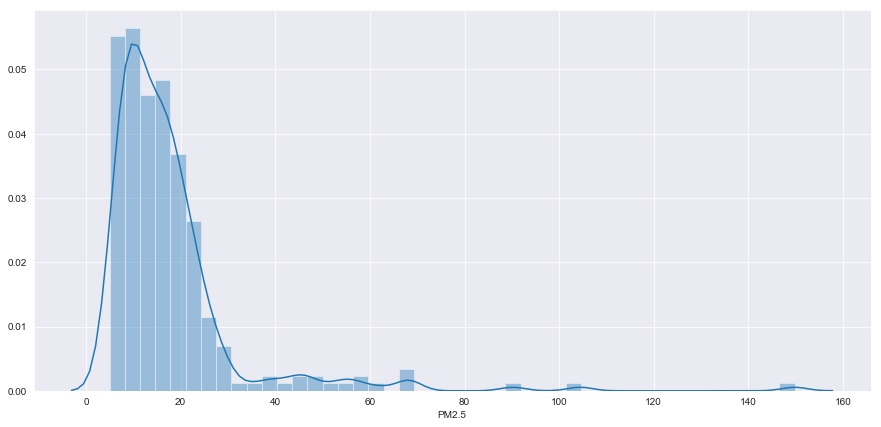

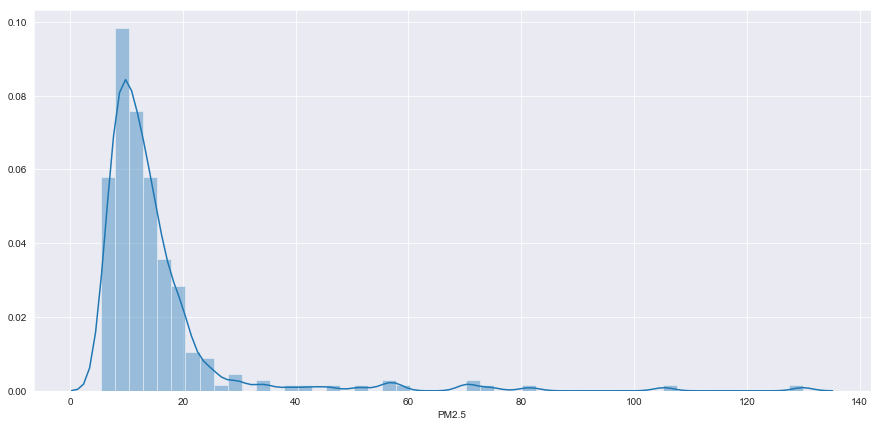

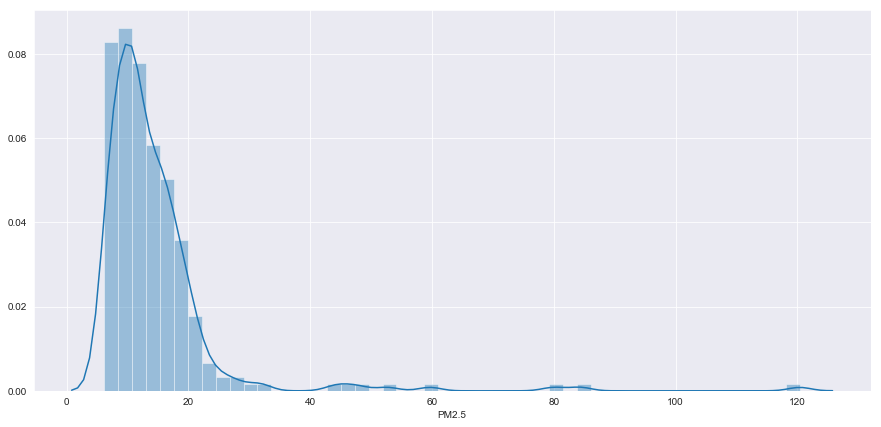

In [45]:
plt.figure(figsize=(15,7))
sns.distplot(LR["PM2.5"])
plt.show()

plt.figure(figsize=(15,7))
sns.distplot(KR["PM2.5"])
plt.show()

plt.figure(figsize=(15,7))
sns.distplot(BR["PM2.5"])
plt.show()

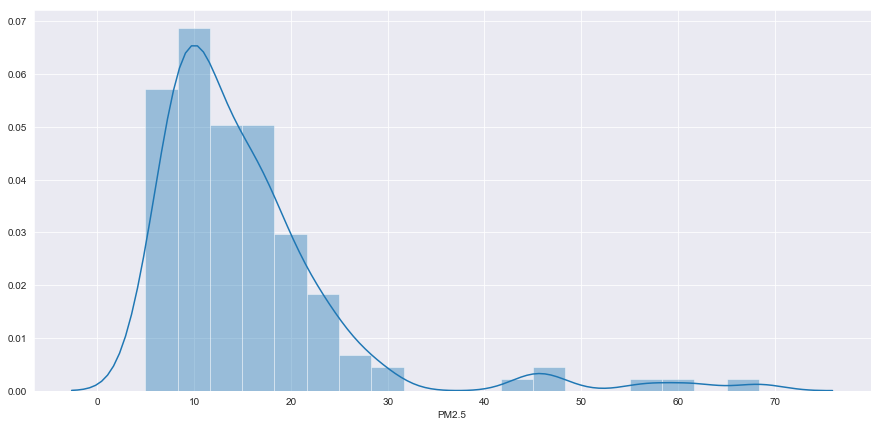

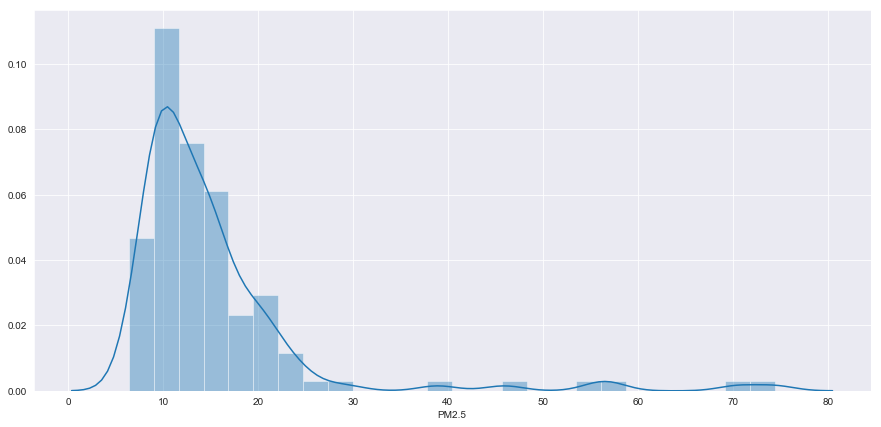

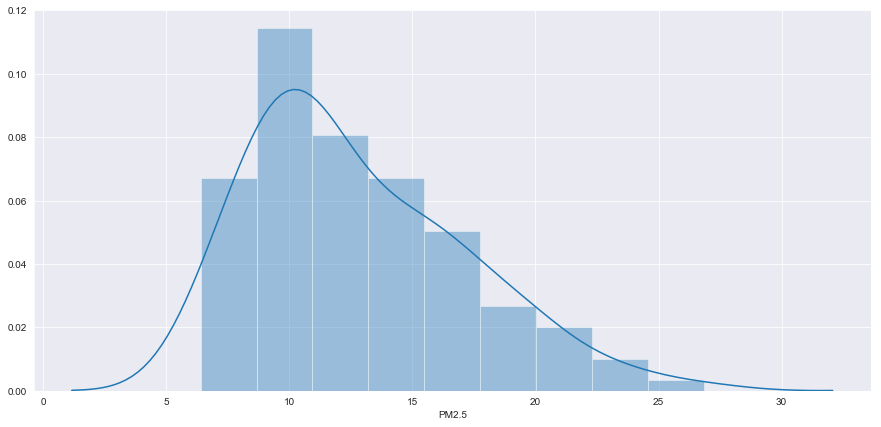

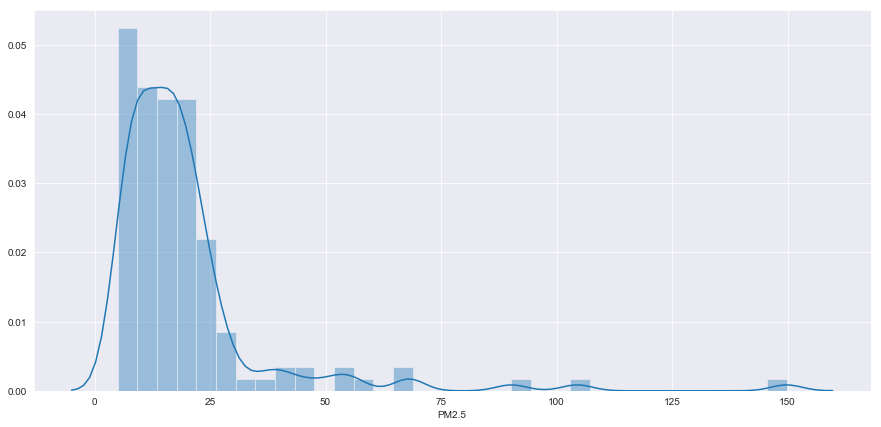

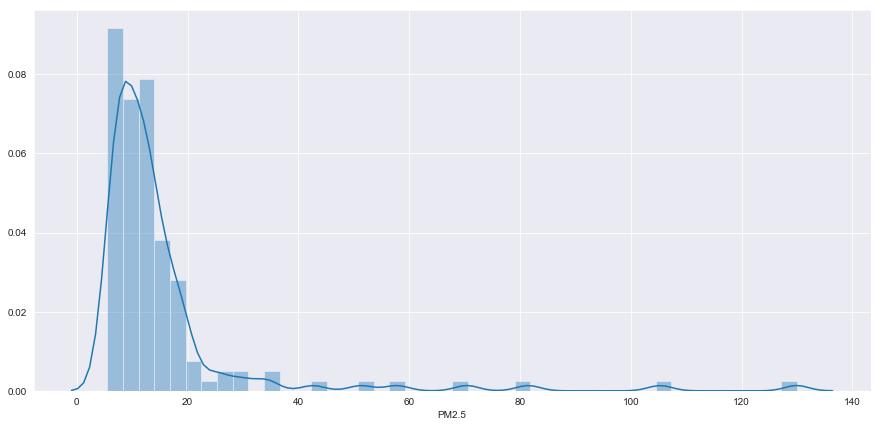

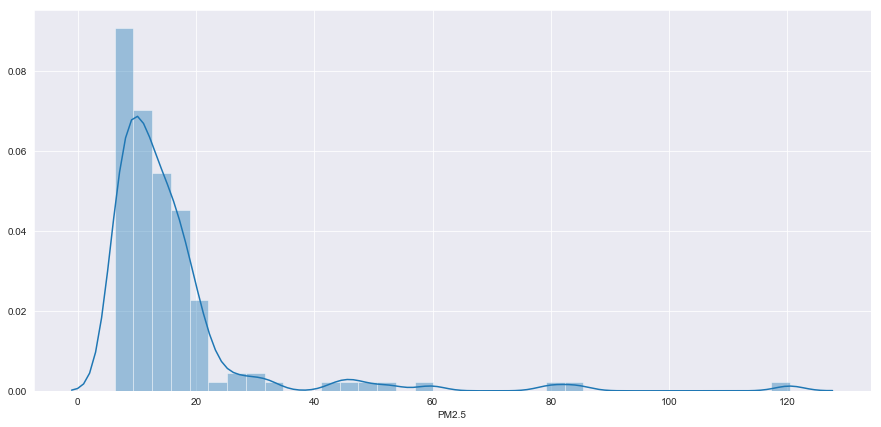

In [46]:
plt.figure(figsize=(15,7))
sns.set_style('darkgrid')
sns.distplot(LR1["PM2.5"])
plt.show()

plt.figure(figsize=(15,7))
sns.set_style('darkgrid')
sns.distplot(KR1["PM2.5"])
plt.show()

plt.figure(figsize=(15,7))
sns.set_style('darkgrid')
sns.distplot(BR1["PM2.5"])
plt.show()

plt.figure(figsize=(15,7))
sns.set_style('darkgrid')
sns.distplot(LR2["PM2.5"])
plt.show()

plt.figure(figsize=(15,7))
sns.set_style('darkgrid')
sns.distplot(KR2["PM2.5"])
plt.show()

plt.figure(figsize=(15,7))
sns.set_style('darkgrid')
sns.distplot(BR2["PM2.5"])
plt.show()

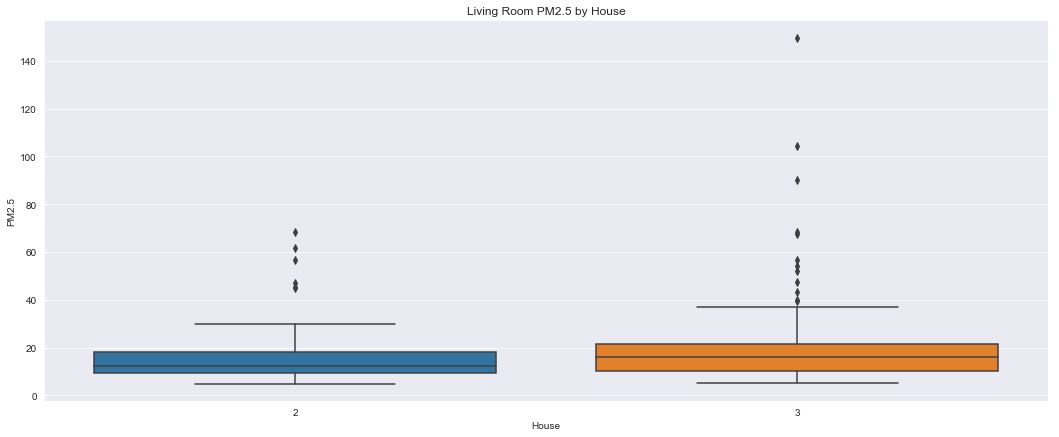

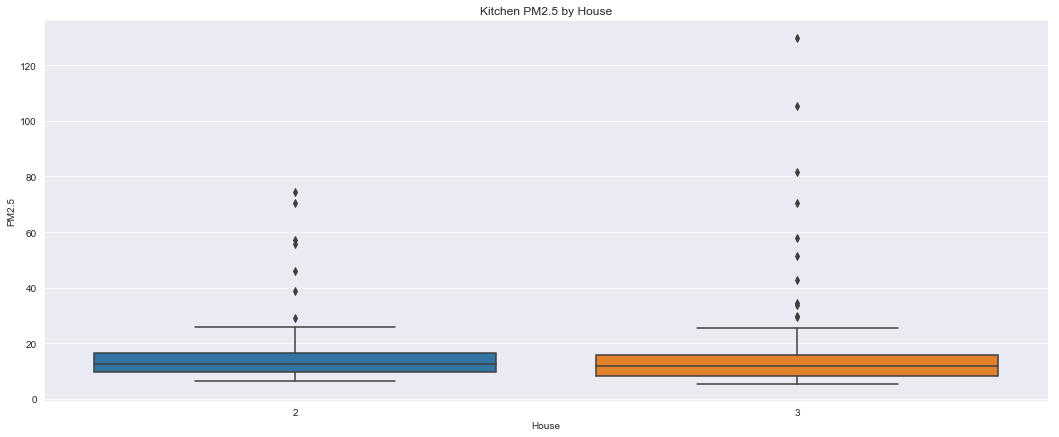

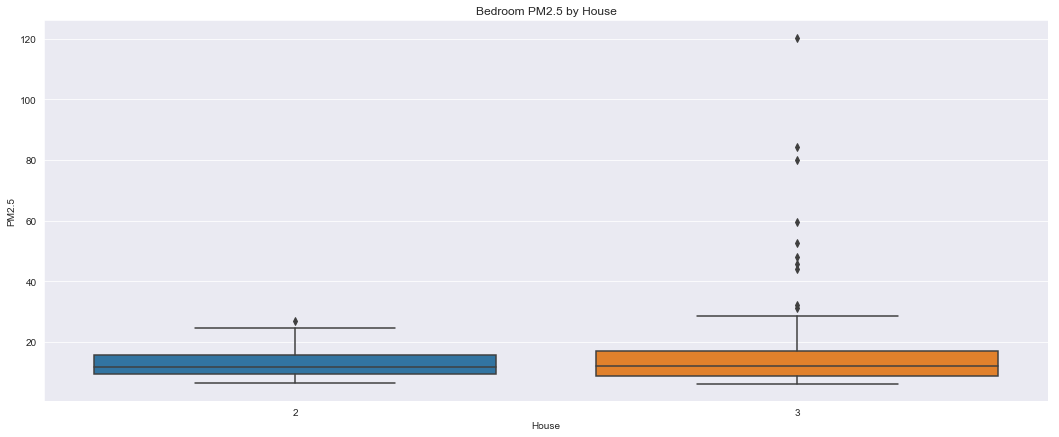

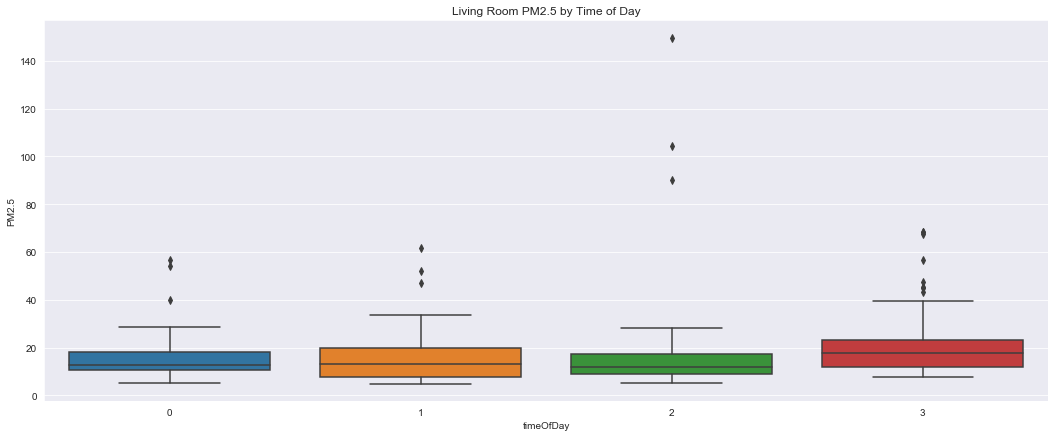

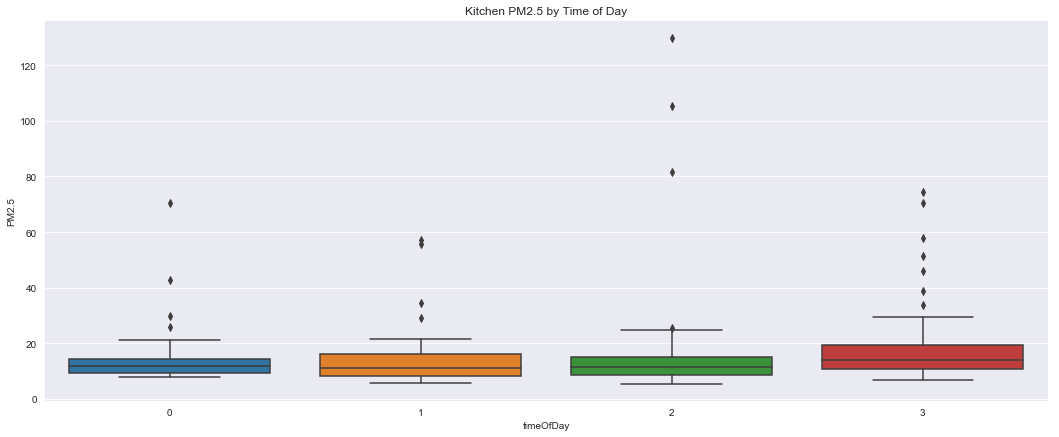

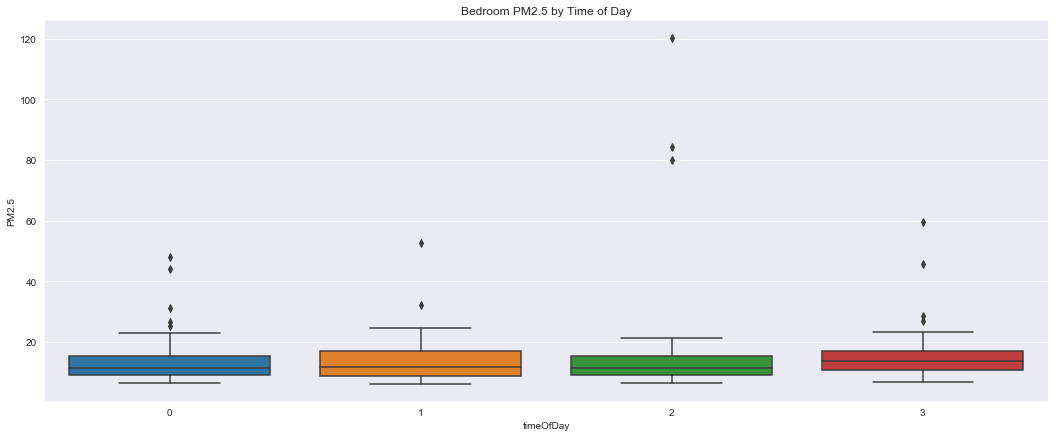

In [47]:
#Boxplots (work in progress)

plt.figure(figsize=(18,7))
sns.boxplot(x=LR['House'], y=LR['PM2.5'], orient='v')
plt.title(label="Living Room PM2.5 by House")
plt.show()
plt.figure(figsize=(18,7))
sns.boxplot(x=KR['House'], y=KR['PM2.5'], orient='v')
plt.title(label="Kitchen PM2.5 by House")
plt.show()
plt.figure(figsize=(18,7))
sns.boxplot(x=BR['House'], y=BR['PM2.5'], orient='v')
plt.title(label="Bedroom PM2.5 by House")
plt.show()
plt.figure(figsize=(18,7))
sns.boxplot(x=LR['timeOfDay'], y=LR['PM2.5'], orient='v')
plt.title(label="Living Room PM2.5 by Time of Day")
plt.show()
plt.figure(figsize=(18,7))
sns.boxplot(x=KR['timeOfDay'], y=KR['PM2.5'], orient='v')
plt.title(label="Kitchen PM2.5 by Time of Day")
plt.show()
plt.figure(figsize=(18,7))
sns.boxplot(x=BR['timeOfDay'], y=BR['PM2.5'], orient='v')
plt.title(label="Bedroom PM2.5 by Time of Day")
plt.show();

In [48]:
###############################################################################
######################## S T A N D A R D I Z A T I O N ########################
###############################################################################

LR1[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres','BR_MaxOccupancy', 
     'LR_MaxOccupancy','KR_MaxOccupancy']] = StandardScaler().fit_transform(
     LR1[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
             'LR_MaxOccupancy','KR_MaxOccupancy']])

KR1[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
     'LR_MaxOccupancy','KR_MaxOccupancy']] = StandardScaler().fit_transform(
     KR1[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
          'LR_MaxOccupancy','KR_MaxOccupancy']])

BR1[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
     'LR_MaxOccupancy','KR_MaxOccupancy']] = StandardScaler().fit_transform(
     BR1[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
          'LR_MaxOccupancy','KR_MaxOccupancy']])

LR2[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
     'LR_MaxOccupancy','KR_MaxOccupancy']] = StandardScaler().fit_transform(
     LR2[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
          'LR_MaxOccupancy','KR_MaxOccupancy']])

KR2[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
     'LR_MaxOccupancy','KR_MaxOccupancy']] = StandardScaler().fit_transform(
     KR2[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
          'LR_MaxOccupancy','KR_MaxOccupancy']])

BR2[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
     'LR_MaxOccupancy','KR_MaxOccupancy']] = StandardScaler().fit_transform(
     BR2[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
          'LR_MaxOccupancy','KR_MaxOccupancy']])

c:\python\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\python\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
c:\python\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\python\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
c:\python\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return

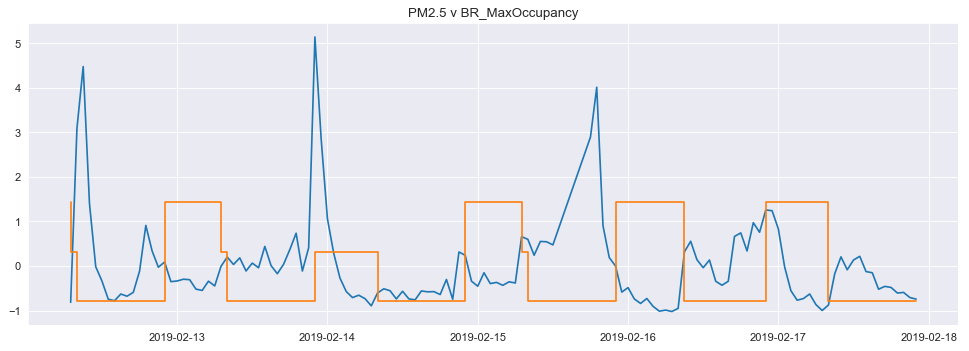

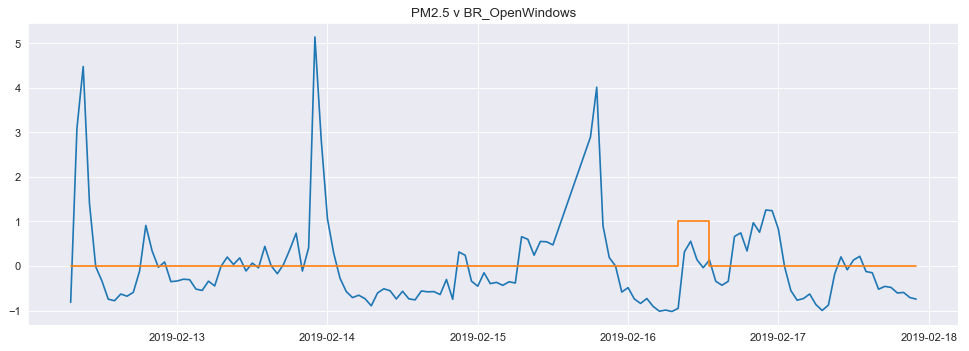

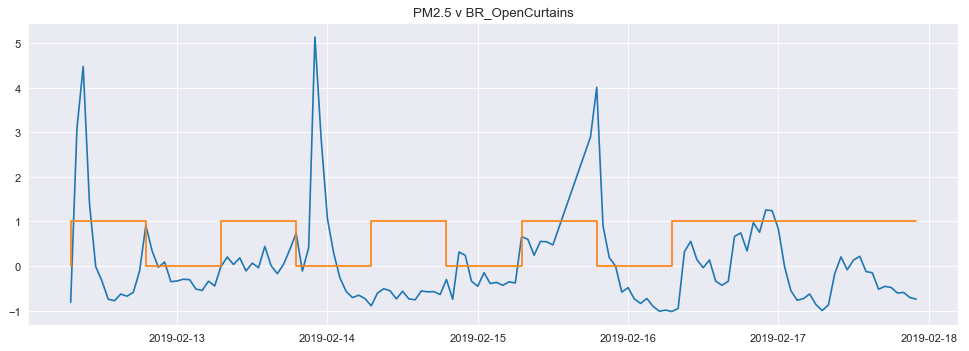

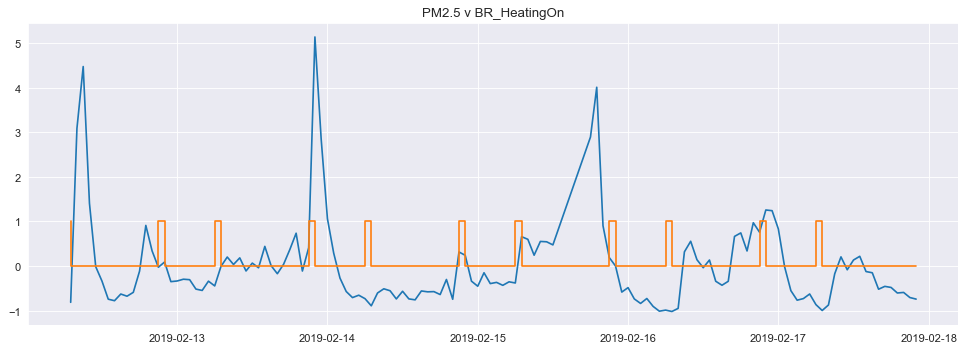

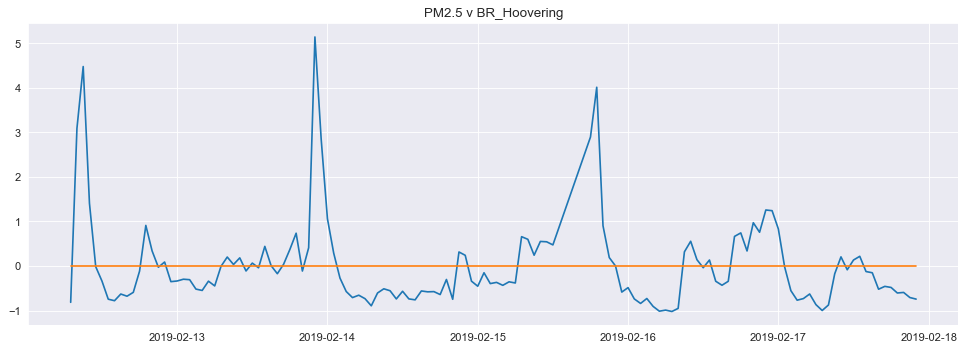

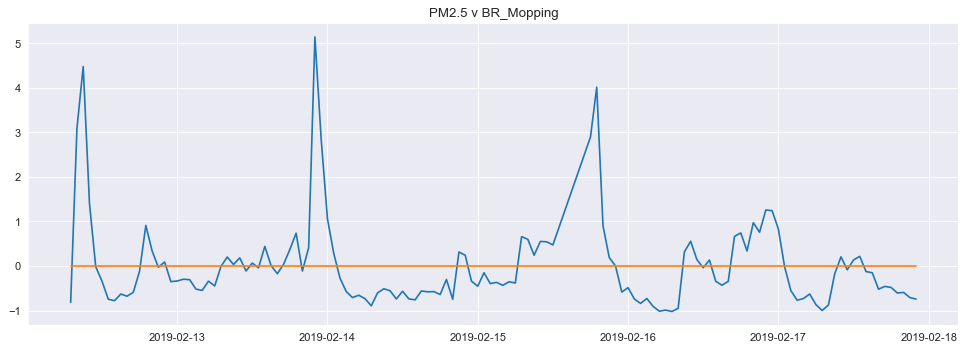

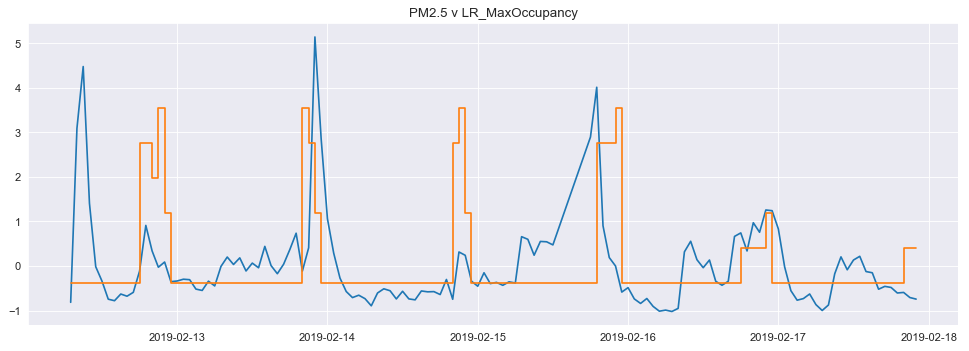

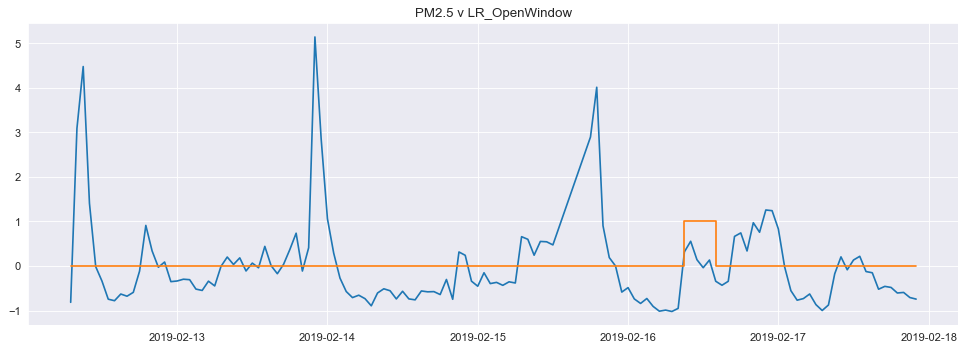

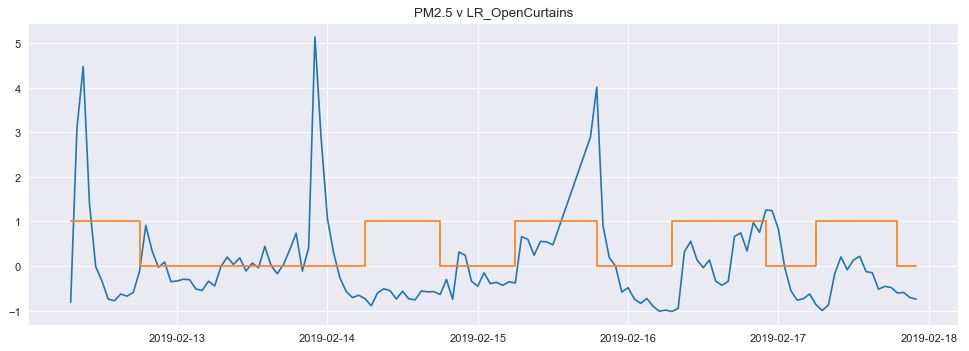

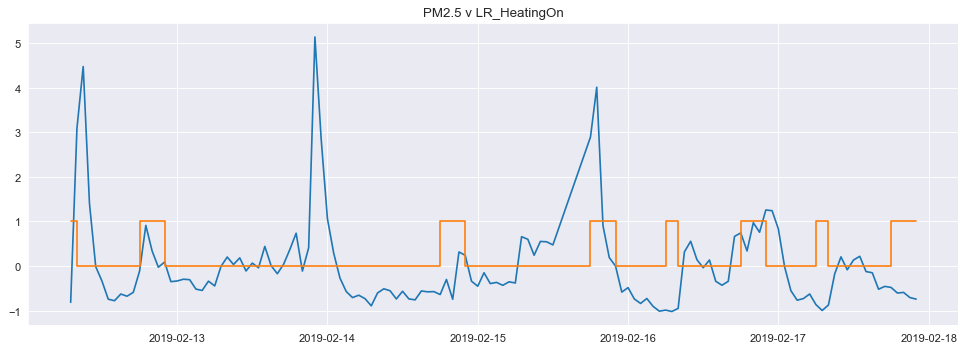

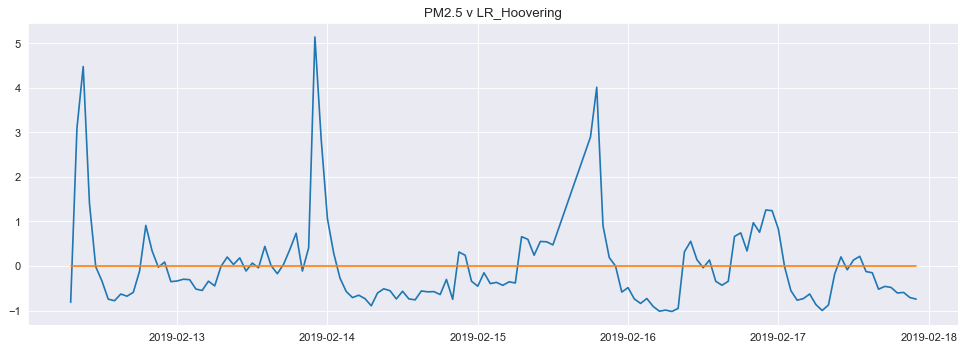

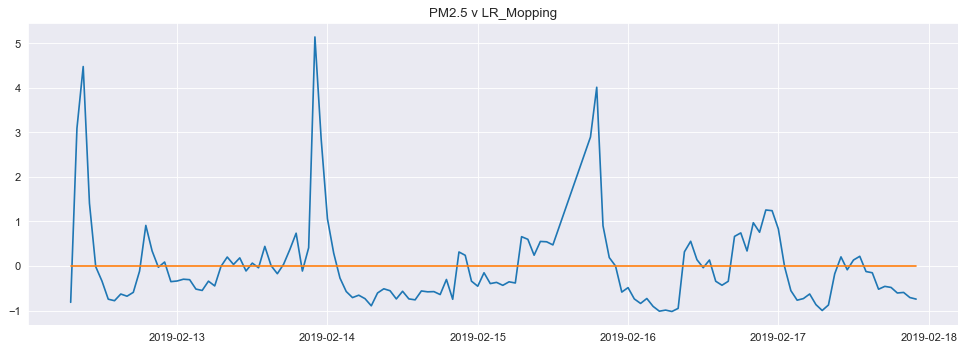

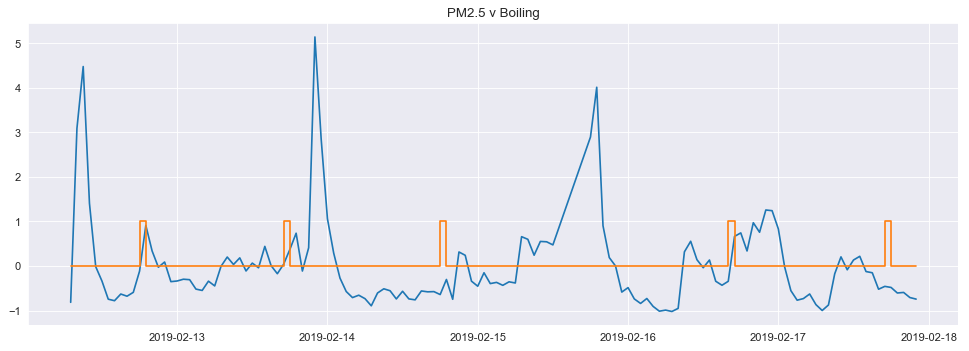

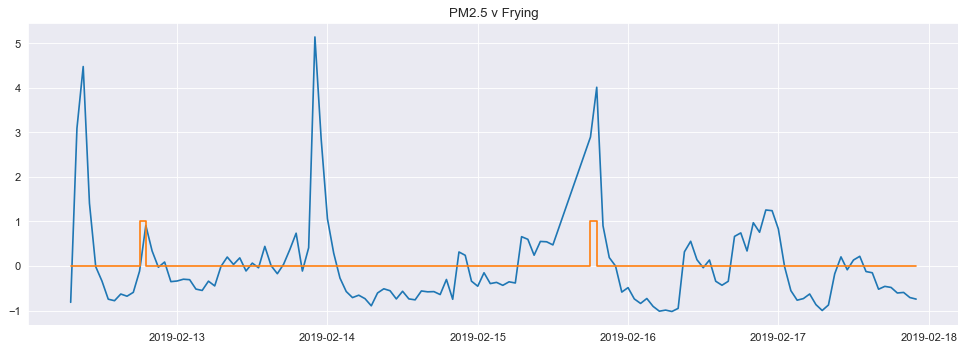

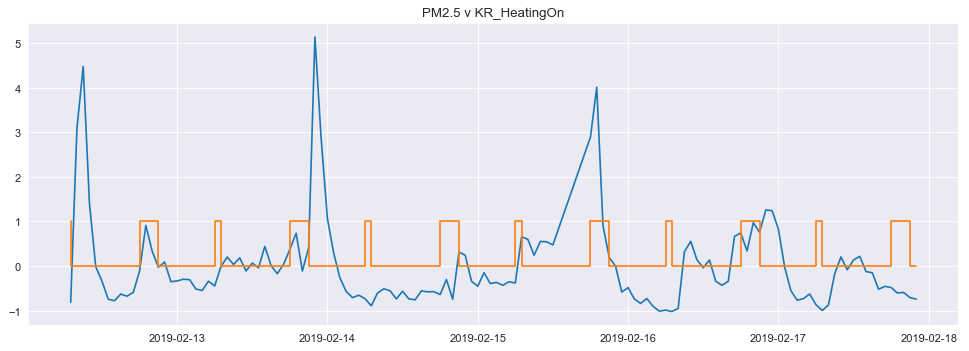

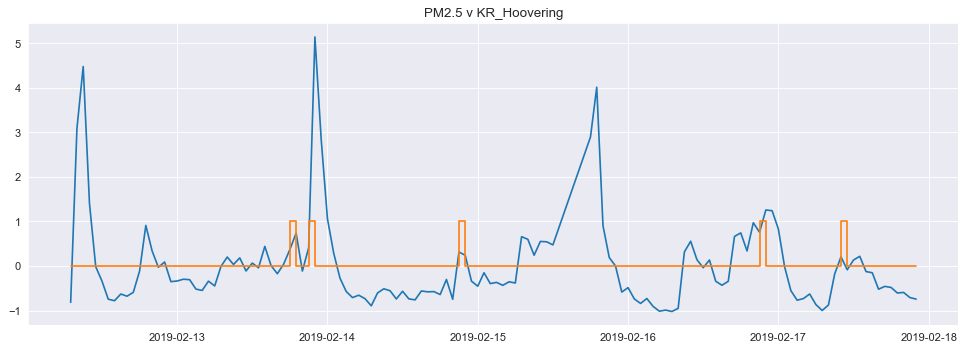

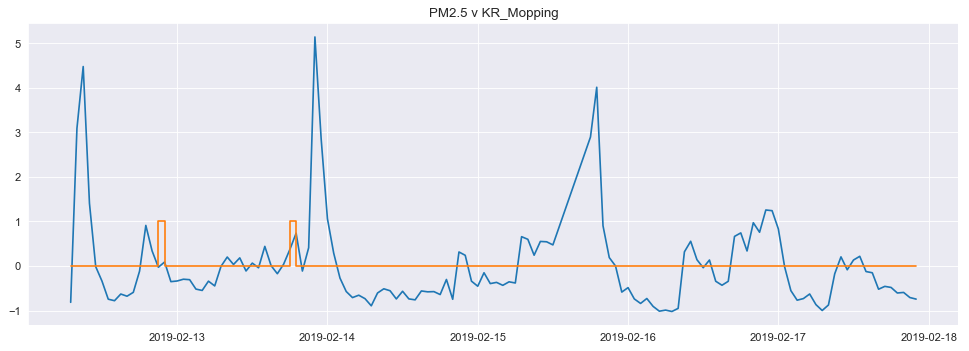

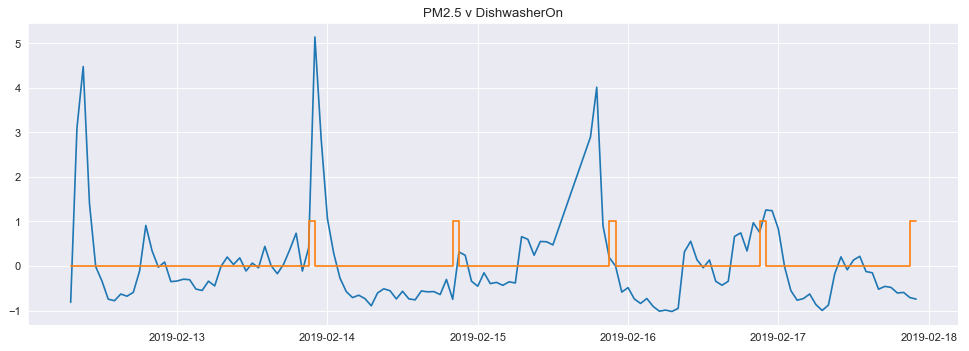

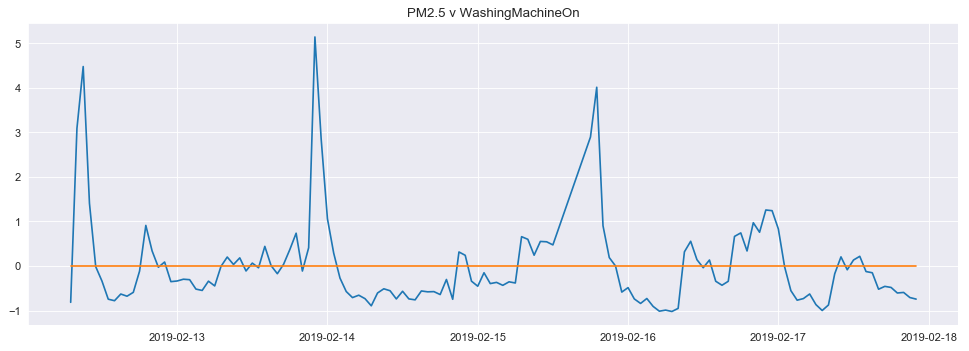

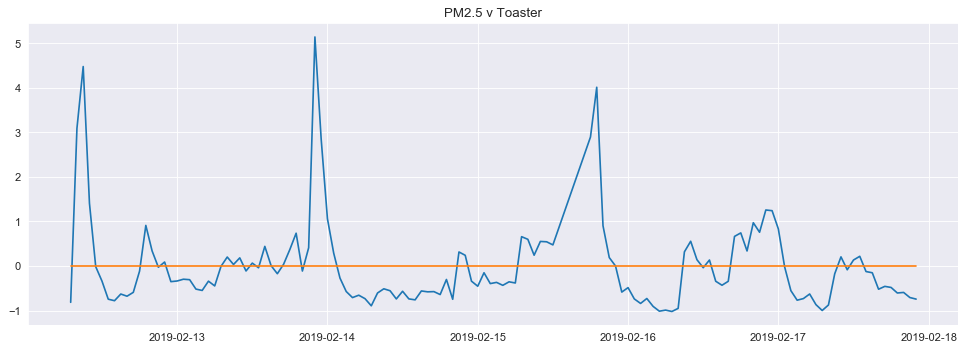

In [49]:
#Steplots LR1

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.step(x=LR1.index, y=LR1["BR_MaxOccupancy"]);
plt.title('PM2.5 v BR_MaxOccupancy')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.step(x=LR1.index, y=LR1["BR_OpenWindows"]);
plt.title('PM2.5 v BR_OpenWindows')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v BR_OpenCurtains')
plt.step(x=LR1.index, y=LR1["BR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v BR_HeatingOn')
plt.step(x=LR1.index, y=LR1["BR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v BR_Hoovering')
plt.step(x=LR1.index, y=LR1["BR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v BR_Mopping')
plt.step(x=LR1.index, y=LR1["BR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v LR_MaxOccupancy')
plt.step(x=LR1.index, y=LR1["LR_MaxOccupancy"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v LR_OpenWindow')
plt.step(x=LR1.index, y=LR1["LR_OpenWindow"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v LR_OpenCurtains')
plt.step(x=LR1.index, y=LR1["LR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v LR_HeatingOn')
plt.step(x=LR1.index, y=LR1["LR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v LR_Hoovering')
plt.step(x=LR1.index, y=LR1["LR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v LR_Mopping')
plt.step(x=LR1.index, y=LR1["LR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v Boiling')
plt.step(x=LR1.index, y=LR1["Boiling"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v Frying')
plt.step(x=LR1.index, y=LR1["Frying"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v KR_HeatingOn')
plt.step(x=LR1.index, y=LR1["KR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v KR_Hoovering')
plt.step(x=LR1.index, y=LR1["KR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v KR_Mopping')
plt.step(x=LR1.index, y=LR1["KR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v DishwasherOn')
plt.step(x=LR1.index, y=LR1["DishwasherOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v WashingMachineOn')
plt.step(x=LR1.index, y=LR1["WashingMachineOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR1["PM2.5"])
plt.title('PM2.5 v Toaster')
plt.step(x=LR1.index, y=LR1["Toaster"]);
plt.show()

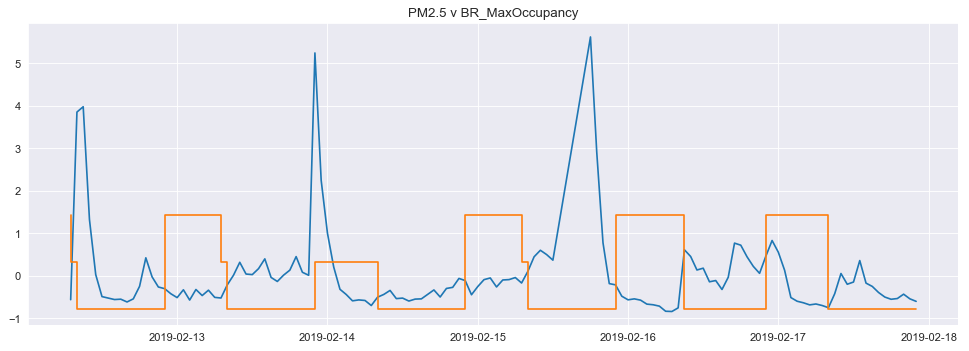

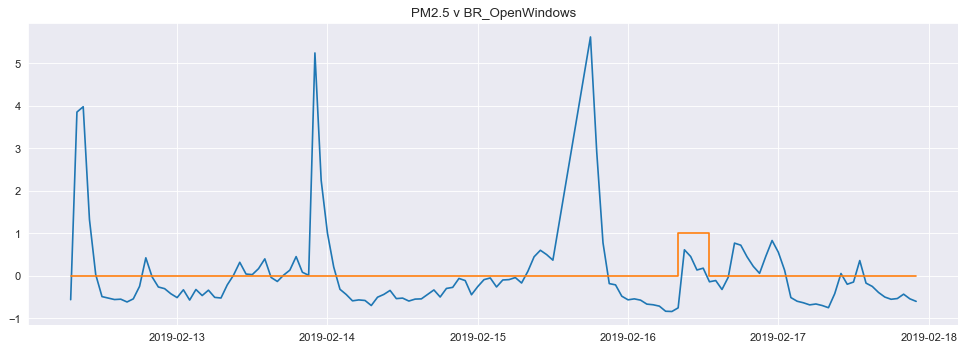

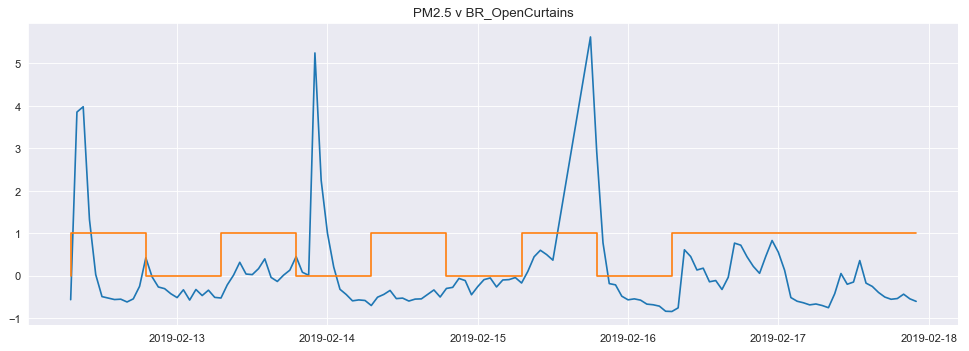

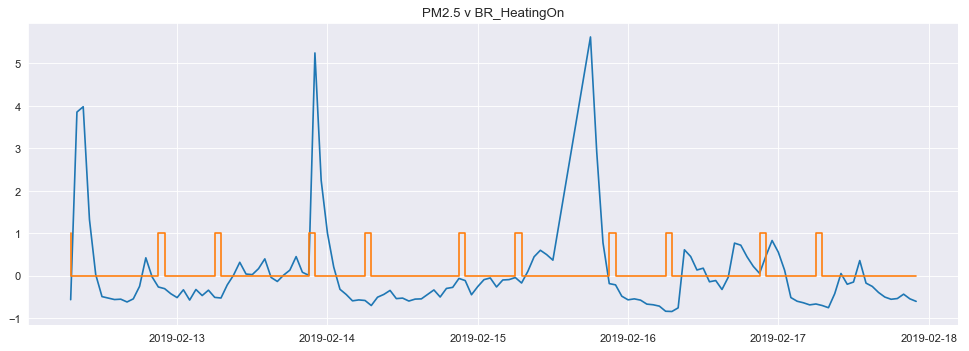

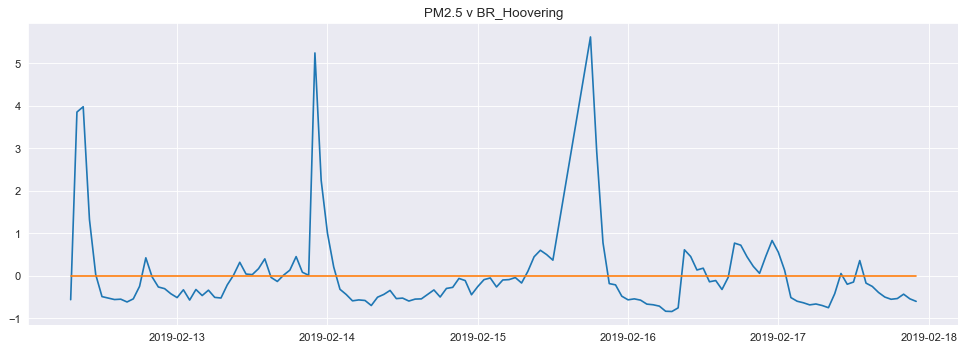

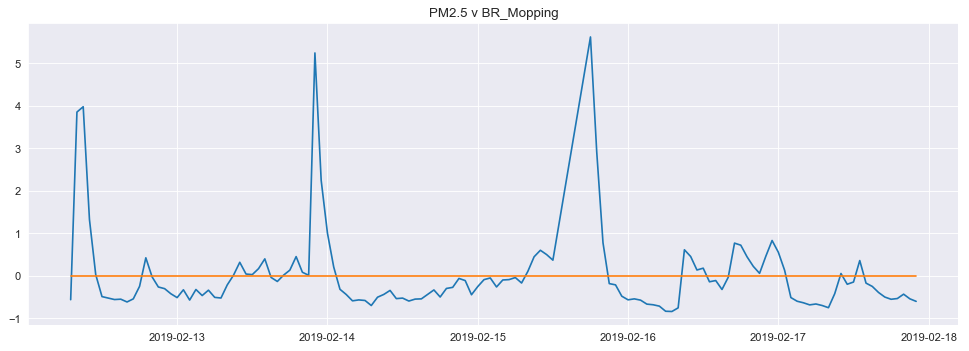

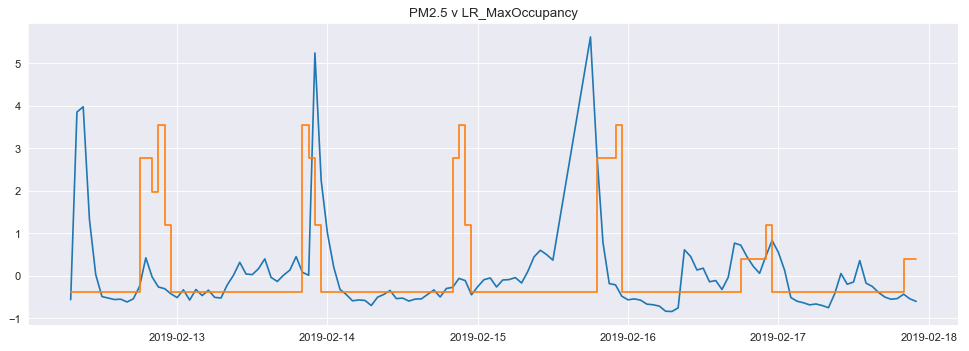

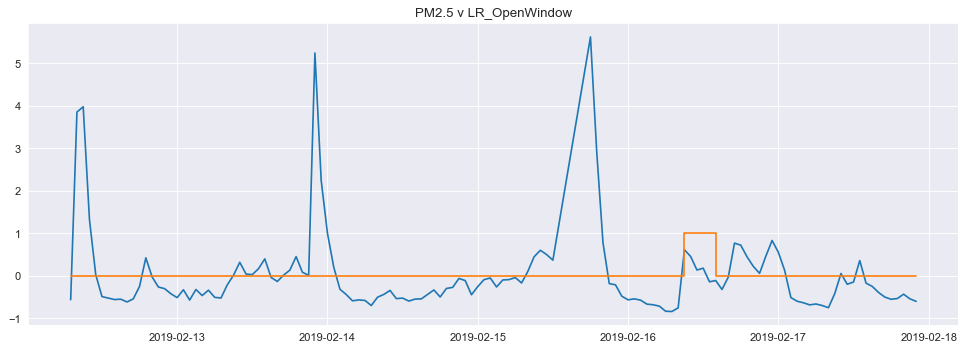

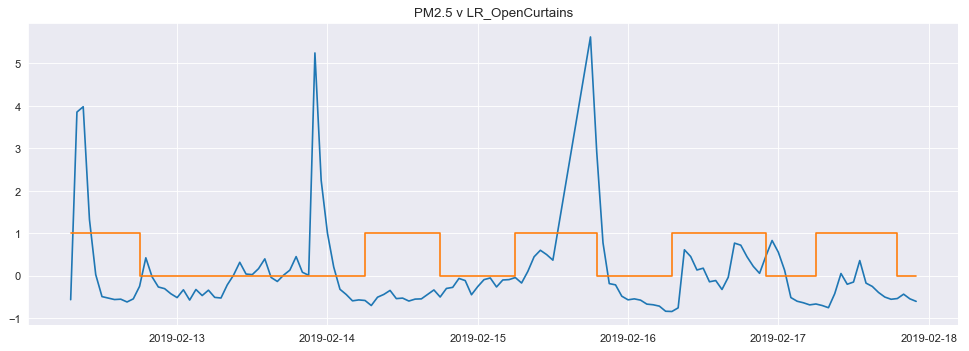

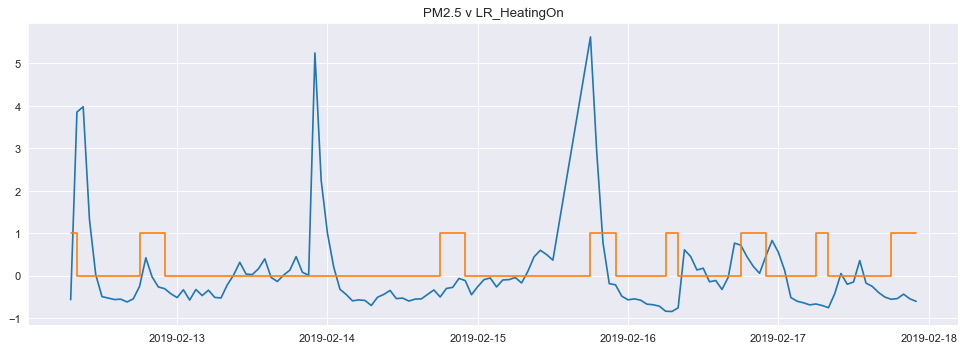

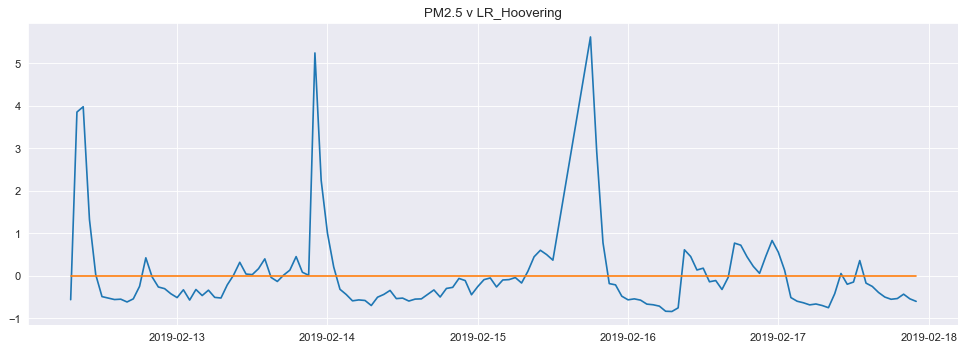

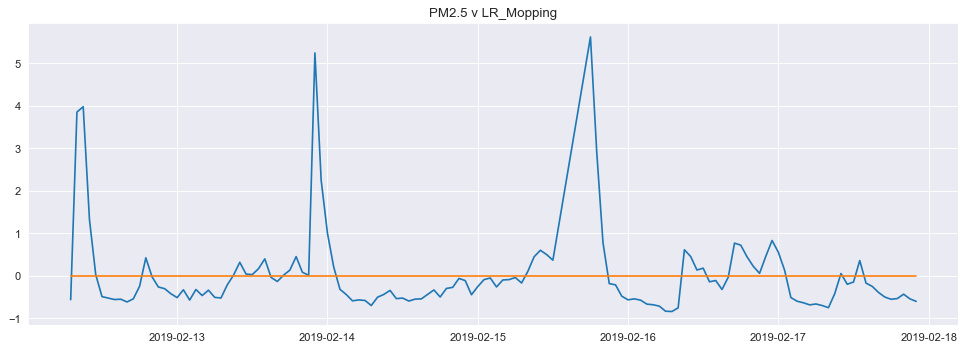

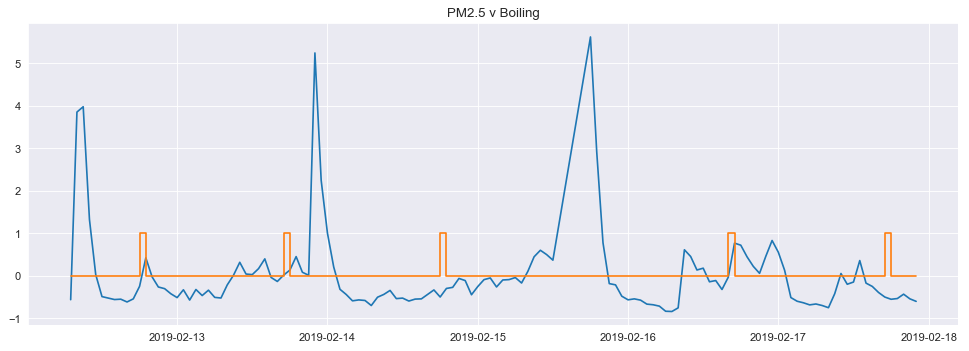

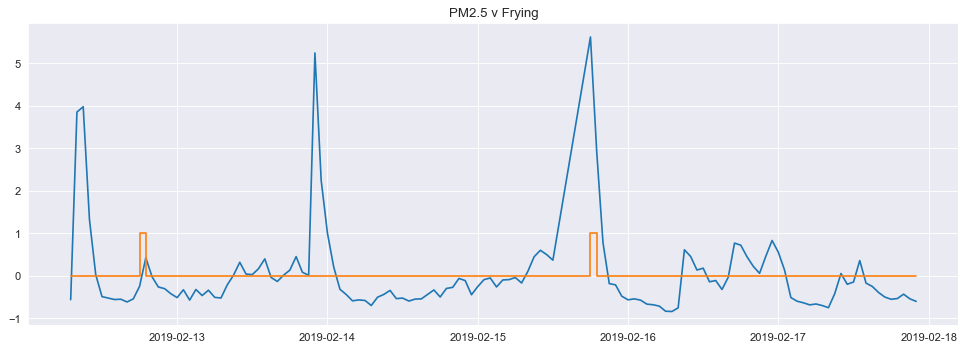

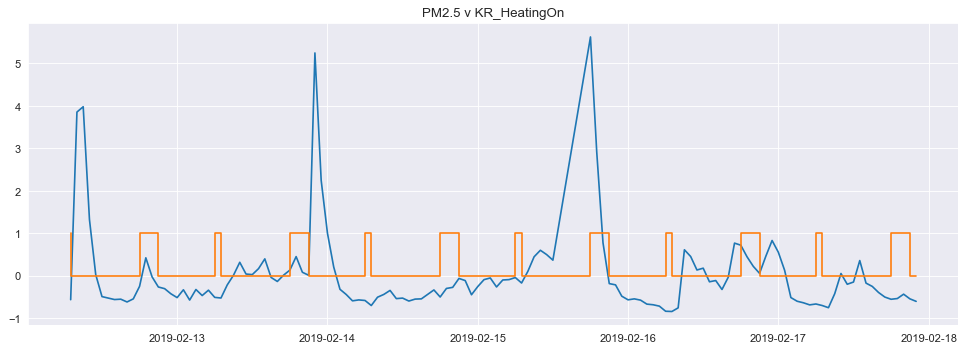

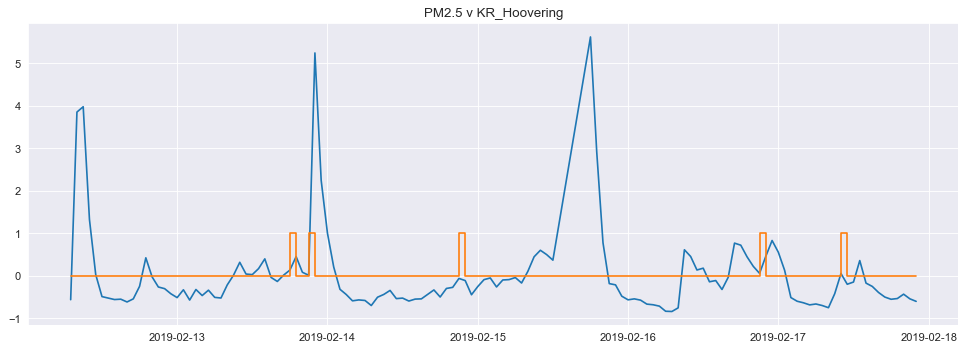

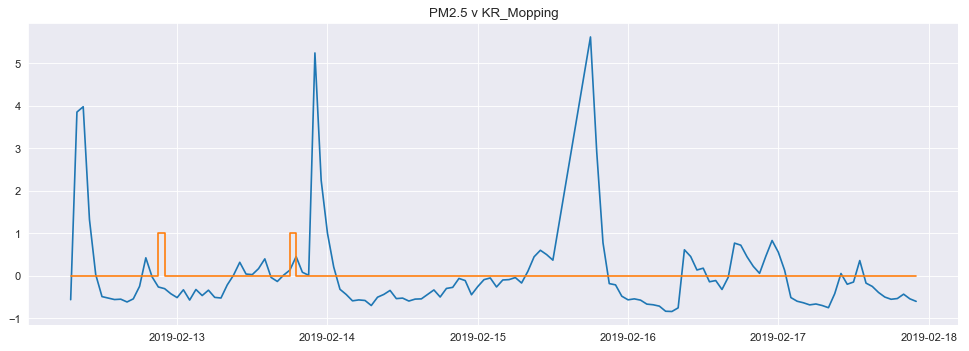

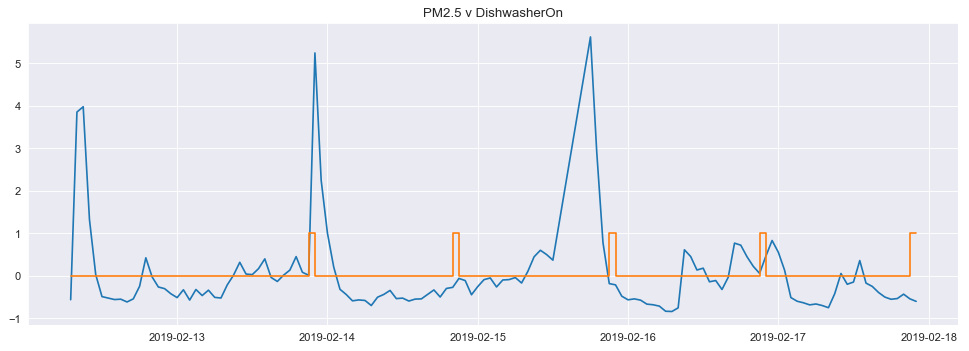

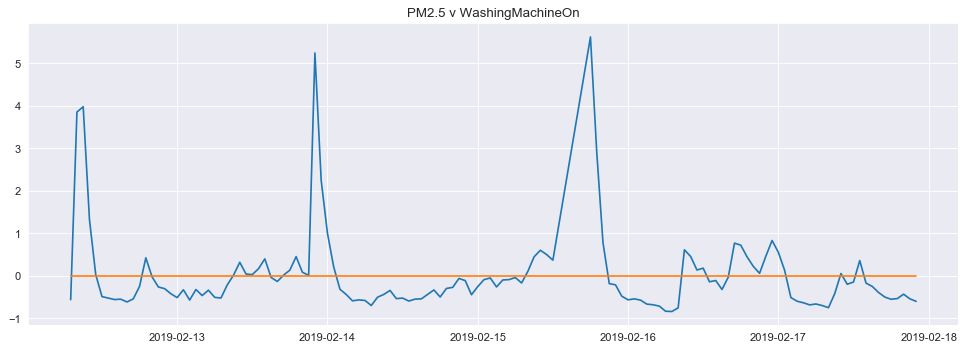

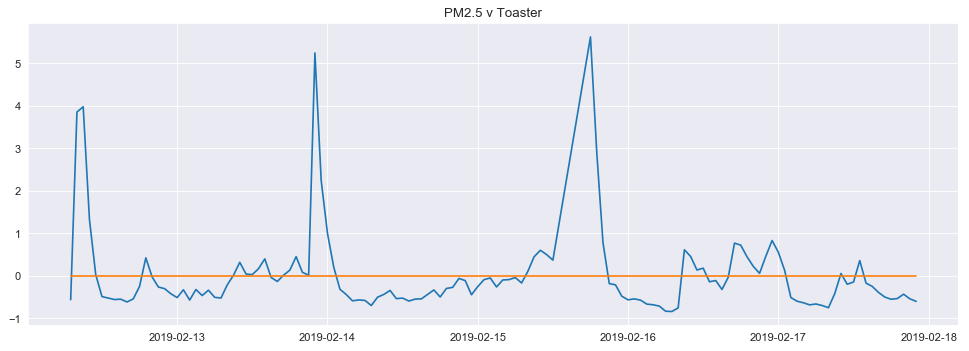

In [50]:
#stepplots KR1

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.step(x=KR1.index, y=KR1["BR_MaxOccupancy"]);
plt.title('PM2.5 v BR_MaxOccupancy')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.step(x=KR1.index, y=KR1["BR_OpenWindows"]);
plt.title('PM2.5 v BR_OpenWindows')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v BR_OpenCurtains')
plt.step(x=KR1.index, y=KR1["BR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v BR_HeatingOn')
plt.step(x=KR1.index, y=KR1["BR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v BR_Hoovering')
plt.step(x=KR1.index, y=KR1["BR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v BR_Mopping')
plt.step(x=KR1.index, y=KR1["BR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v LR_MaxOccupancy')
plt.step(x=KR1.index, y=KR1["LR_MaxOccupancy"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v LR_OpenWindow')
plt.step(x=KR1.index, y=KR1["LR_OpenWindow"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v LR_OpenCurtains')
plt.step(x=KR1.index, y=KR1["LR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v LR_HeatingOn')
plt.step(x=KR1.index, y=KR1["LR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v LR_Hoovering')
plt.step(x=KR1.index, y=KR1["LR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v LR_Mopping')
plt.step(x=KR1.index, y=KR1["LR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v Boiling')
plt.step(x=KR1.index, y=KR1["Boiling"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v Frying')
plt.step(x=KR1.index, y=KR1["Frying"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v KR_HeatingOn')
plt.step(x=KR1.index, y=KR1["KR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v KR_Hoovering')
plt.step(x=KR1.index, y=KR1["KR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v KR_Mopping')
plt.step(x=KR1.index, y=KR1["KR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v DishwasherOn')
plt.step(x=KR1.index, y=KR1["DishwasherOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v WashingMachineOn')
plt.step(x=KR1.index, y=KR1["WashingMachineOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR1["PM2.5"])
plt.title('PM2.5 v Toaster')
plt.step(x=KR1.index, y=KR1["Toaster"]);
plt.show()

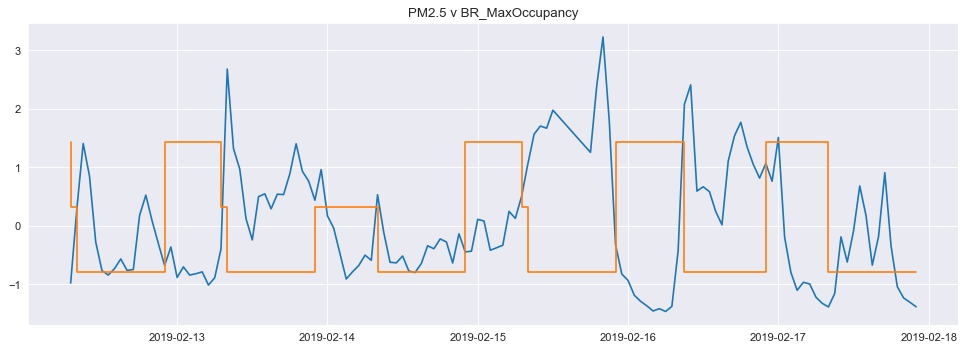

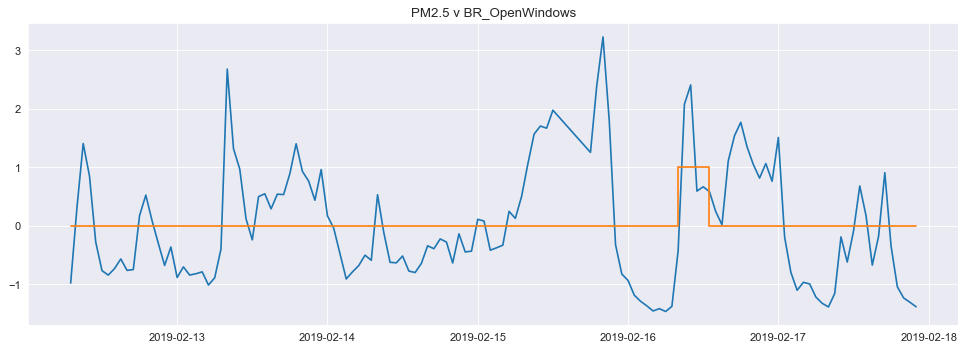

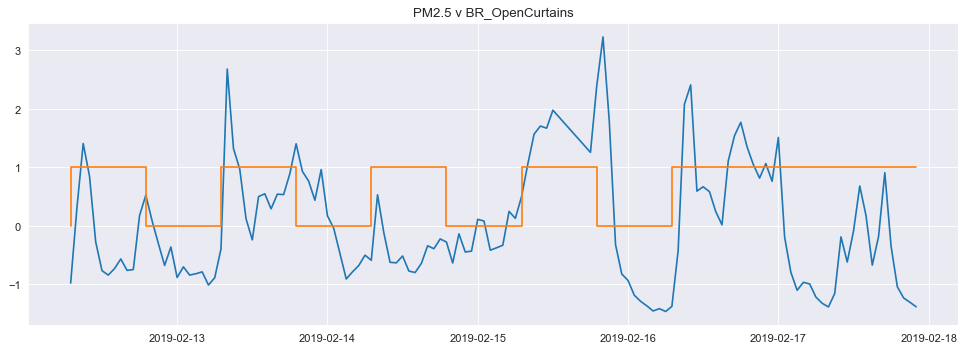

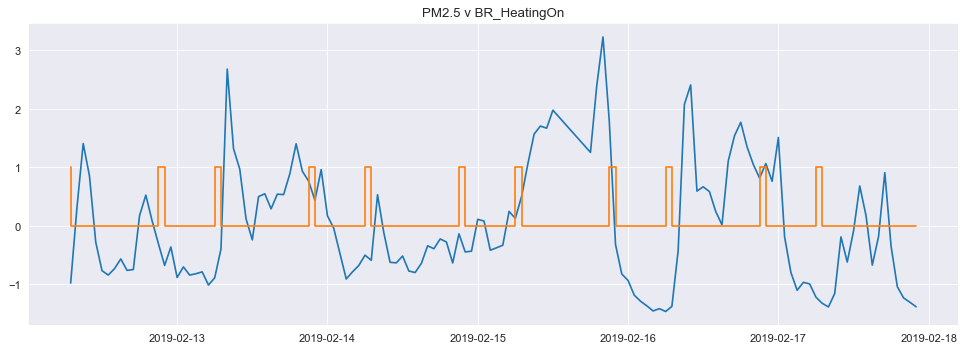

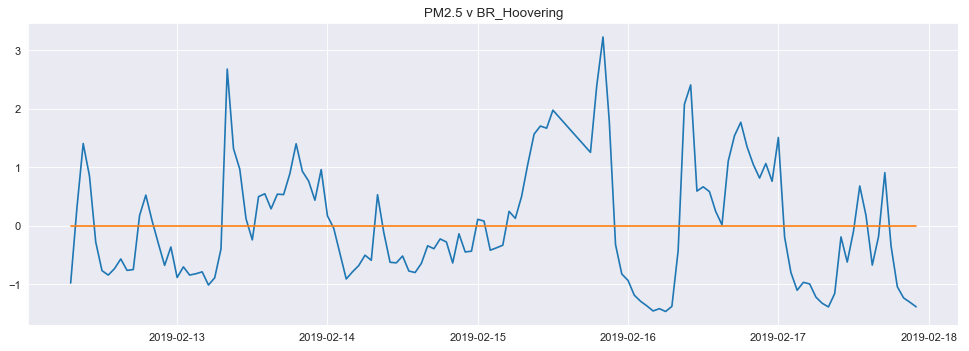

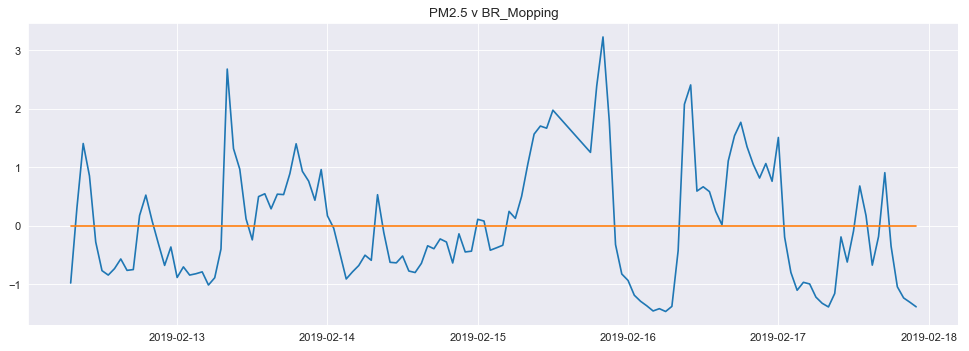

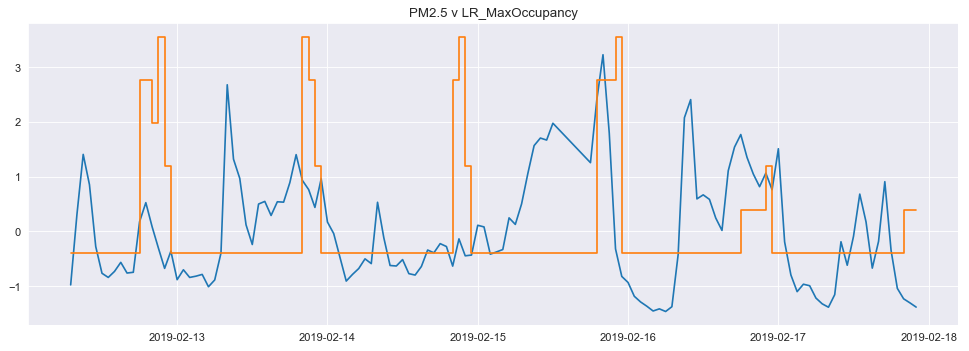

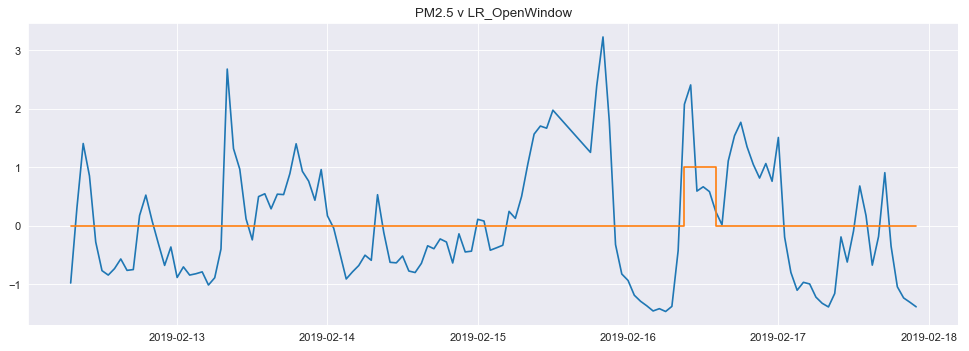

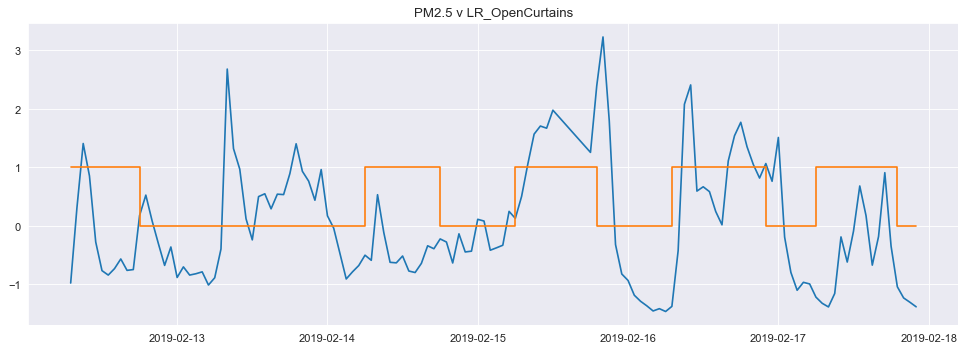

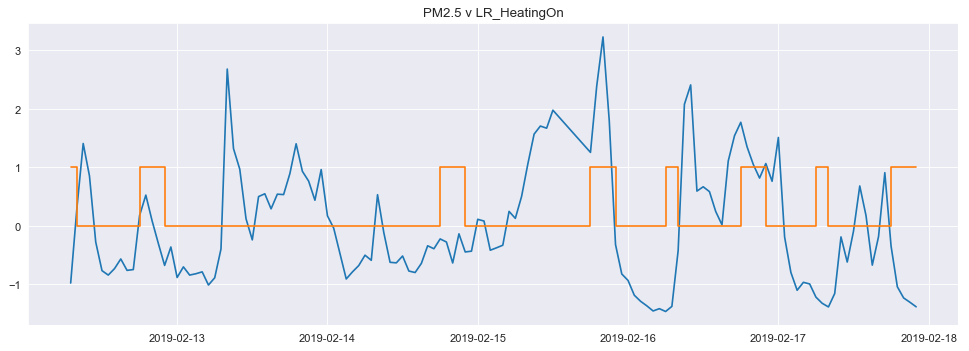

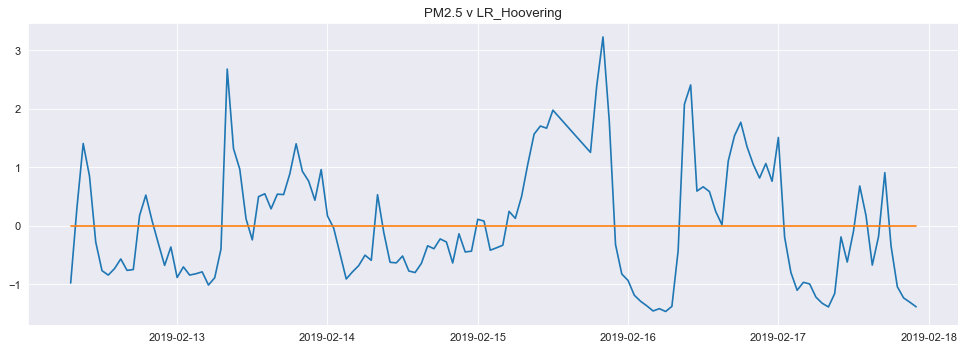

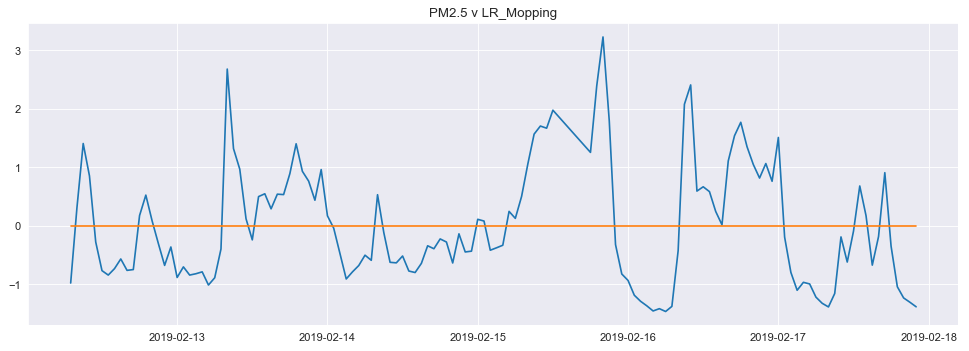

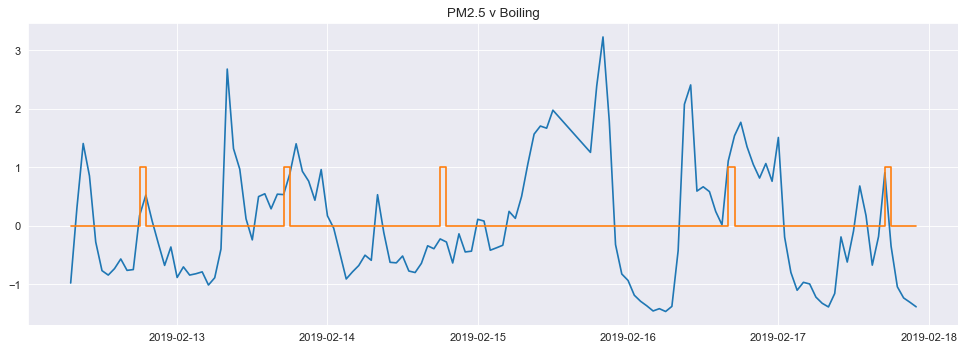

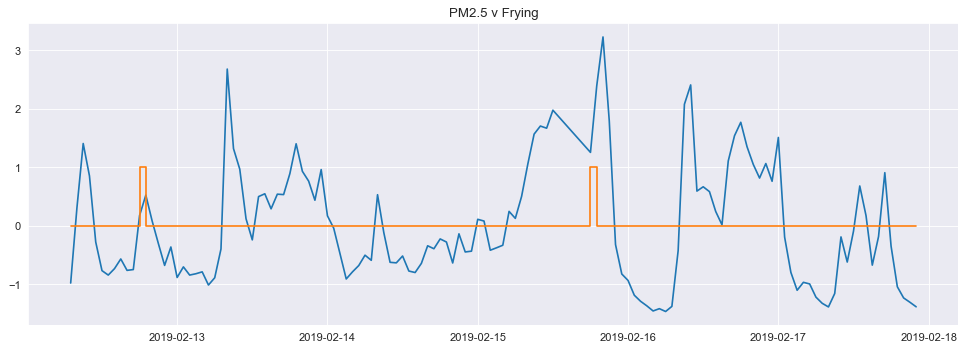

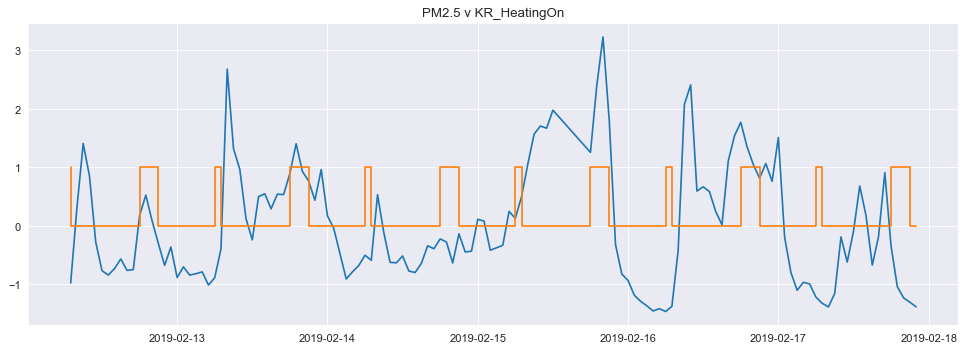

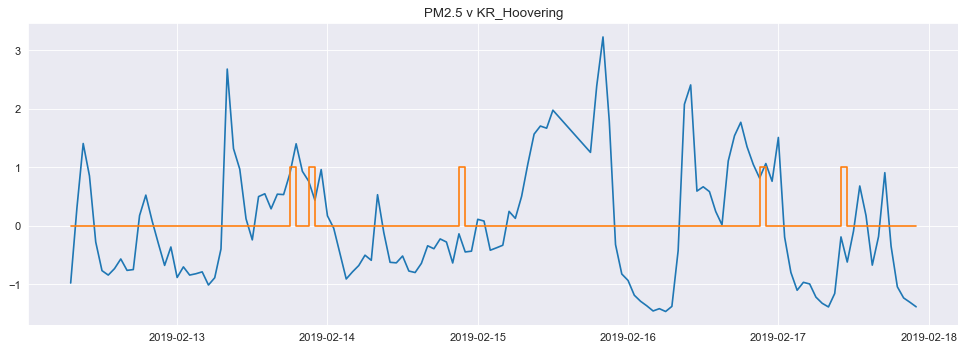

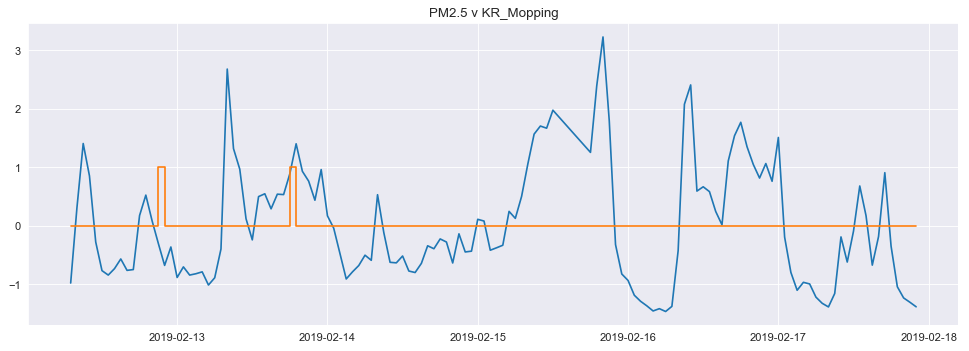

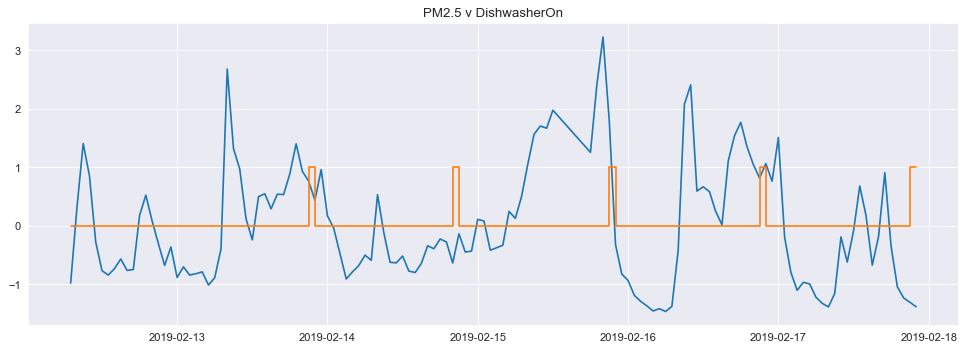

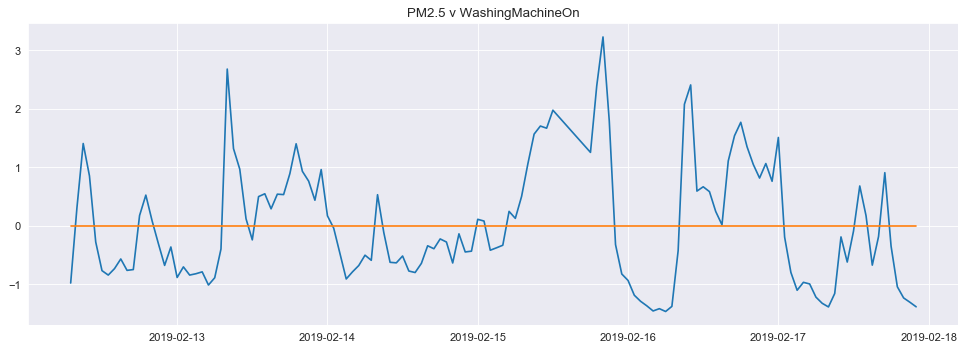

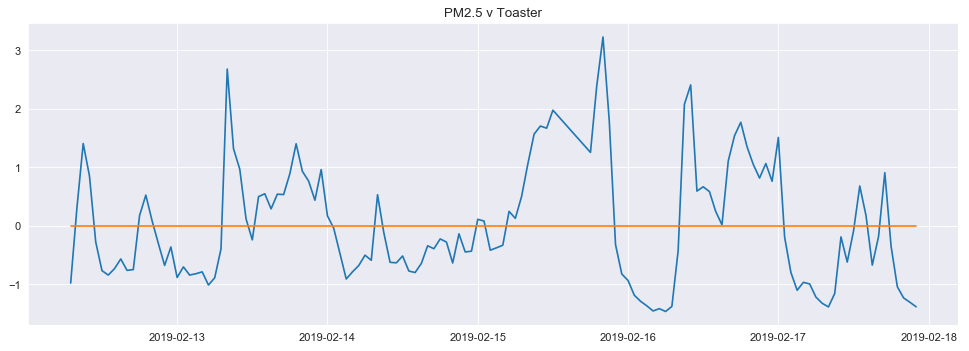

In [51]:
#Steplots BR1

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.step(x=BR1.index, y=BR1["BR_MaxOccupancy"]);
plt.title('PM2.5 v BR_MaxOccupancy')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.step(x=BR1.index, y=BR1["BR_OpenWindows"]);
plt.title('PM2.5 v BR_OpenWindows')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v BR_OpenCurtains')
plt.step(x=BR1.index, y=BR1["BR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v BR_HeatingOn')
plt.step(x=BR1.index, y=BR1["BR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v BR_Hoovering')
plt.step(x=BR1.index, y=BR1["BR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v BR_Mopping')
plt.step(x=BR1.index, y=BR1["BR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v LR_MaxOccupancy')
plt.step(x=BR1.index, y=BR1["LR_MaxOccupancy"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v LR_OpenWindow')
plt.step(x=BR1.index, y=BR1["LR_OpenWindow"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v LR_OpenCurtains')
plt.step(x=BR1.index, y=BR1["LR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v LR_HeatingOn')
plt.step(x=BR1.index, y=BR1["LR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v LR_Hoovering')
plt.step(x=BR1.index, y=BR1["LR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v LR_Mopping')
plt.step(x=BR1.index, y=BR1["LR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v Boiling')
plt.step(x=BR1.index, y=BR1["Boiling"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v Frying')
plt.step(x=BR1.index, y=BR1["Frying"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v KR_HeatingOn')
plt.step(x=BR1.index, y=BR1["KR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v KR_Hoovering')
plt.step(x=BR1.index, y=BR1["KR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v KR_Mopping')
plt.step(x=BR1.index, y=BR1["KR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v DishwasherOn')
plt.step(x=BR1.index, y=BR1["DishwasherOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v WashingMachineOn')
plt.step(x=BR1.index, y=BR1["WashingMachineOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR1["PM2.5"])
plt.title('PM2.5 v Toaster')
plt.step(x=BR1.index, y=BR1["Toaster"]);
plt.show()

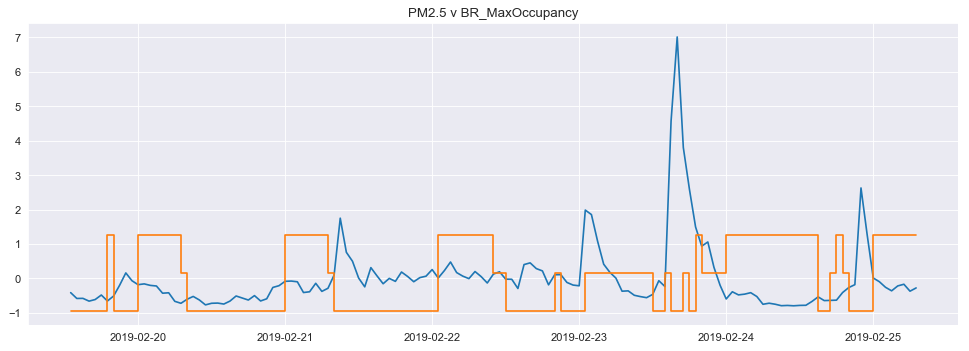

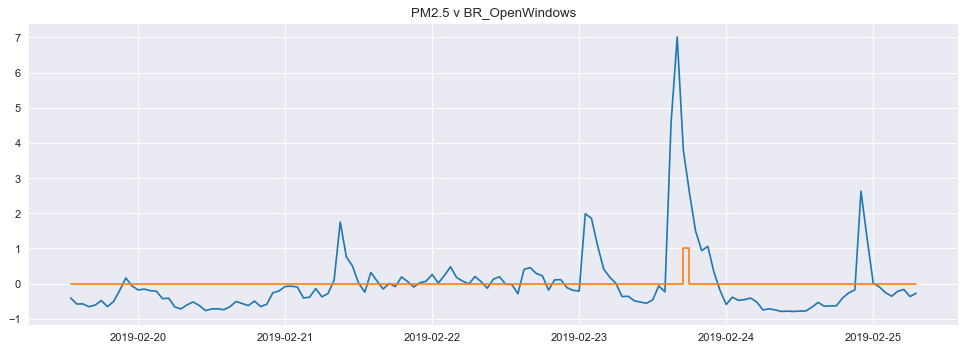

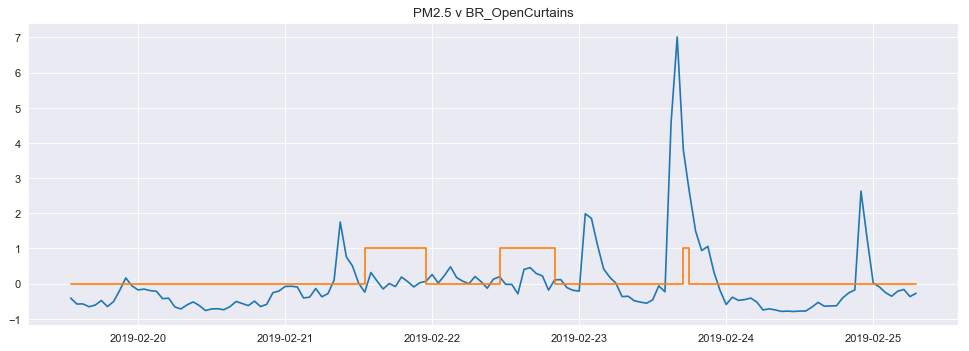

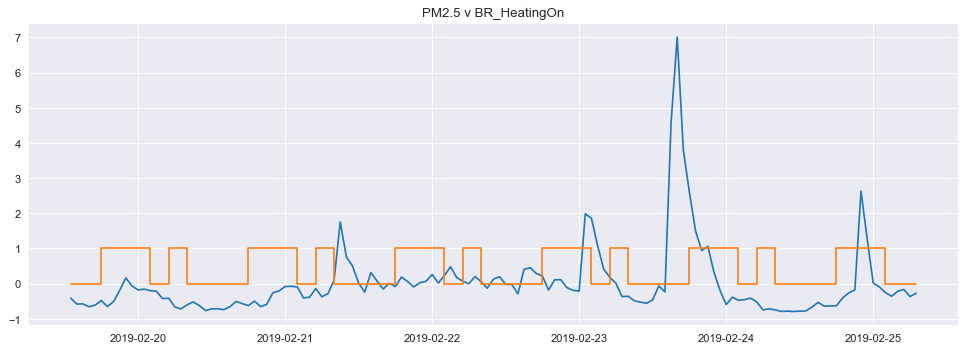

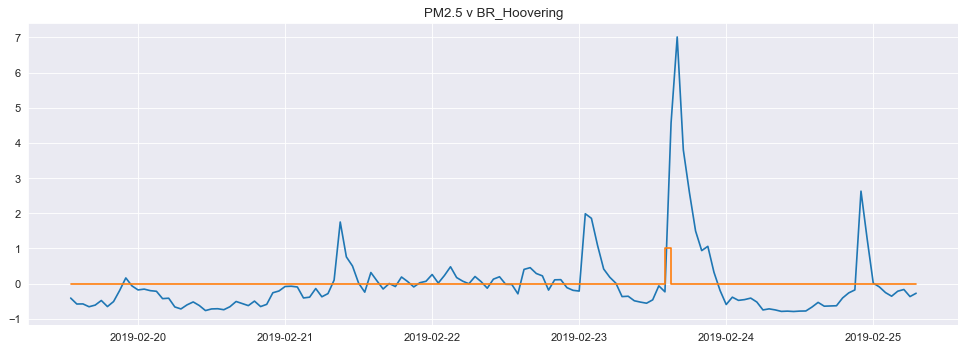

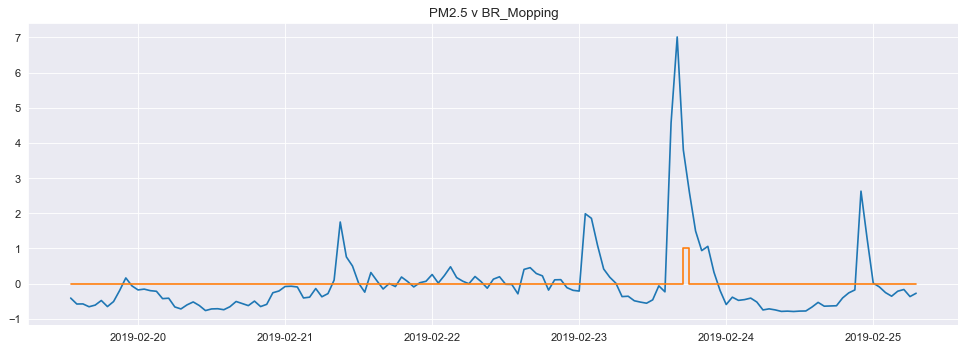

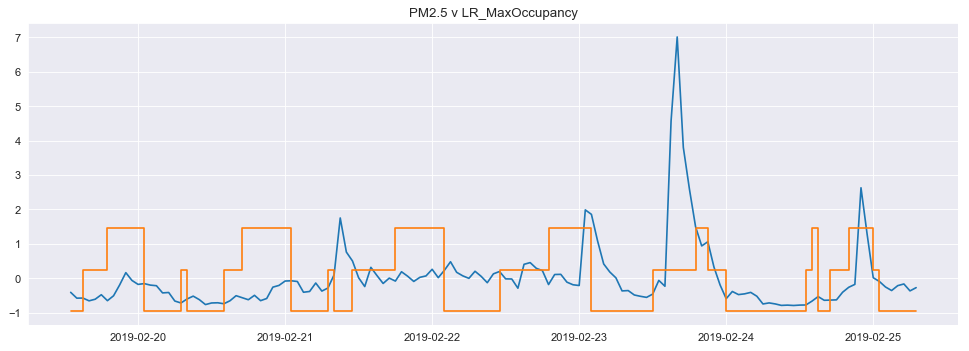

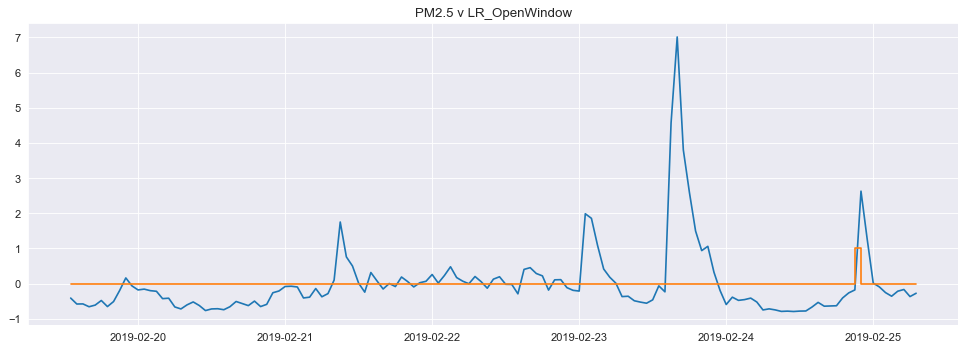

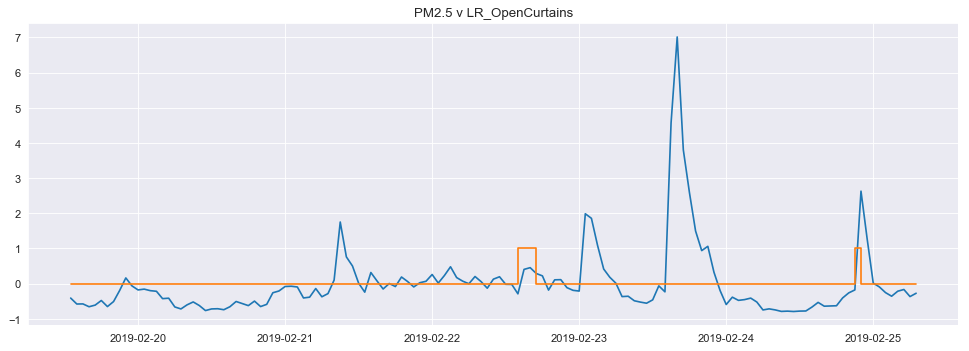

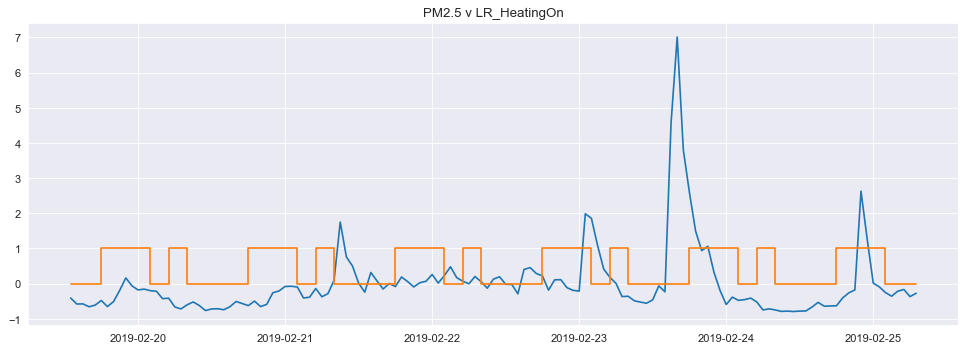

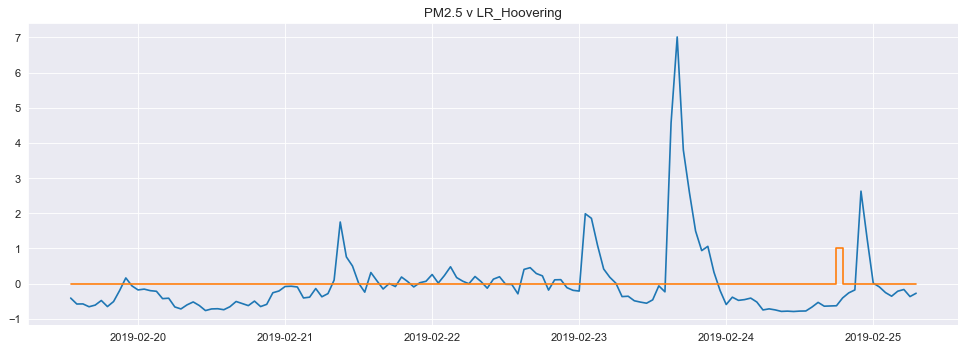

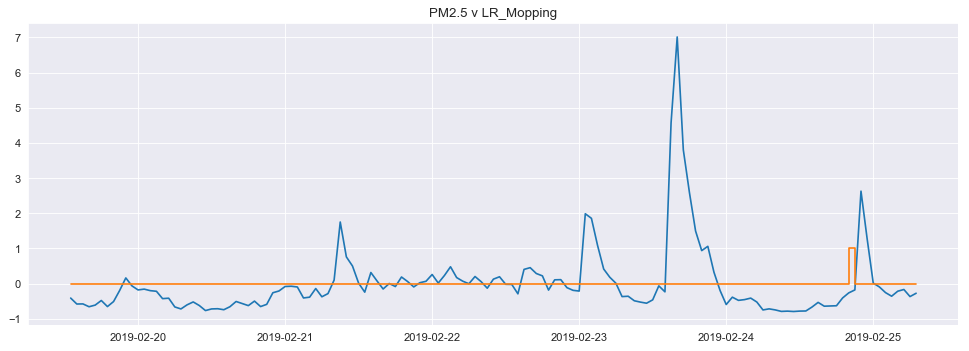

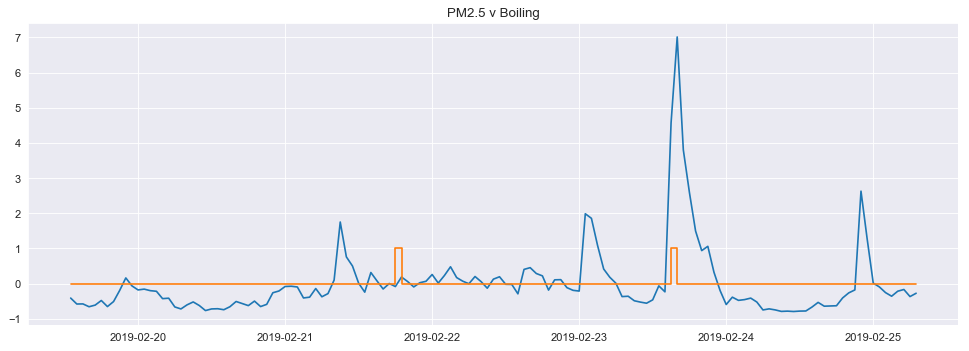

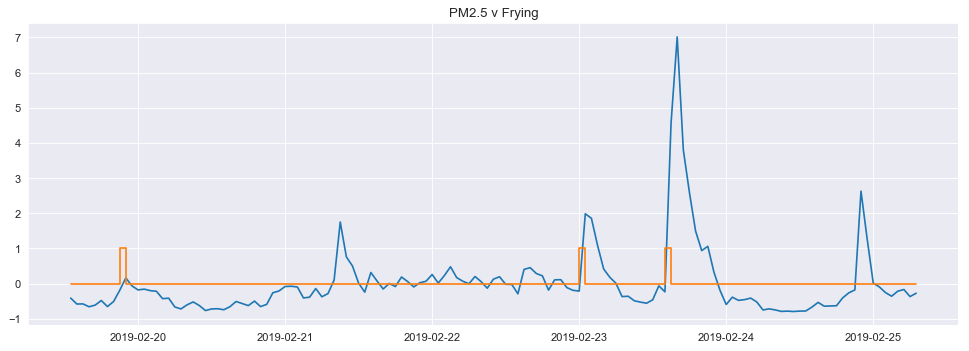

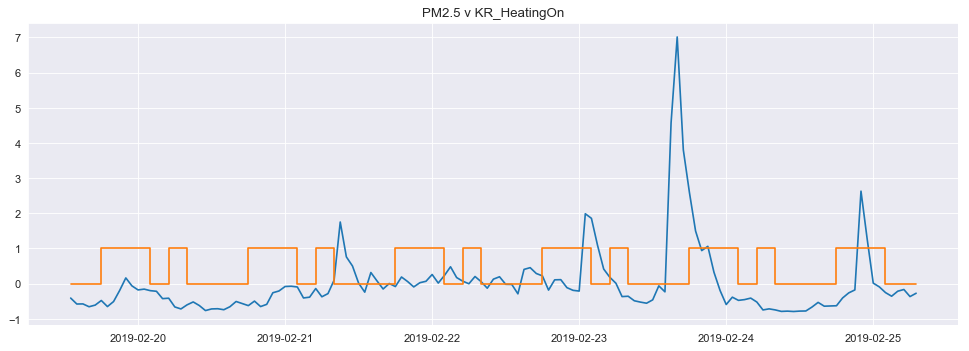

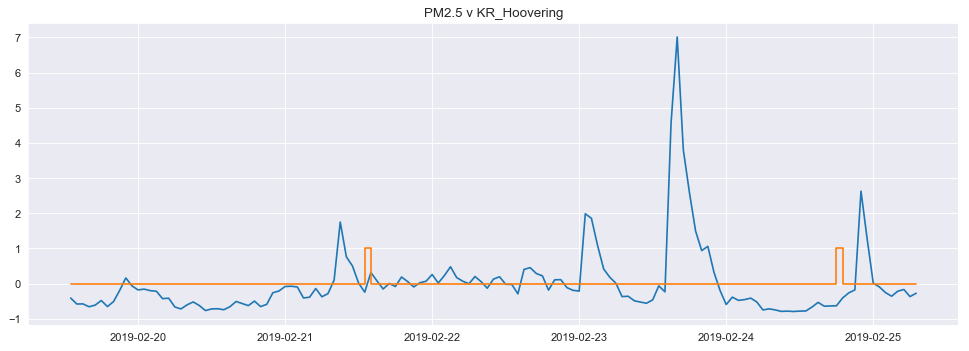

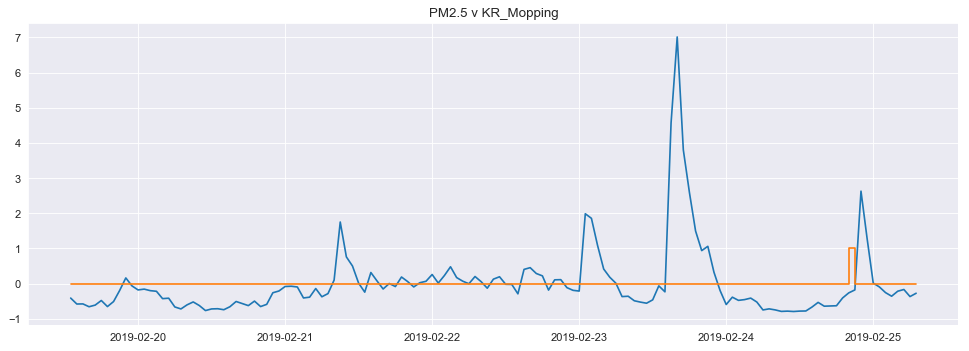

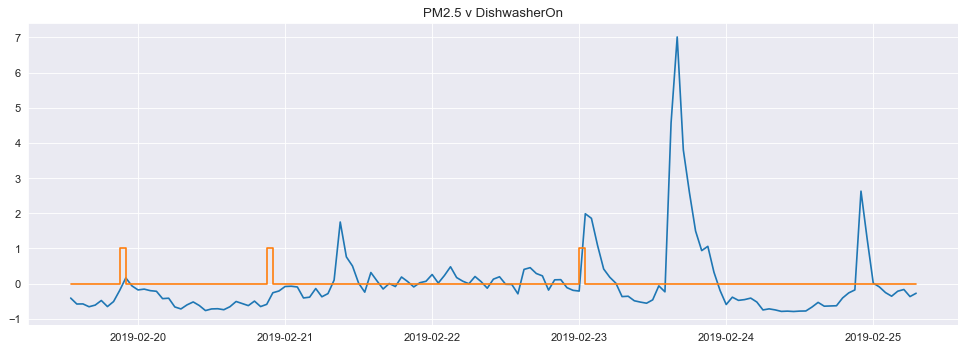

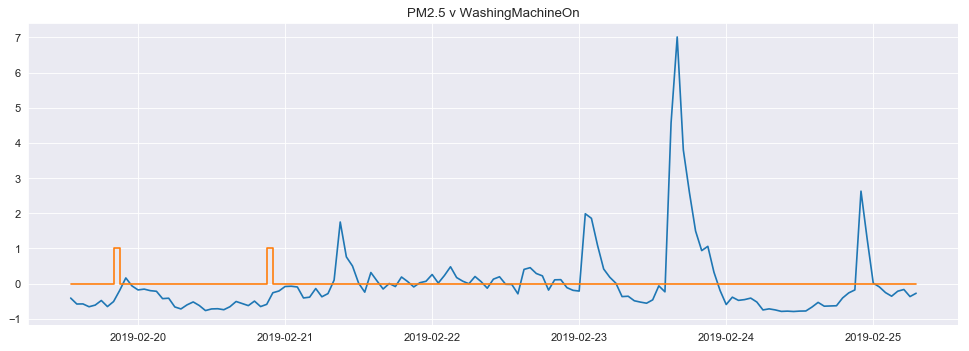

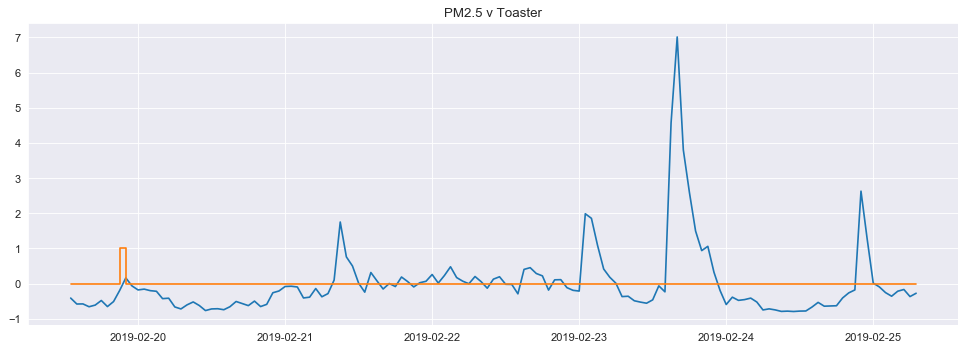

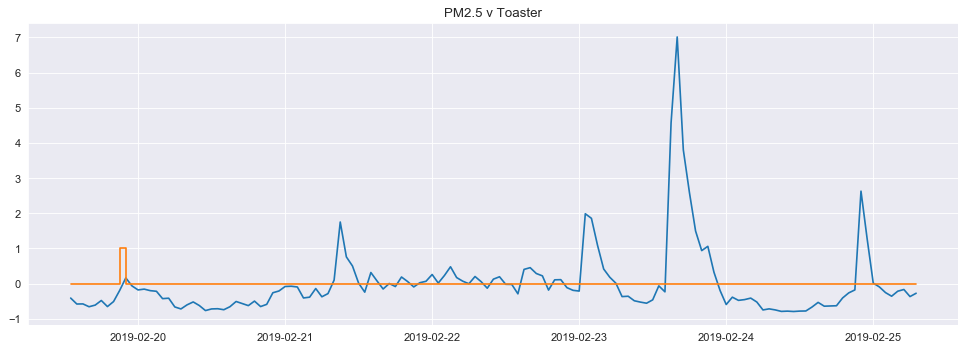

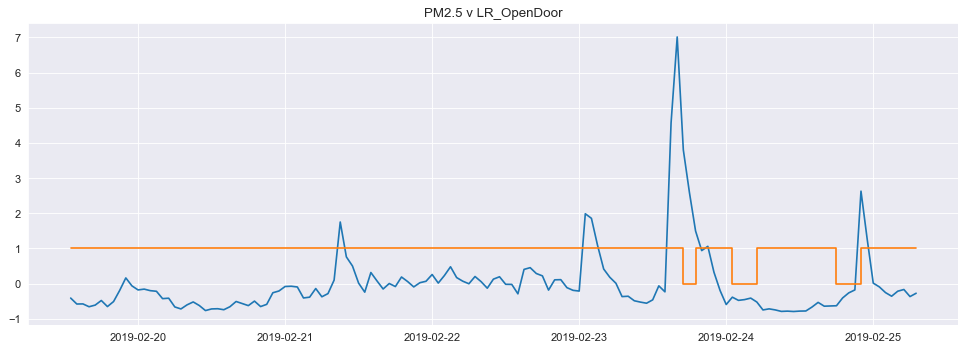

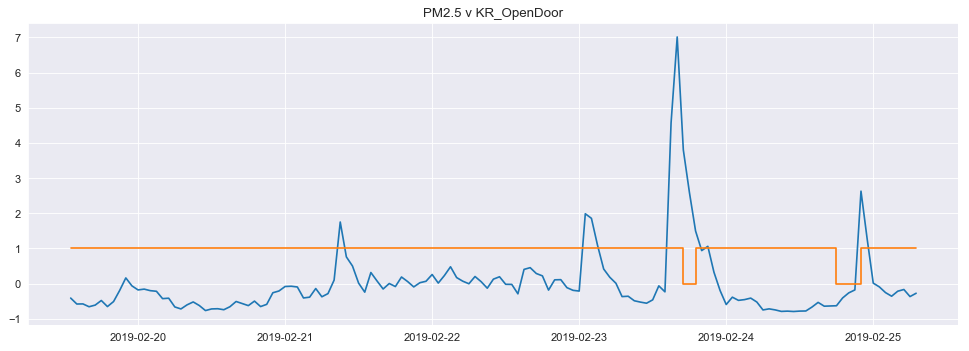

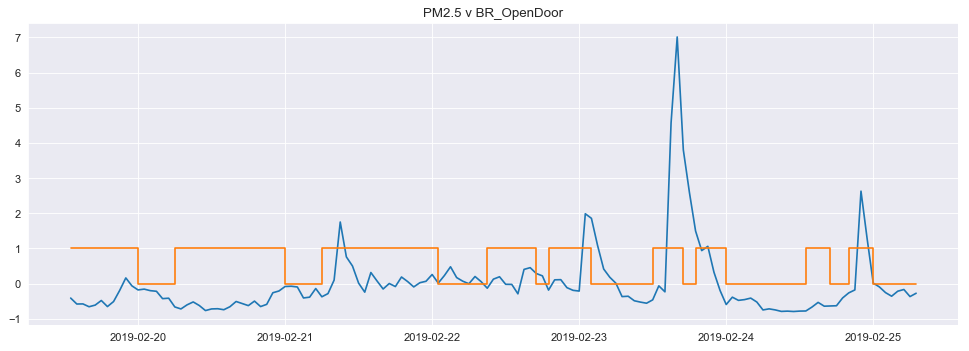

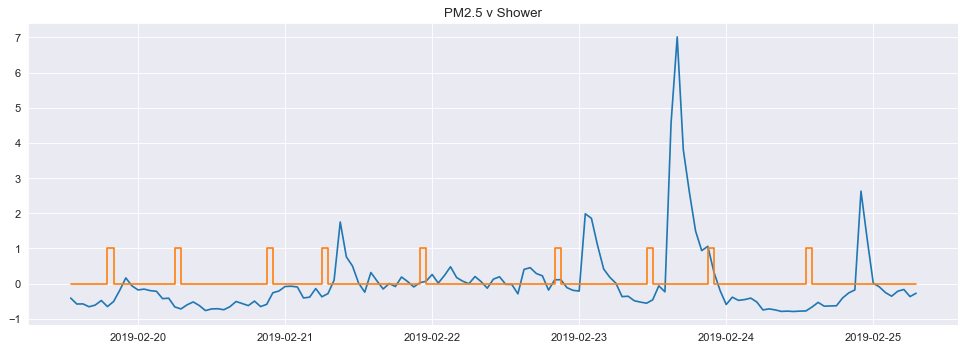

In [52]:
#Steplots LR2

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.step(x=LR2.index, y=LR2["BR_MaxOccupancy"]);
plt.title('PM2.5 v BR_MaxOccupancy')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.step(x=LR2.index, y=LR2["BR_OpenWindows"]);
plt.title('PM2.5 v BR_OpenWindows')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v BR_OpenCurtains')
plt.step(x=LR2.index, y=LR2["BR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v BR_HeatingOn')
plt.step(x=LR2.index, y=LR2["BR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v BR_Hoovering')
plt.step(x=LR2.index, y=LR2["BR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v BR_Mopping')
plt.step(x=LR2.index, y=LR2["BR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v LR_MaxOccupancy')
plt.step(x=LR2.index, y=LR2["LR_MaxOccupancy"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v LR_OpenWindow')
plt.step(x=LR2.index, y=LR2["LR_OpenWindow"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v LR_OpenCurtains')
plt.step(x=LR2.index, y=LR2["LR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v LR_HeatingOn')
plt.step(x=LR2.index, y=LR2["LR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v LR_Hoovering')
plt.step(x=LR2.index, y=LR2["LR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v LR_Mopping')
plt.step(x=LR2.index, y=LR2["LR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v Boiling')
plt.step(x=LR2.index, y=LR2["Boiling"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v Frying')
plt.step(x=LR2.index, y=LR2["Frying"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v KR_HeatingOn')
plt.step(x=LR2.index, y=LR2["KR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v KR_Hoovering')
plt.step(x=LR2.index, y=LR2["KR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v KR_Mopping')
plt.step(x=LR2.index, y=LR2["KR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v DishwasherOn')
plt.step(x=LR2.index, y=LR2["DishwasherOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v WashingMachineOn')
plt.step(x=LR2.index, y=LR2["WashingMachineOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v Toaster')
plt.step(x=LR2.index, y=LR2["Toaster"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v Toaster')
plt.step(x=LR2.index, y=LR2["Toaster"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v LR_OpenDoor')
plt.step(x=LR2.index, y=LR2["LR_OpenDoor"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v KR_OpenDoor')
plt.step(x=LR2.index, y=LR2["KR_OpenDoor"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v BR_OpenDoor')
plt.step(x=LR2.index, y=LR2["BR_OpenDoor"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(LR2["PM2.5"])
plt.title('PM2.5 v Shower')
plt.step(x=LR2.index, y=LR2["Shower"]);
plt.show()

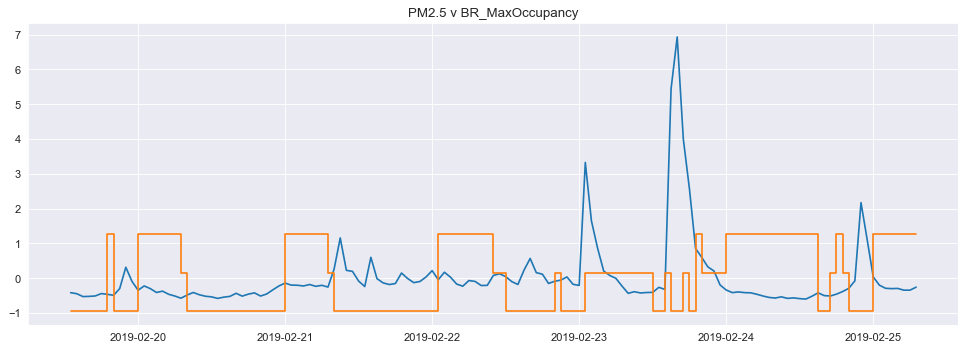

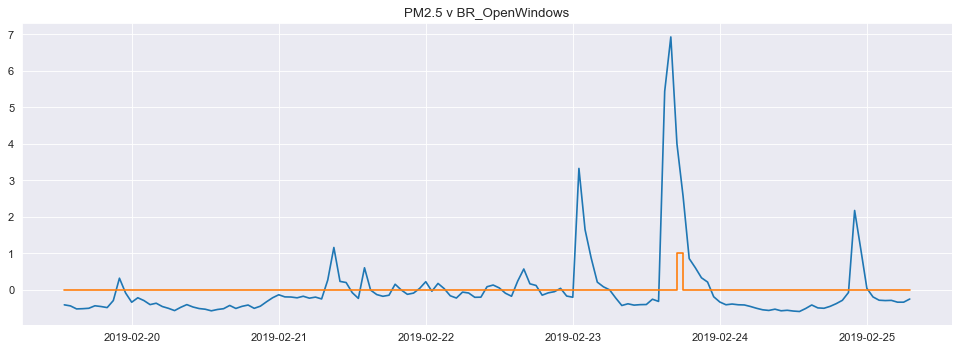

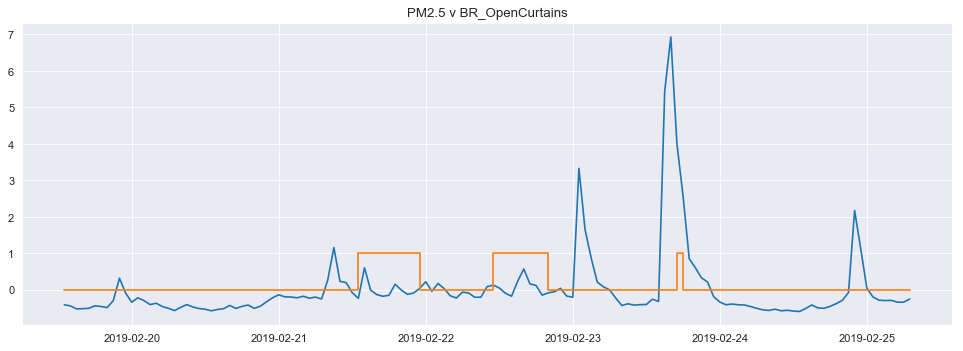

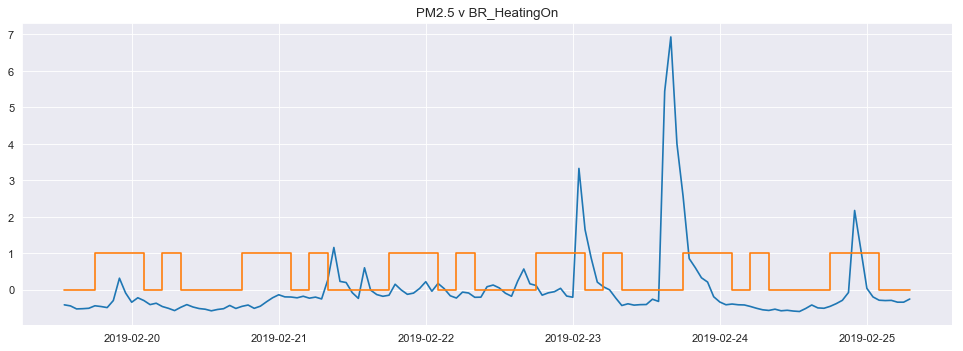

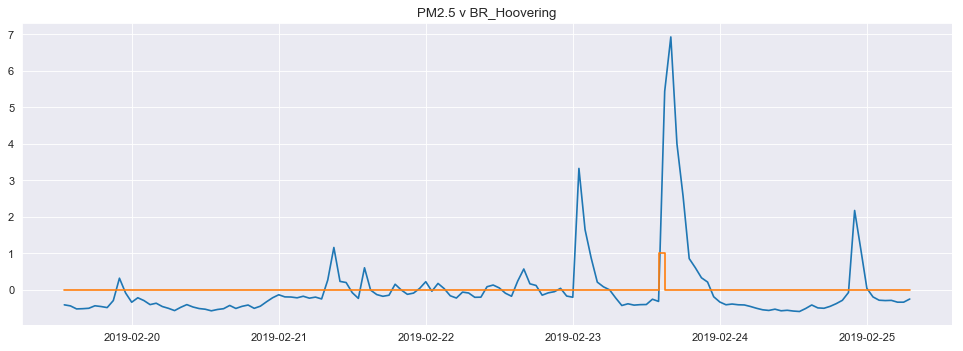

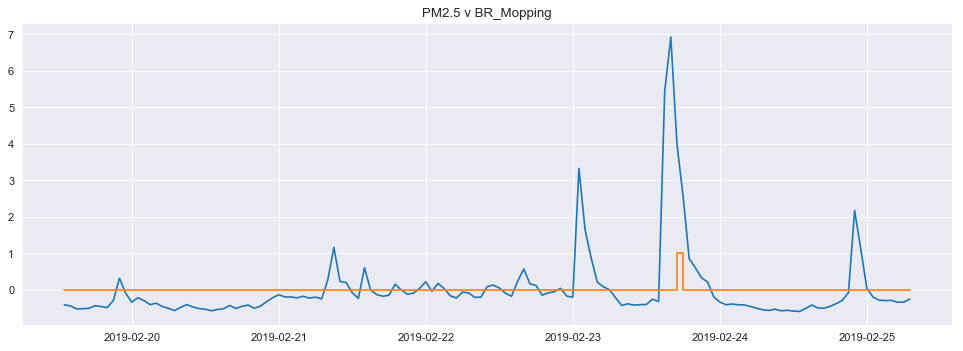

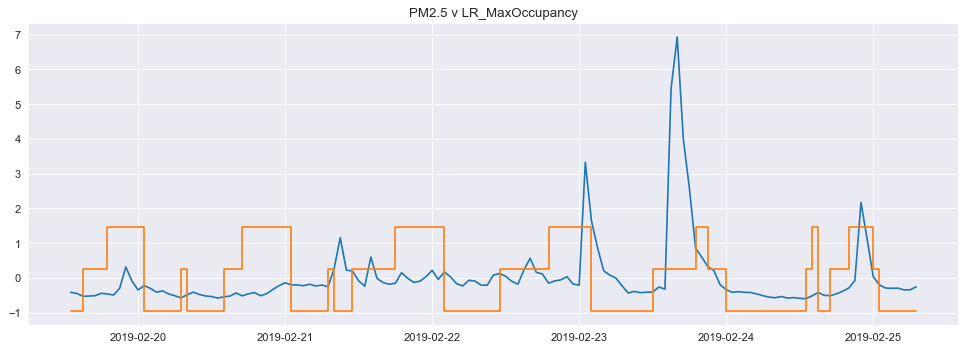

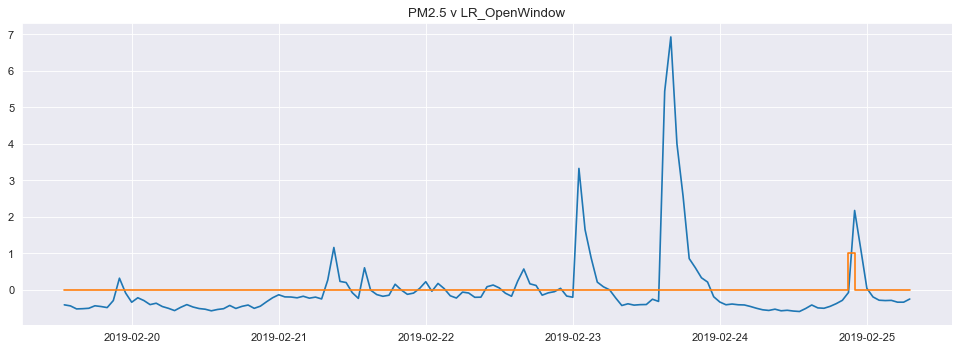

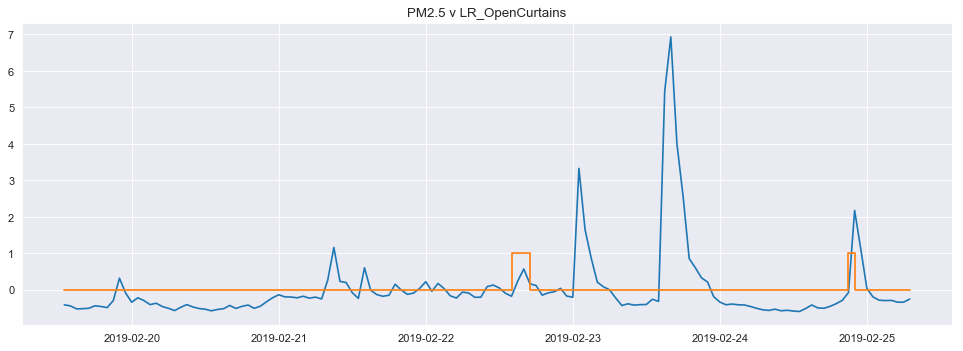

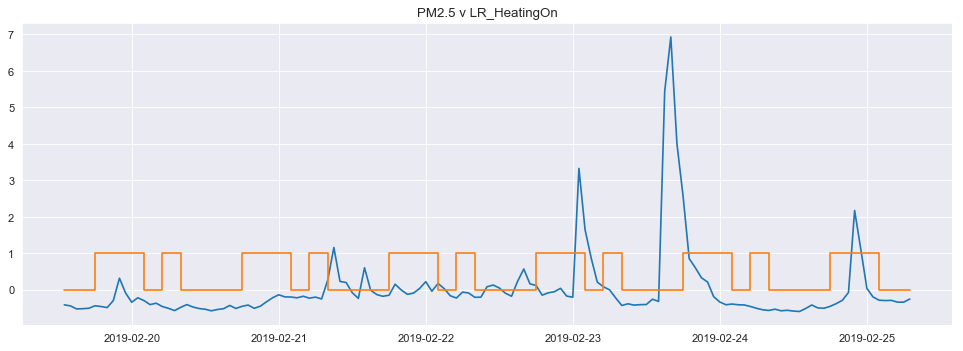

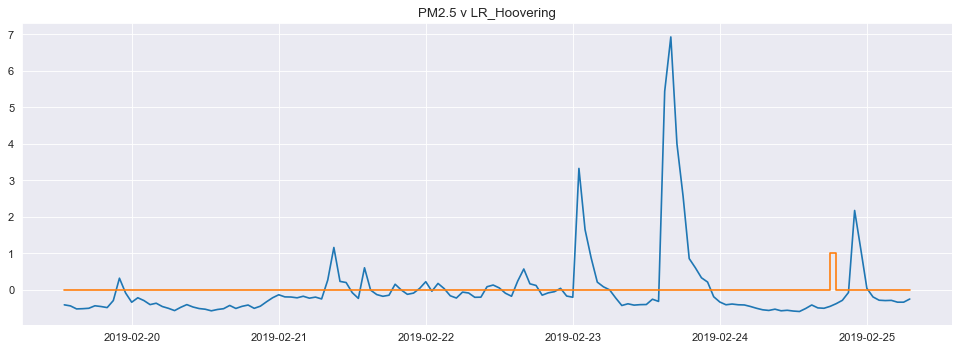

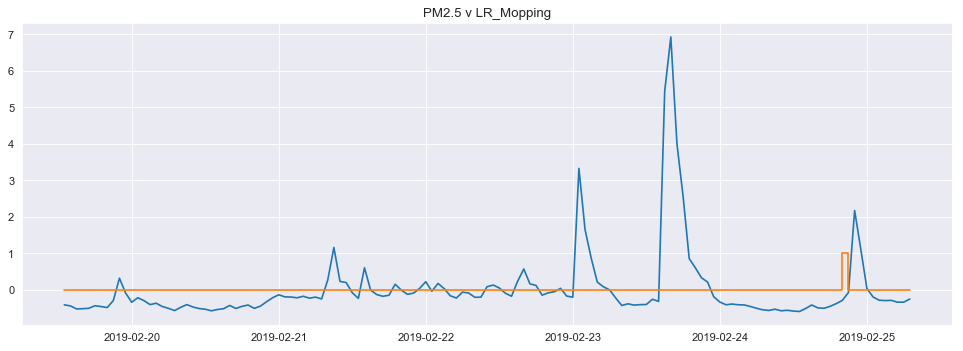

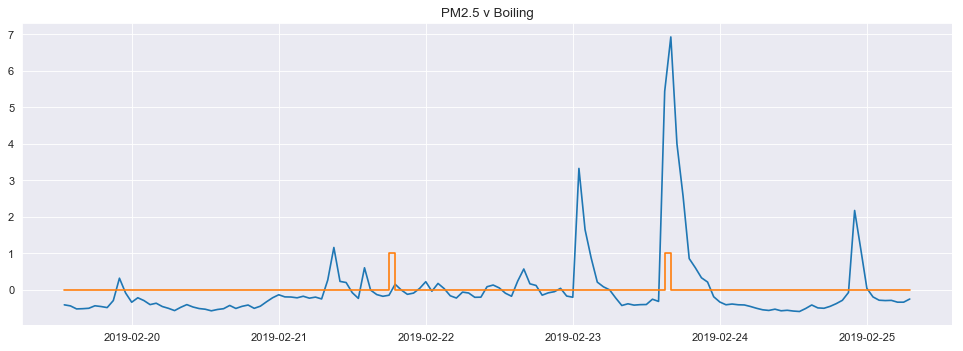

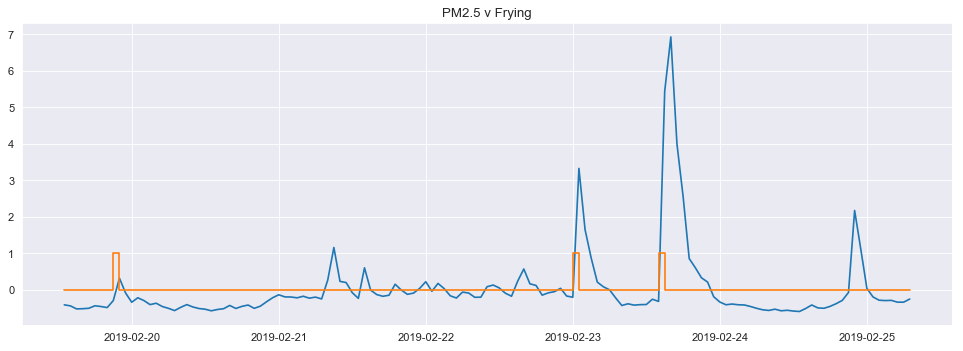

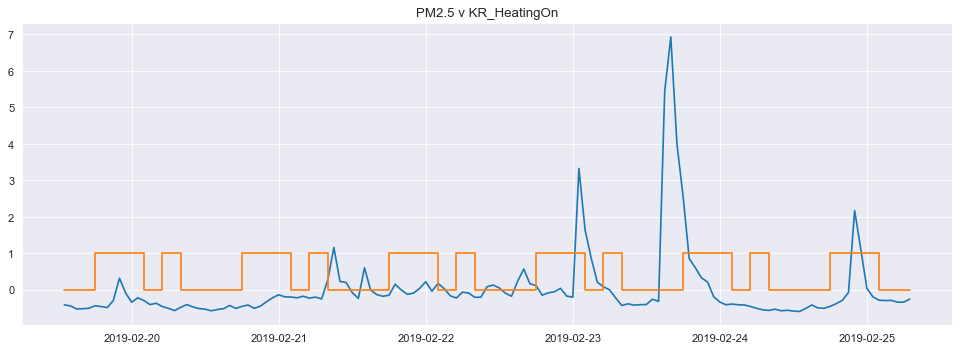

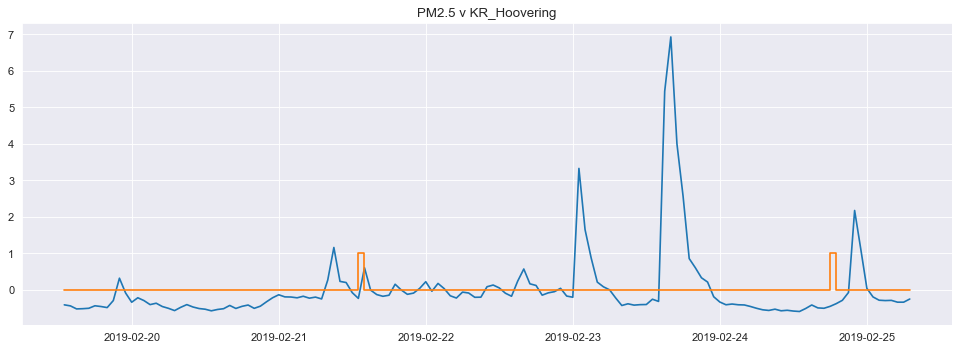

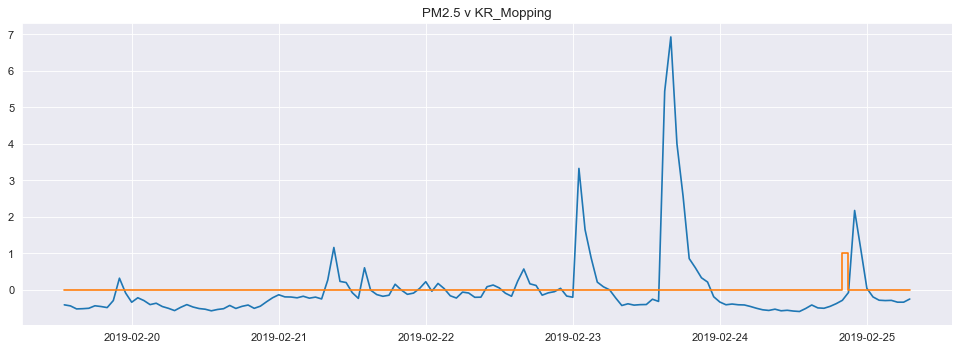

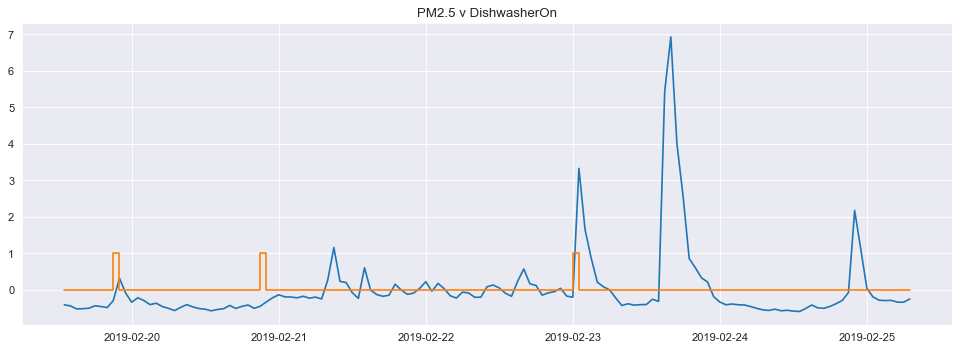

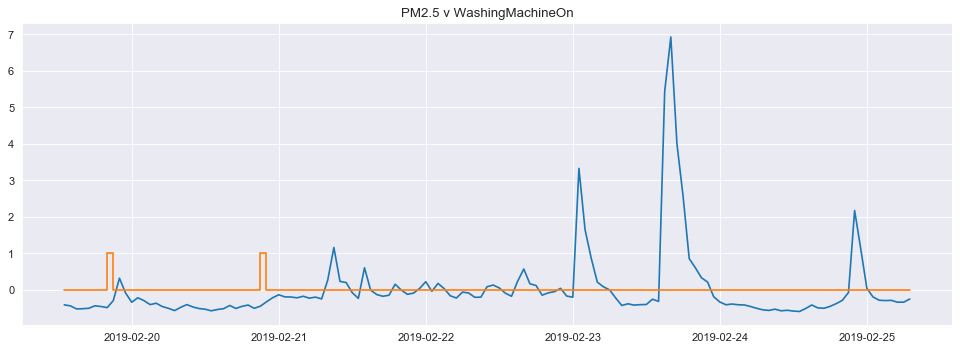

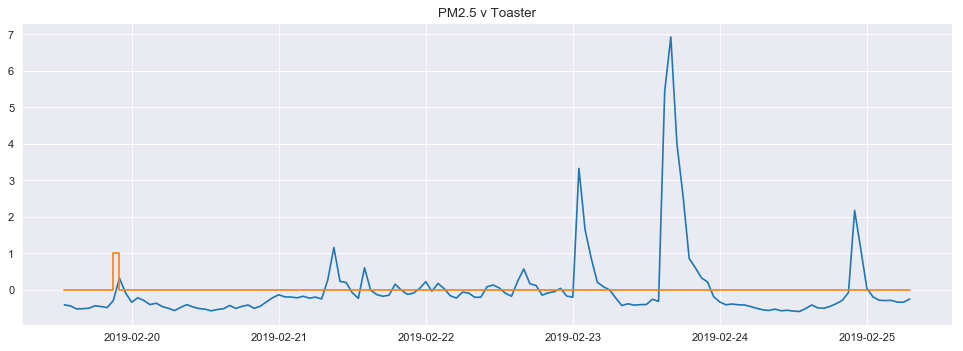

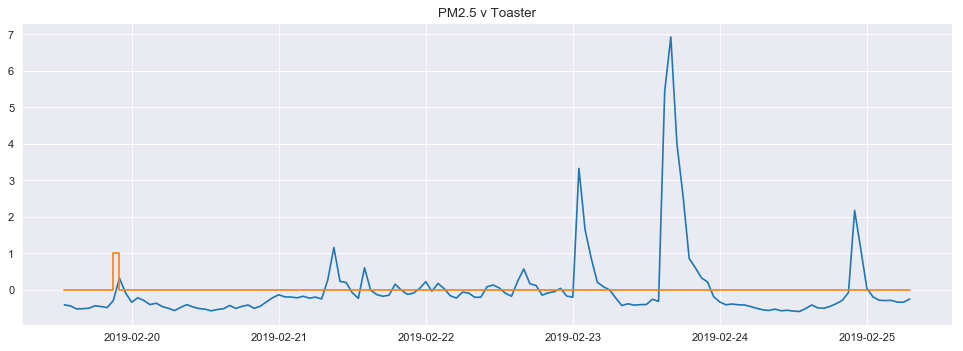

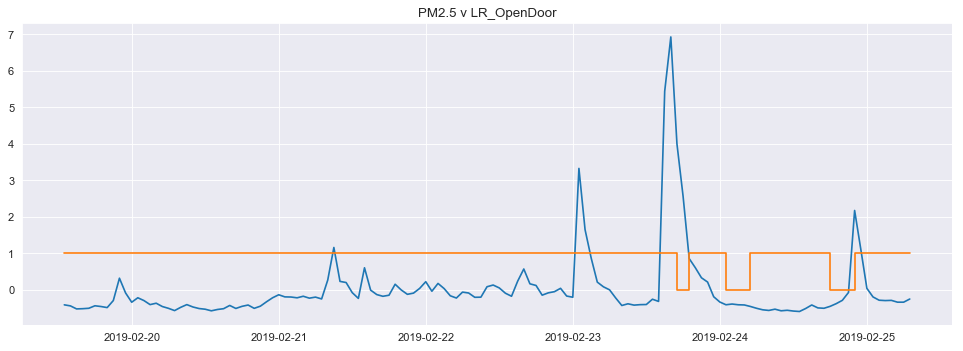

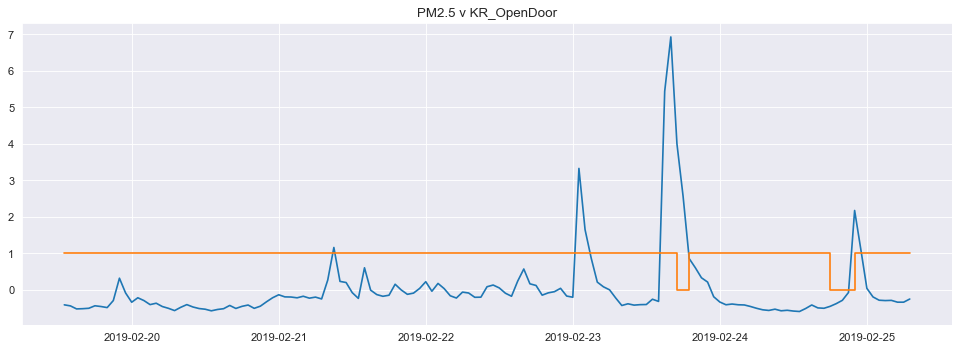

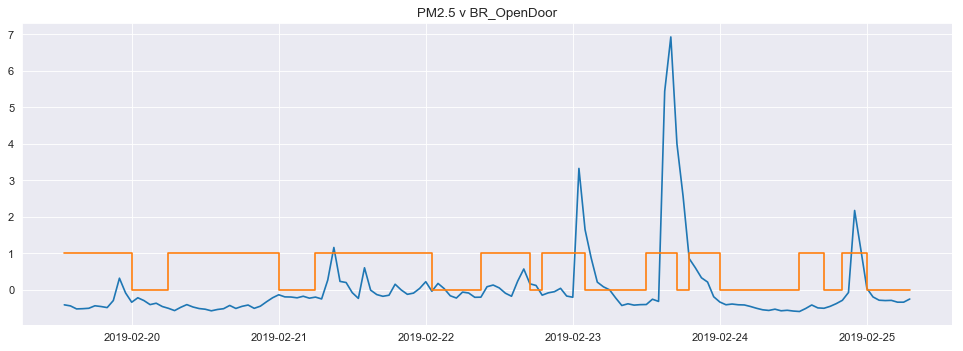

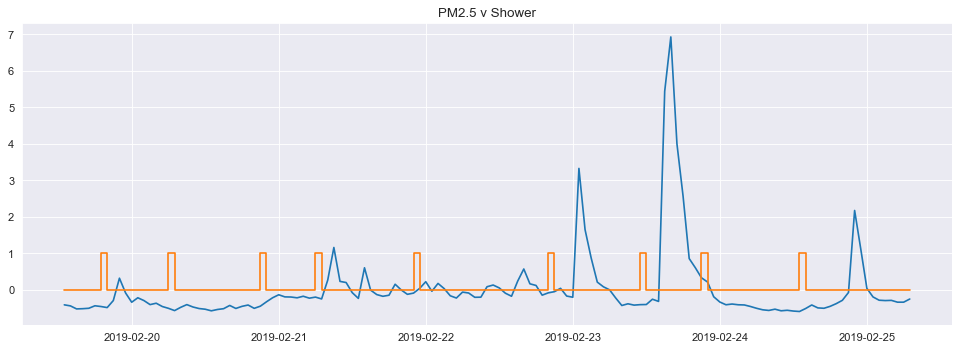

In [53]:
#Steplots KR2

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.step(x=KR2.index, y=KR2["BR_MaxOccupancy"]);
plt.title('PM2.5 v BR_MaxOccupancy')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.step(x=KR2.index, y=KR2["BR_OpenWindows"]);
plt.title('PM2.5 v BR_OpenWindows')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v BR_OpenCurtains')
plt.step(x=KR2.index, y=KR2["BR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v BR_HeatingOn')
plt.step(x=KR2.index, y=KR2["BR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v BR_Hoovering')
plt.step(x=KR2.index, y=KR2["BR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v BR_Mopping')
plt.step(x=KR2.index, y=KR2["BR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v LR_MaxOccupancy')
plt.step(x=KR2.index, y=KR2["LR_MaxOccupancy"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v LR_OpenWindow')
plt.step(x=KR2.index, y=KR2["LR_OpenWindow"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v LR_OpenCurtains')
plt.step(x=KR2.index, y=KR2["LR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v LR_HeatingOn')
plt.step(x=KR2.index, y=KR2["LR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v LR_Hoovering')
plt.step(x=KR2.index, y=KR2["LR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v LR_Mopping')
plt.step(x=KR2.index, y=KR2["LR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v Boiling')
plt.step(x=KR2.index, y=KR2["Boiling"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v Frying')
plt.step(x=KR2.index, y=KR2["Frying"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v KR_HeatingOn')
plt.step(x=KR2.index, y=KR2["KR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v KR_Hoovering')
plt.step(x=KR2.index, y=KR2["KR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v KR_Mopping')
plt.step(x=KR2.index, y=KR2["KR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v DishwasherOn')
plt.step(x=KR2.index, y=KR2["DishwasherOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v WashingMachineOn')
plt.step(x=KR2.index, y=KR2["WashingMachineOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v Toaster')
plt.step(x=KR2.index, y=KR2["Toaster"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v Toaster')
plt.step(x=KR2.index, y=KR2["Toaster"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v LR_OpenDoor')
plt.step(x=KR2.index, y=KR2["LR_OpenDoor"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v KR_OpenDoor')
plt.step(x=KR2.index, y=KR2["KR_OpenDoor"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v BR_OpenDoor')
plt.step(x=KR2.index, y=KR2["BR_OpenDoor"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(KR2["PM2.5"])
plt.title('PM2.5 v Shower')
plt.step(x=KR2.index, y=KR2["Shower"]);
plt.show()

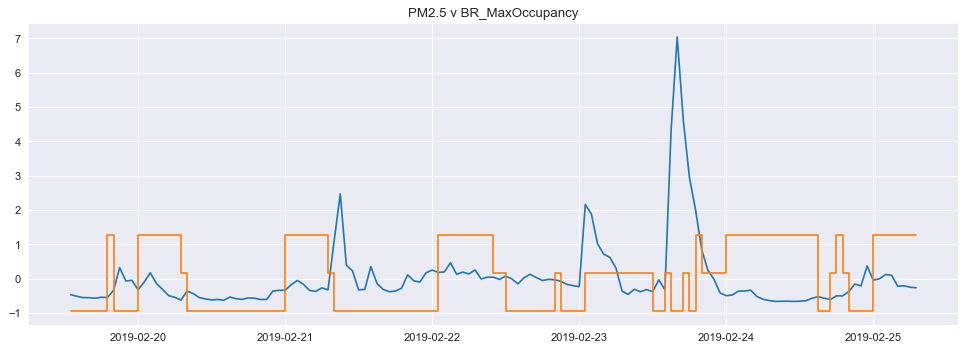

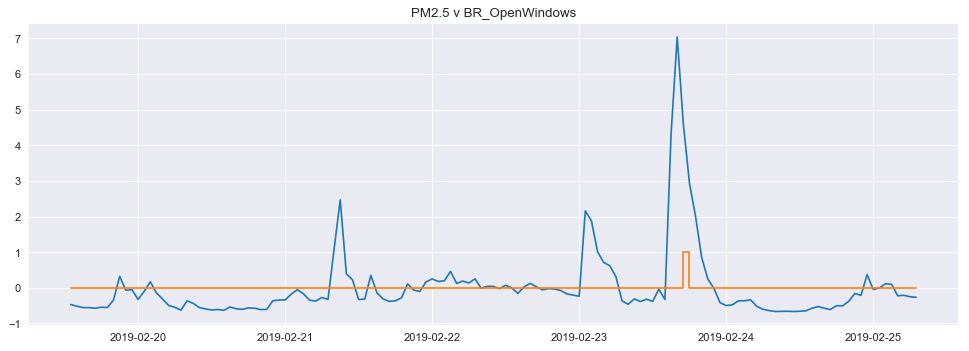

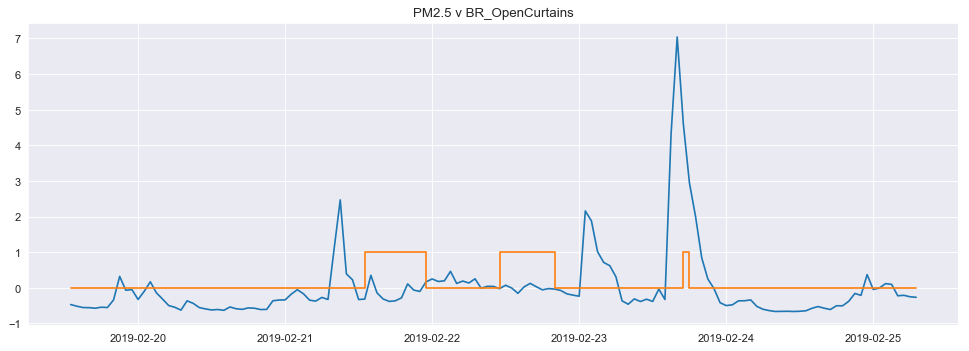

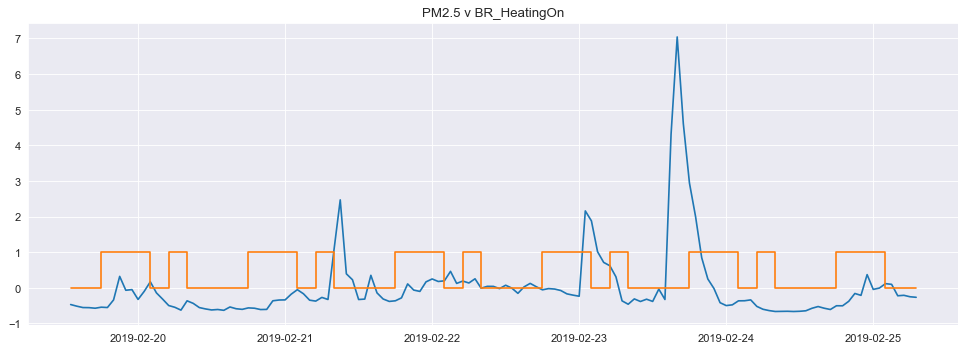

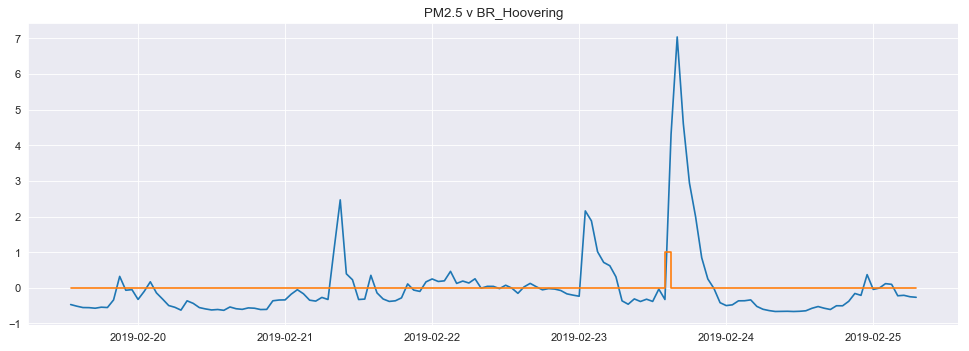

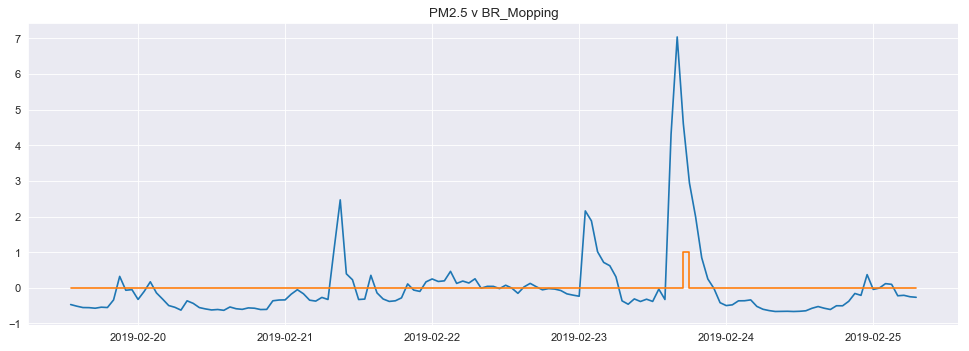

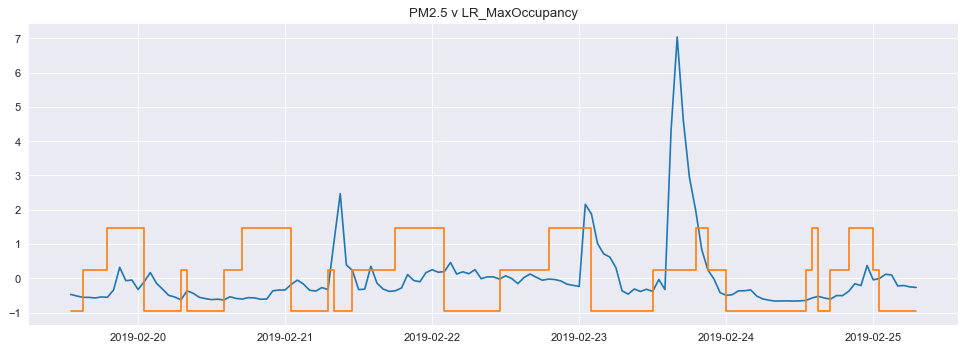

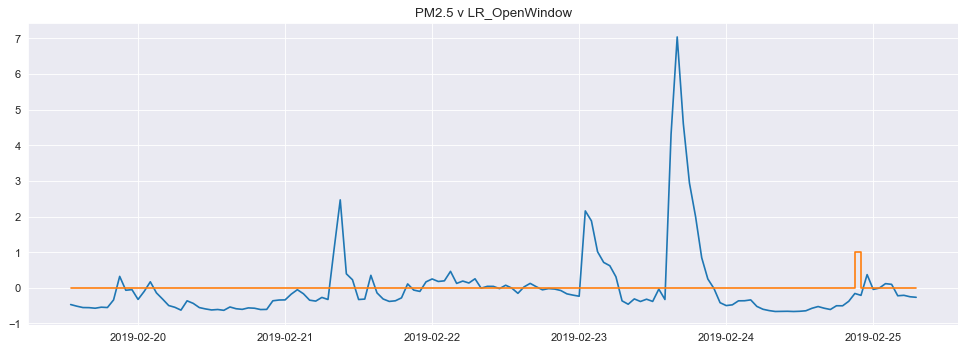

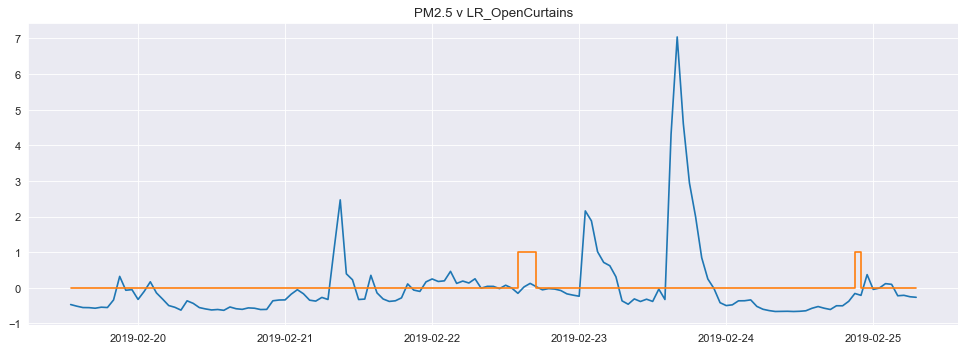

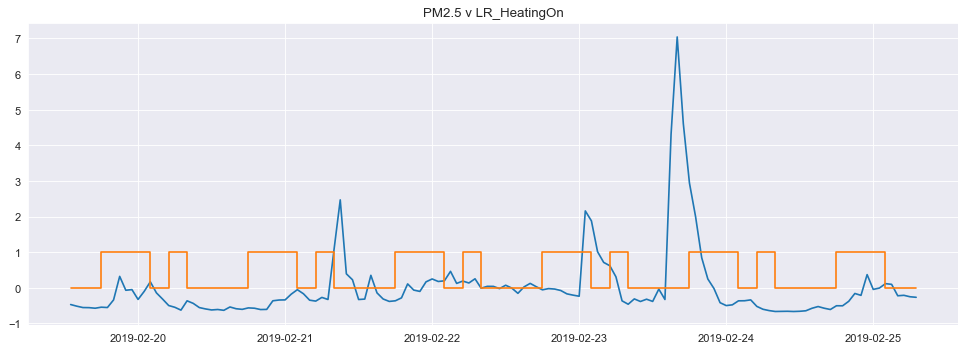

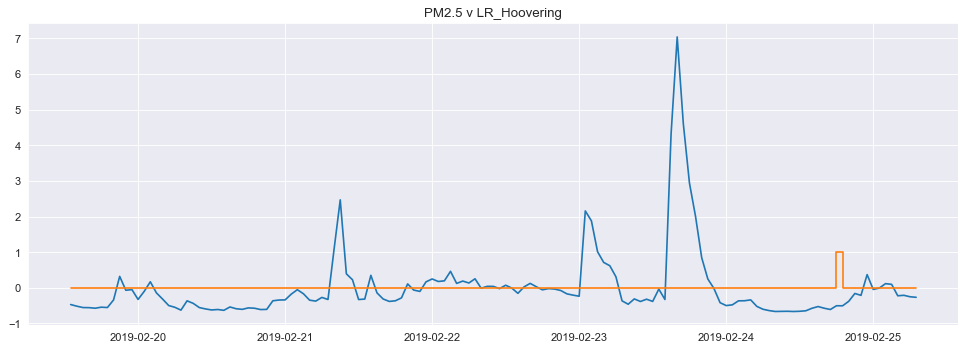

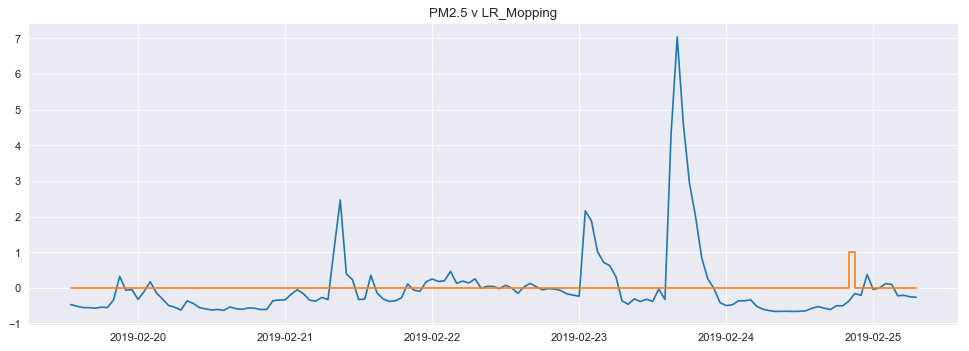

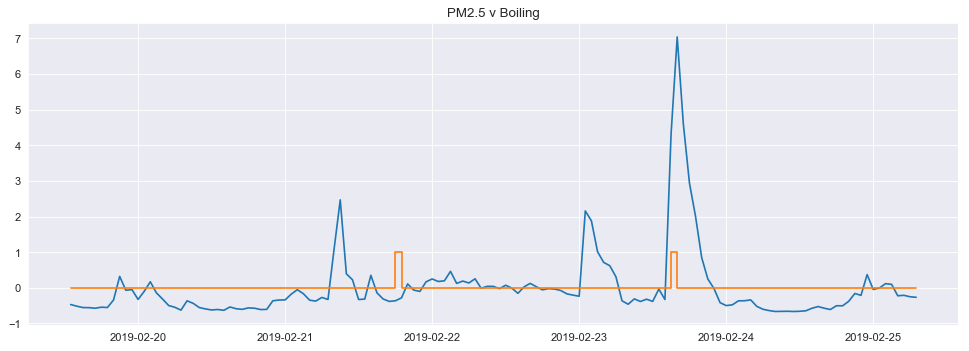

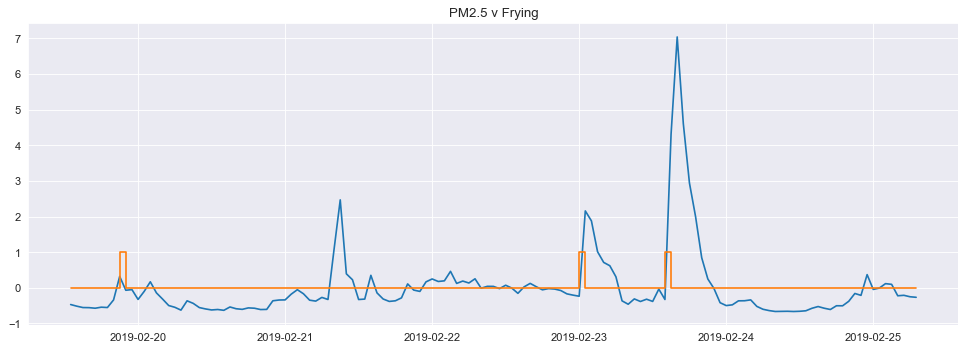

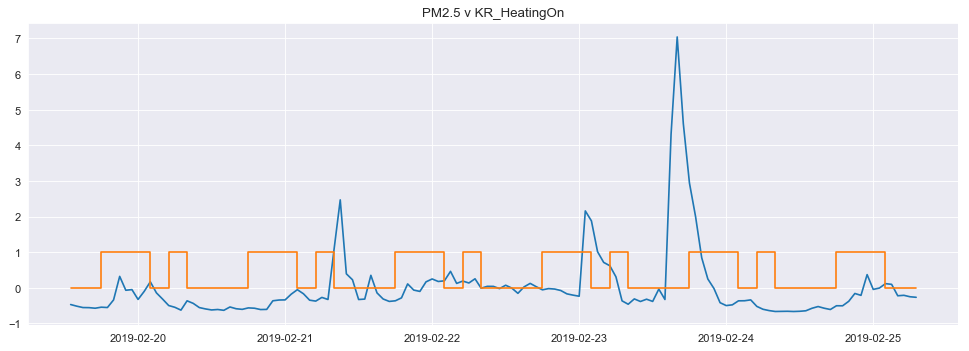

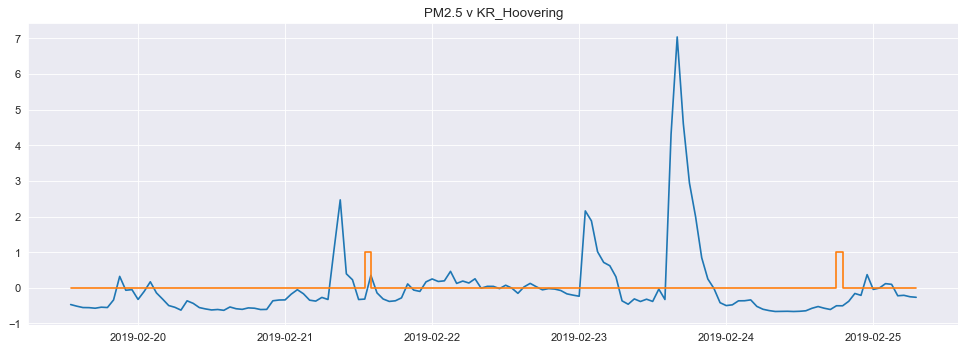

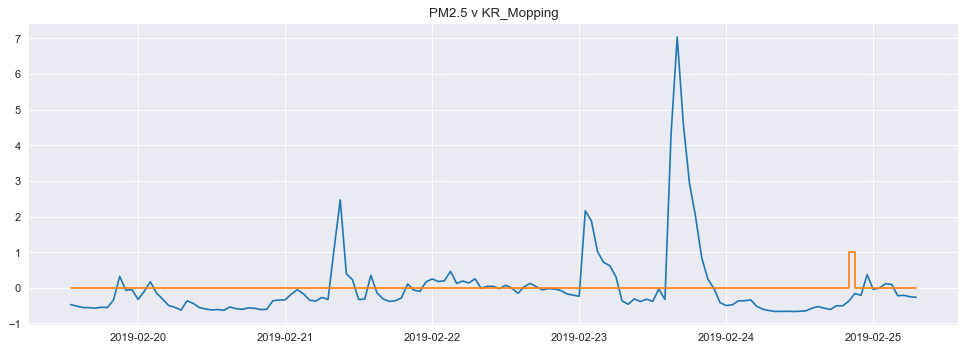

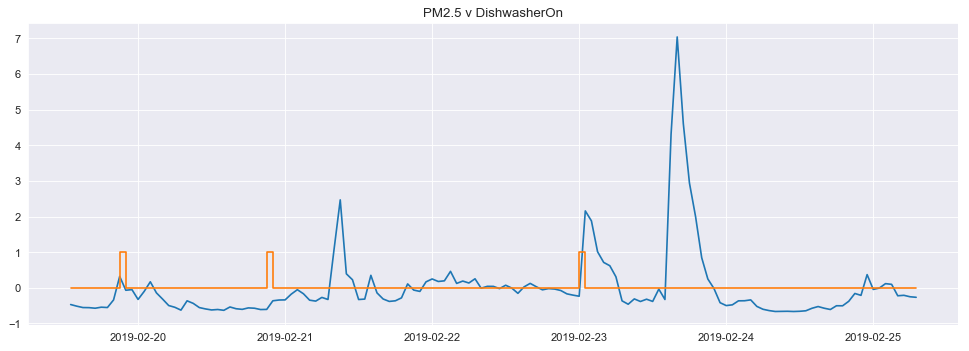

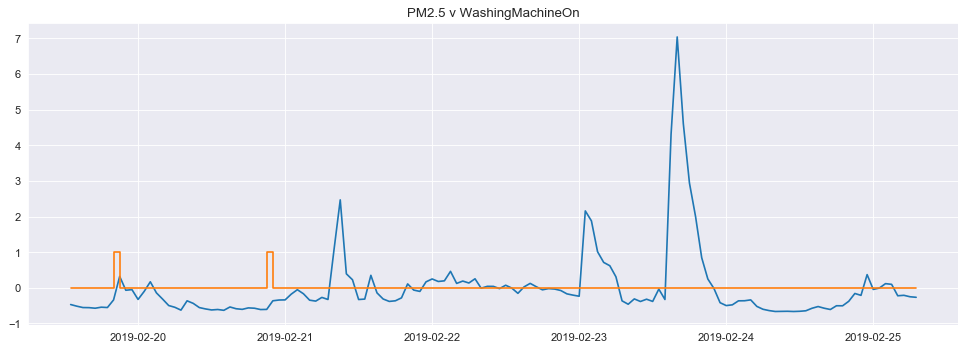

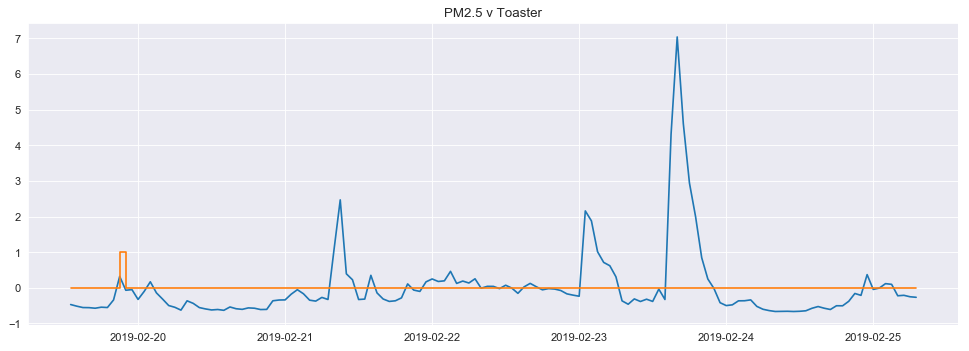

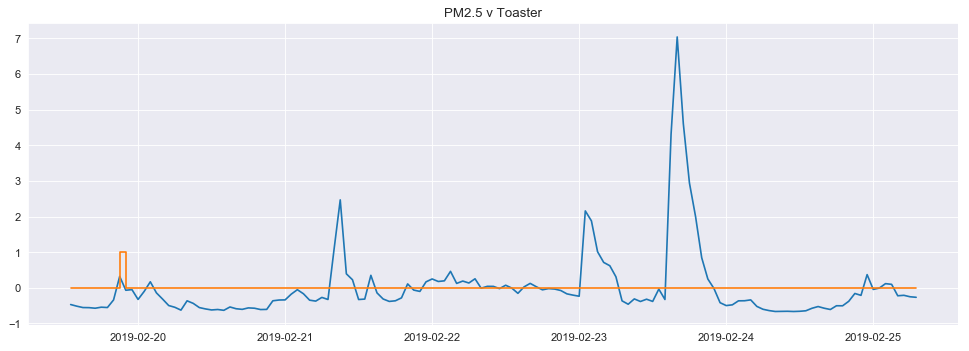

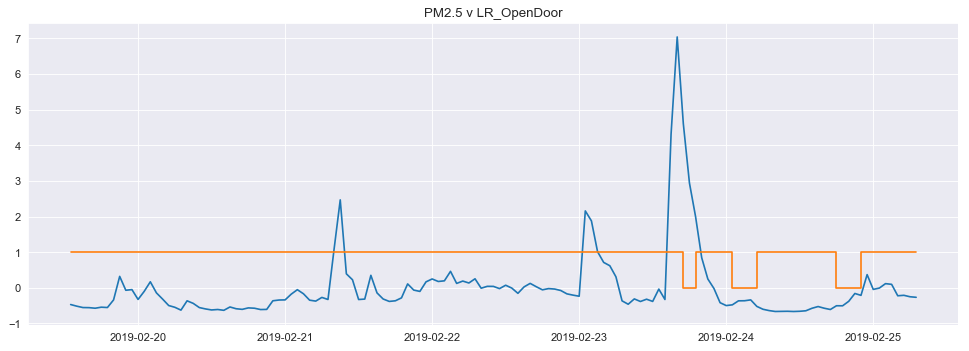

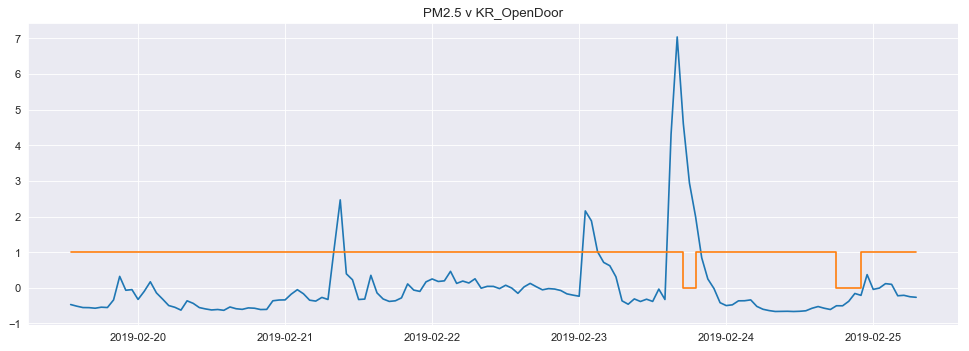

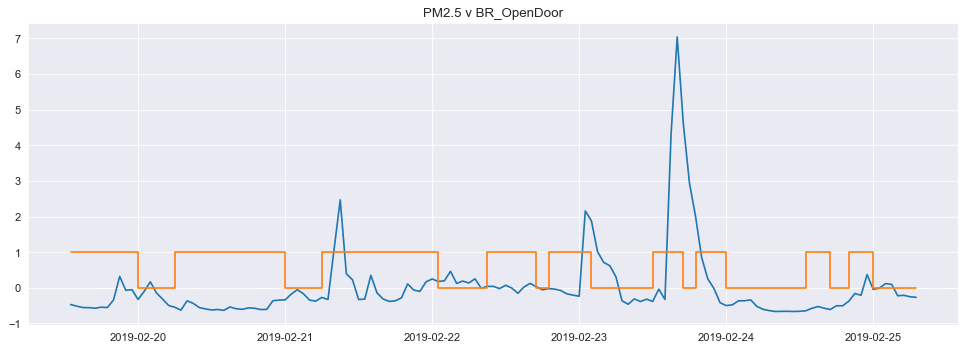

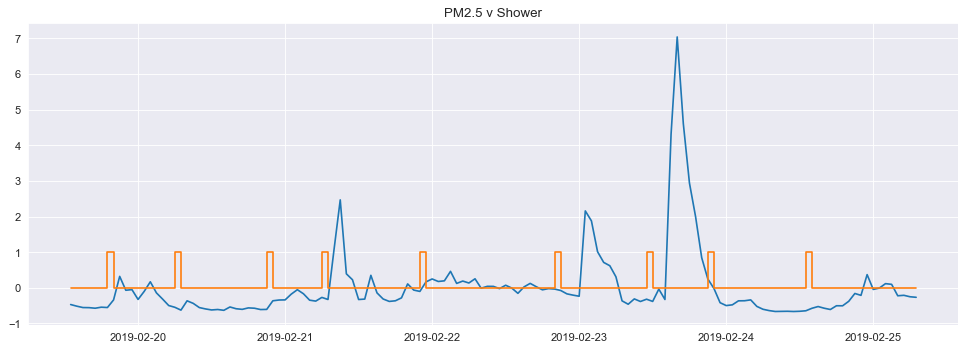

In [54]:
#Steplots BR2

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.step(x=BR2.index, y=BR2["BR_MaxOccupancy"]);
plt.title('PM2.5 v BR_MaxOccupancy')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.step(x=BR2.index, y=BR2["BR_OpenWindows"]);
plt.title('PM2.5 v BR_OpenWindows')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v BR_OpenCurtains')
plt.step(x=BR2.index, y=BR2["BR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v BR_HeatingOn')
plt.step(x=BR2.index, y=BR2["BR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v BR_Hoovering')
plt.step(x=BR2.index, y=BR2["BR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v BR_Mopping')
plt.step(x=BR2.index, y=BR2["BR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v LR_MaxOccupancy')
plt.step(x=BR2.index, y=BR2["LR_MaxOccupancy"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v LR_OpenWindow')
plt.step(x=BR2.index, y=BR2["LR_OpenWindow"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v LR_OpenCurtains')
plt.step(x=BR2.index, y=BR2["LR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v LR_HeatingOn')
plt.step(x=BR2.index, y=BR2["LR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v LR_Hoovering')
plt.step(x=BR2.index, y=BR2["LR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v LR_Mopping')
plt.step(x=BR2.index, y=BR2["LR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v Boiling')
plt.step(x=BR2.index, y=BR2["Boiling"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v Frying')
plt.step(x=BR2.index, y=BR2["Frying"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v KR_HeatingOn')
plt.step(x=BR2.index, y=BR2["KR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v KR_Hoovering')
plt.step(x=BR2.index, y=BR2["KR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v KR_Mopping')
plt.step(x=BR2.index, y=BR2["KR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v DishwasherOn')
plt.step(x=BR2.index, y=BR2["DishwasherOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v WashingMachineOn')
plt.step(x=BR2.index, y=BR2["WashingMachineOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v Toaster')
plt.step(x=BR2.index, y=BR2["Toaster"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v Toaster')
plt.step(x=BR2.index, y=BR2["Toaster"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v LR_OpenDoor')
plt.step(x=BR2.index, y=BR2["LR_OpenDoor"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v KR_OpenDoor')
plt.step(x=BR2.index, y=BR2["KR_OpenDoor"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v BR_OpenDoor')
plt.step(x=BR2.index, y=BR2["BR_OpenDoor"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR2["PM2.5"])
plt.title('PM2.5 v Shower')
plt.step(x=BR2.index, y=BR2["Shower"]);
plt.show()


# Modeling

## Only template models looked at so far with no hyper-tuning. Planning on trying linear regression with nonlinear parameters, Random Forest and Support Vector.

In [ ]:
#This function has an option to run a model with all variables and just sensor data to see how impactful our occupant 
#activity is on the model.

def train_test (df, allVars):
        
    if allVars == True:
        X = df.drop(["PM2.5"], axis=1)
    else:
        X = df[['Temp', 'RH', 'TVOC', 'CO2', 'AirPres']]
        
    y = df["PM2.5"]

    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)
    
    return (X_train, X_test, y_train, y_test, X, y)

In [ ]:
X_train, X_test, y_train, y_test, X, y = train_test(KR2, True)

In [ ]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

In [ ]:
#1.1. - Linear Regression ---------------------------#
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
model.score(X_train, y_train)
y_pred = model.predict(X_test)

print('Coefficients: \n', model.coef_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print('Cross Validation scores:',cross_val_score(model, X_train, y_train, cv=10))

In [ ]:
#1.2. - Decision Tree ---------------------------#
model = tree.DecisionTreeRegressor()
model.fit(X_train, y_train)
model.score(X_train, y_train)
y_pred= model.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print(cross_val_score(model, X_train, y_train, cv=10))

In [ ]:
#1.3. - Random Forest ---------------------------#
model = RandomForestRegressor(n_estimators = 1000, random_state = 42)
model.fit(X, y)
y_pred = model.predict(X_test)

print('Mean Absolute Error:', round(mean_absolute_error(y_test, y_pred),2), 'degrees.')
print('Mean Squared Error:',round(mean_squared_error(y_test, y_pred),4))
print('Accuracy:', r2_score(y_test, y_pred))
print(cross_val_score(model, X_train, y_train, cv=10))